In [ ]:
!pip3 install transformers owlready2 docx2txt fasttext python-docx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.4/27.4 MB 31.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 75.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 72.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.0 MB/s eta 0:00:00
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for owlready

# Importing Libraries

In [ ]:
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import torch
import docx
from transformers import BertTokenizer, BertModel, AutoModel
from gensim.models.fasttext import FastText
import matplotlib.pyplot as plt
import string
import re
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from owlready2 import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import docx2txt
import fasttext
from transformers import logging
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist
from scipy.spatial.distance import minkowski
from scipy.spatial.distance import cityblock
import hashlib
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

logging.set_verbosity_error()
%matplotlib inline

In [ ]:
nltk.download("punkt")
nltk.download('stopwords')
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

# Pre-processing

In [ ]:
# Load the pre-trained spaCy model
nlp = spacy.load("en_core_web_sm")

# Load the input docx file
doc = docx.Document("Input Text.docx")

# Extract the text from the docx file
text = "\n".join([paragraph.text for paragraph in doc.paragraphs])

# Use the spaCy model to split the text into sentences
doc = nlp(text)
sentences = [sent.text for sent in doc.sents]

# Filter valid sentences with atleast 2 nouns and a verb
valid_sentences = []
for sent in sentences:
    doc = nlp(sent)
    nouns = [token for token in doc if token.pos_ == "NOUN"]
    verbs = [token for token in doc if token.pos_ == "VERB"]
    if len(nouns) >= 2 and len(verbs) >= 1:
        # Filter out sentences with non-paired parenthesis
        if sent.count("(") == sent.count(")"):
            # Filter out sentences with ill-parsed formulas or composed terms
            if not re.search(r"\b\w+\([\w\s]+\)|\([\w\s]+\)\w+\b", sent):
                valid_sentences.append(sent)


valid_sentences

['A manufacturing resource is a physical machine or labor skill that is used in manufacturing artifacts.',
 'The manufacturing resource class has two subclasses: labor skill and manufacturing equipment.',
 'Labor skill represents labor rate and skill description.',
 'The manufacturing equipment subclass represents a piece of equipment (a physical entity).',
 'There are four subclasses: machine, die, mold and tool for machining.',
 'If necessary, other equipment classes may be added to the manufacturing equipment class.',
 'A piece of equipment has a set of parameters that describe equipment.',
 'A machine can be a machining centre, casting machine, forging machine, electrical discharge machine and so on.',
 'A machine has a set of parameters, such as dimension scope and tolerance scope.',
 'A tool represents a tool used in the machining process, such as a cutter, extender, holder and gauge.',
 'Each tool has a set of tool parameters.',
 'The tool class has four subclasses: cutting tool

In [ ]:
# Define a translation table to remove punctuations, symbols, and hyphens
translator = str.maketrans("", "", string.punctuation + "’‘“”")

# Remove punctuations, symbols, and hyphens from each element of the list
valid_sentences = [s.translate(translator).strip() for s in valid_sentences]

#Removing numbers if any
valid_sentences = [re.sub(r'\d+', '', x).strip() for x in valid_sentences]

#Removing unnecessary punctuations from the text
valid_sentences = [n.replace('\n', '') for n in valid_sentences]
valid_sentences = [n.replace('\t', '') for n in valid_sentences]
valid_sentences = [n.replace('–', '') for n in valid_sentences]

valid_sentences

['A manufacturing resource is a physical machine or labor skill that is used in manufacturing artifacts',
 'The manufacturing resource class has two subclasses labor skill and manufacturing equipment',
 'Labor skill represents labor rate and skill description',
 'The manufacturing equipment subclass represents a piece of equipment a physical entity',
 'There are four subclasses machine die mold and tool for machining',
 'If necessary other equipment classes may be added to the manufacturing equipment class',
 'A piece of equipment has a set of parameters that describe equipment',
 'A machine can be a machining centre casting machine forging machine electrical discharge machine and so on',
 'A machine has a set of parameters such as dimension scope and tolerance scope',
 'A tool represents a tool used in the machining process such as a cutter extender holder and gauge',
 'Each tool has a set of tool parameters',
 'The tool class has four subclasses cutting tool ﬁxture tool gauging tool 

In [ ]:
len(valid_sentences)

27

# Ontologies

In [ ]:
#Loading the Ontologies
mason = get_ontology("mason.owl").load()
saref4inma = get_ontology("saref4inma.rdf").load()
msdl = get_ontology("MSDL.owl").load()
pronto = get_ontology("bpo.rdf").load()
smo = get_ontology("smo.owl").load()

## Mason

In [ ]:
# Get the list of classes with annotations
mason_class = []

for cls in mason.classes():
    annotations = cls.comment
    if annotations:
        mason_class.append(cls.name)

mason_class

['ManufacturingOperation',
 'GeometricEntityForManufacturing',
 'RawMaterial',
 'System',
 'Set',
 'Semi-finishedPart',
 'GeographicResource',
 'MaterialResource',
 'MachineResource',
 'LogisticOperation',
 'HumanResource',
 'Operation',
 'Shape',
 'AssemblyEntity',
 'Symmetry',
 'Tool',
 'MachineTool',
 'Topology',
 'Resource',
 'MechanicalSmallVariationsOfVolume',
 'Assembly',
 'Entity',
 'Part',
 'FormingMachine',
 'RevolutionEntity',
 'FusionNoLossOfVolume',
 'Control',
 'PhysicochemicalSmallVariationsOfVolume',
 'HeatOrSurfaceTreatmentMachine',
 'GeometricFlaw',
 'MechanicalNoLossOfVolume',
 'FoundingMachine',
 'ThermalNoLossOfVolume',
 'Thermal_Loss_of_volume',
 'GeometricEntity',
 'Shearing_machine-tool',
 'ThermalSmallVariationsOfVolume',
 'HoldOn',
 'HumanOperation',
 'LaunchingOperation',
 'LinearEntity',
 'LossOfVolume',
 'NoLossOfVolume',
 'SmallVariationsOfVolume',
 'Mechanical_Loss_of_volume',
 'TruckResource',
 'PhysicochemicalLossOfVolume',
 'Pocket',
 'Polishing',
 'Sh

In [ ]:
mason.classes()
mason_cls = list(mason.classes())

In [ ]:
mason.properties()
mason_property = list(mason.properties())

In [ ]:
mason_annotations = []
for ann in mason_cls:
    print(f"\t{ann}: {ann.comment}")
    mason_annotations.append(str(ann.comment))

	mason.ManufacturingOperation: ['Describes the manufacturing operations']
	mason.GeometricEntityForManufacturing: [locstr("Helpers for describing part's geometry", 'en')]
	mason.RawMaterial: ['Describes raw material features of a part']
	mason.System: ['Describes a created System']
	mason.FinishedPart: []
	mason.Set: ['Describes a produced Set']
	mason.Semi-finishedPart: [locstr('Concrete part, being worked', 'en')]
	mason.GeographicResource: ['Represents various geographic resources such as buildings, shop floors, workshops and sites.']
	mason.MaterialResource: ['Represent the material resources such as machines and tools']
	mason.MachineResource: ['Describes the machine resources']
	mason.LogisticOperation: ['Describes processes related to logistic operations']
	mason.HumanResource: ['Represents the human resources of an Business entity']
	mason.Operation: ['Operation class describes concepts related to processes']
	mason.Shape: ['Describes the geometric feature, Shape']
	mason.Blank

In [ ]:
# Remove the full stop from each element
mason_annotations = [x.replace('.', '') for x in mason_annotations]

for i in range(len(mason_annotations)):
    mason_annotations[i] = mason_annotations[i] + "."

mason_annotations

["['Describes the manufacturing operations'].",
 '[locstr("Helpers for describing part\'s geometry", \'en\')].',
 "['Describes raw material features of a part'].",
 "['Describes a created System'].",
 '[].',
 "['Describes a produced Set'].",
 "[locstr('Concrete part, being worked', 'en')].",
 "['Represents various geographic resources such as buildings, shop floors, workshops and sites'].",
 "['Represent the material resources such as machines and tools'].",
 "['Describes the machine resources'].",
 "['Describes processes related to logistic operations'].",
 "['Represents the human resources of an Business entity'].",
 "['Operation class describes concepts related to processes'].",
 "['Describes the geometric feature, Shape'].",
 '[].',
 '[].',
 "['Represents assebled parts by a manufacturing operation'].",
 "['Describes the geometric feature, Symmetry'].",
 "['An implement, used to carry out a particular operation'].",
 "['Contains a wide variety of machines'].",
 '[].',
 "['Describes

In [ ]:
mason_ann = ', '.join(mason_annotations)

# define a regular expression to match non-word characters except full stops
regex = re.compile('[%s]' % re.escape(string.punctuation.replace('.', '')))

# apply the regular expression to remove non-word characters
mason_ann = regex.sub('', mason_ann)
mason_ann = re.sub(r'\b(?<!\w)en\b(?!\w)', '', mason_ann)

mason_ann

'Describes the manufacturing operations. locstrHelpers for describing parts geometry . Describes raw material features of a part. Describes a created System. . Describes a produced Set. locstrConcrete part being worked . Represents various geographic resources such as buildings shop floors workshops and sites. Represent the material resources such as machines and tools. Describes the machine resources. Describes processes related to logistic operations. Represents the human resources of an Business entity. Operation class describes concepts related to processes. Describes the geometric feature Shape. . . Represents assebled parts by a manufacturing operation. Describes the geometric feature Symmetry. An implement used to carry out a particular operation. Contains a wide variety of machines. . Describes the geometric feature Topology. . . . locstrResource class contains geographic human material and truck resources . . . . . . . . . . . . locstrMechanical manufacturing operation with sm

In [ ]:
sentences_mason = mason_ann.split('. ')
valid_sentences_mason = [s.strip() for s in sentences_mason]

In [ ]:
# Define a translation table to remove punctuations, symbols, and hyphens
translator_mason = str.maketrans("", "", string.punctuation + "’‘“”")

# Remove punctuations, symbols, and hyphens from each element of the list
valid_sentences_mason = [s.translate(translator_mason).strip() for s in valid_sentences_mason]

#Removing unnecessary punctuations from the text
valid_sentences_mason = [n.replace('\n', '') for n in valid_sentences_mason]
valid_sentences_mason = [n.replace('locstr', '') for n in valid_sentences_mason]
valid_sentences_mason = [n.replace('-', '') for n in valid_sentences_mason]

valid_sentences_mason = [item for item in valid_sentences_mason if item != ' ' and item != '']

valid_sentences_mason

['Describes the manufacturing operations',
 'Helpers for describing parts geometry',
 'Describes raw material features of a part',
 'Describes a created System',
 'Describes a produced Set',
 'Concrete part being worked',
 'Represents various geographic resources such as buildings shop floors workshops and sites',
 'Represent the material resources such as machines and tools',
 'Describes the machine resources',
 'Describes processes related to logistic operations',
 'Represents the human resources of an Business entity',
 'Operation class describes concepts related to processes',
 'Describes the geometric feature Shape',
 'Represents assebled parts by a manufacturing operation',
 'Describes the geometric feature Symmetry',
 'An implement used to carry out a particular operation',
 'Contains a wide variety of machines',
 'Describes the geometric feature Topology',
 'Resource class contains geographic human material and truck resources',
 'Mechanical manufacturing operation with small v

In [ ]:
# Chexking for duplicates
unique_items = set(valid_sentences_mason)
duplicates = [item for item in unique_items if valid_sentences_mason.count(item) > 1]
duplicates

['Describes  manufacturing operations which affects loss of volume']

In [ ]:
len(valid_sentences_mason)

55

### Bert Model

In [ ]:
# Load pre-trained model and tokenizer
model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# define the get_embedding function
def get_embedding(text, model, tokenizer):
    input_ids = tokenizer.encode(text, add_special_tokens=True)
    input_ids = torch.tensor(input_ids).unsqueeze(0)
    with torch.no_grad():
        outputs = model(input_ids)
        last_hidden_states = outputs[0].squeeze(0)
        mean_last_hidden_states = torch.mean(last_hidden_states, dim=0)
    return mean_last_hidden_states.numpy()

In [ ]:
# Create empty lists for embeddings
bert_embeddings = []
bert_embeddings_mason = []

# Loop over sentences and calculate embeddings
for sent1 in valid_sentences:
    embedding1 = get_embedding(sent1, model, tokenizer)
    bert_embeddings.append(embedding1)
    for sent2 in valid_sentences_mason:
        embedding2 = get_embedding(sent2, model, tokenizer)
        bert_embeddings_mason.append(embedding2)

# Create dataframe
data_mason = {
    "Input_Sentence": [],
    "Annotation": [],
    "Input_Sentence_Embedding": [],
    "Annotation_Embedding": [],
}

for sent1, emb1 in zip(valid_sentences, bert_embeddings):
    for sent2, emb2 in zip(valid_sentences_mason, bert_embeddings_mason):
        data_mason["Input_Sentence"].append(sent1)
        data_mason["Annotation"].append(sent2)
        data_mason["Input_Sentence_Embedding"].append(emb1)
        data_mason["Annotation_Embedding"].append(emb2)

df_mason = pd.DataFrame(data_mason)

In [ ]:
df_mason.head(10)

,Input_Sentence,Annotation,Input_Sentence_Embedding,Annotation_Embedding
0,A manufacturing resource is a physical machine...,Describes the manufacturing operations,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[-0.1872495, 0.26908067, -0.26323622, -0.17842..."
1,A manufacturing resource is a physical machine...,Helpers for describing parts geometry,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[-0.29088676, -0.13220097, 0.1310764, 0.294790..."
2,A manufacturing resource is a physical machine...,Describes raw material features of a part,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[-0.06167589, -0.08338829, -0.19123909, 0.1661..."
3,A manufacturing resource is a physical machine...,Describes a created System,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[-0.13892639, -0.04424342, -0.018344728, -0.00..."
4,A manufacturing resource is a physical machine...,Describes a produced Set,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[0.054516267, 0.008098264, -0.016586443, -0.01..."
5,A manufacturing resource is a physical machine...,Concrete part being worked,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[0.06728298, -0.09657657, -0.16773684, -0.0540..."
6,A manufacturing resource is a physical machine...,Represents various geographic resources such a...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[0.43465045, 0.56699246, 0.40639502, 0.0199666..."
7,A manufacturing resource is a physical machine...,Represent the material resources such as machi...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[0.21360384, 0.43746302, 0.13361248, 0.1695886..."
8,A manufacturing resource is a physical machine...,Describes the machine resources,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[-0.21173002, 0.10758114, -0.07810143, 0.19092..."
9,A manufacturing resource is a physical machine...,Describes processes related to logistic operat...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[-0.030764699, -0.115725726, -0.1045921, 0.009..."


In [ ]:
# Adding class to the dataframe
rep_class = []
for i in range(len(valid_sentences)):
    rep_class += mason_class

df_mason['Class'] = rep_class[:len(df_mason)]

In [ ]:
# Define a lambda function to calculate the cosine similarity between embeddings
cosine_sim = lambda x: cosine_similarity([x['Input_Sentence_Embedding']], [x['Annotation_Embedding']])[0][0]

# Apply the lambda function to create a new column of cosine similarities
df_mason['Cosine_Similarity'] = df_mason.apply(cosine_sim, axis=1)

In [ ]:
df_mason.head(10)

,Input_Sentence,Annotation,Input_Sentence_Embedding,Annotation_Embedding,Class,Cosine_Similarity
0,A manufacturing resource is a physical machine...,Describes the manufacturing operations,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[-0.1872495, 0.26908067, -0.26323622, -0.17842...",ManufacturingOperation,0.612996
1,A manufacturing resource is a physical machine...,Helpers for describing parts geometry,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[-0.29088676, -0.13220097, 0.1310764, 0.294790...",GeometricEntityForManufacturing,0.592804
2,A manufacturing resource is a physical machine...,Describes raw material features of a part,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[-0.06167589, -0.08338829, -0.19123909, 0.1661...",RawMaterial,0.673962
3,A manufacturing resource is a physical machine...,Describes a created System,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[-0.13892639, -0.04424342, -0.018344728, -0.00...",System,0.634046
4,A manufacturing resource is a physical machine...,Describes a produced Set,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[0.054516267, 0.008098264, -0.016586443, -0.01...",Set,0.558429
5,A manufacturing resource is a physical machine...,Concrete part being worked,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[0.06728298, -0.09657657, -0.16773684, -0.0540...",Semi-finishedPart,0.456792
6,A manufacturing resource is a physical machine...,Represents various geographic resources such a...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[0.43465045, 0.56699246, 0.40639502, 0.0199666...",GeographicResource,0.643894
7,A manufacturing resource is a physical machine...,Represent the material resources such as machi...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[0.21360384, 0.43746302, 0.13361248, 0.1695886...",MaterialResource,0.788925
8,A manufacturing resource is a physical machine...,Describes the machine resources,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[-0.21173002, 0.10758114, -0.07810143, 0.19092...",MachineResource,0.620680
9,A manufacturing resource is a physical machine...,Describes processes related to logistic operat...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[-0.030764699, -0.115725726, -0.1045921, 0.009...",LogisticOperation,0.647308


In [ ]:
# group the dataframe by the sentences in the original paragraph and find the maximum cosine similarity score for each group
max_similarities_mason = df_mason.groupby('Input_Sentence')['Cosine_Similarity'].max().reset_index()

# merge the original dataframe with the maximum cosine similarity scores
df_cosine_similarity_mason = pd.merge(df_mason, max_similarities_mason, on=['Input_Sentence', 'Cosine_Similarity'], how='inner')

# Remove duplicates based on column 'Cosine_Similarity'
df_cosine_similarity_mason.drop_duplicates(subset=['Cosine_Similarity'], keep='first', inplace=True)

# Reset the index of the resulting dataframe
df_cosine_similarity_mason.reset_index(drop=True, inplace=True)

df_cosine_similarity_mason.head(10)

,Input_Sentence,Annotation,Input_Sentence_Embedding,Annotation_Embedding,Class,Cosine_Similarity
0,A manufacturing resource is a physical machine...,Represent the material resources such as machi...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[0.21360384, 0.43746302, 0.13361248, 0.1695886...",MaterialResource,0.788925
1,The manufacturing resource class has two subcl...,Resource class contains geographic human mater...,"[-0.028008692, 0.116112635, -0.18360376, 0.256...","[-0.033292007, -0.016374644, 0.079610854, 0.26...",Resource,0.783354
2,Labor skill represents labor rate and skill de...,Describes manufacturing operations which affe...,"[0.20286956, 0.035978027, 0.10824008, 0.278719...","[-0.043850053, 0.10687604, -0.019624008, 0.055...",LossOfVolume,0.723504
3,The manufacturing equipment subclass represent...,An implement used to carry out a particular op...,"[0.1603254, 0.27694675, -0.109380245, -0.03558...","[0.13203262, -0.077224486, -0.28999045, 0.1059...",Tool,0.791891
4,There are four subclasses machine die mold and...,Describes moulding and injections machines,"[0.2069281, 0.020959228, 0.027157933, 0.191676...","[0.032319732, 0.057131566, -0.3026832, 0.03252...",FoundingMachine,0.812613
5,If necessary other equipment classes may be ad...,An implement used to carry out a particular op...,"[0.14093399, 0.018831663, 0.018648416, 0.08639...","[0.13203262, -0.077224486, -0.28999045, 0.1059...",Tool,0.728968
6,A piece of equipment has a set of parameters t...,An implement used to carry out a particular op...,"[0.3047745, 0.12560761, -0.049202126, 0.097845...","[0.13203262, -0.077224486, -0.28999045, 0.1059...",Tool,0.787573
7,A machine can be a machining centre casting ma...,Describes moulding and injections machines,"[0.52098066, 0.115130186, 0.06317457, 0.043813...","[0.032319732, 0.057131566, -0.3026832, 0.03252...",FoundingMachine,0.800510
8,A machine has a set of parameters such as dime...,Entity class contains helper concepts for the ...,"[0.024191365, -0.21037242, 0.14857751, 0.15994...","[-0.20812592, 0.13995336, 0.07697822, 0.143693...",Entity,0.741101
9,A tool represents a tool used in the machining...,Represents machines with shearing capabilities...,"[0.014235898, -0.019473657, -0.056053758, 0.12...","[-0.09964227, -0.012042671, -0.047229808, 0.06...",Shearing_machine-tool,0.862357


In [ ]:
# Create a new dataframe for hash codes
df_cosine_similarity_hc_mason = df_cosine_similarity_mason.copy()

# Removing the Embedding columns
del df_cosine_similarity_hc_mason['Input_Sentence_Embedding']
del df_cosine_similarity_hc_mason['Annotation_Embedding']

In [ ]:
# create a new column with the hash code of the Input Sentence column
df_cosine_similarity_hc_mason['Hash_Code'] = df_cosine_similarity_hc_mason['Input_Sentence'].apply(lambda x: hashlib.sha256(x.encode()).hexdigest())

df_cosine_similarity_hc_mason.head(3)

,Input_Sentence,Annotation,Class,Cosine_Similarity,Hash_Code
0,A manufacturing resource is a physical machine...,Represent the material resources such as machi...,MaterialResource,0.788925,32ce332c8db7e015d8f4be1d8adf730888812a83526a5d...
1,The manufacturing resource class has two subcl...,Resource class contains geographic human mater...,Resource,0.783354,9c764de3b6606c80e0b96b3b99eac613cd37e7ef47da04...
2,Labor skill represents labor rate and skill de...,Describes manufacturing operations which affe...,LossOfVolume,0.723504,79929088b6861a90d19a369055b994bdd1ff47209181d1...


### Populating the Hash-Code within the ontology

In [ ]:
# Iterate through each row of the dataframe
for index, col in df_cosine_similarity_hc_mason.iterrows():
    # Get the hash code and the class from the current row
    hash_code = col['Hash_Code']
    class_name = col['Class']
    # Iterate through the classes in the ontology
    for cls in class_name:
        # Get the namespace of the ontology
        ns = mason.get_namespace(base_iri=mason.base_iri)
        # Get the class from the namespace
        cls = getattr(ns, class_name, None)
        # Check if the class was found in the ontology
        if cls is not None and isinstance(cls, ThingClass):
            # Create a new instance of the class with the hash code as the name
            instance = cls(hash_code)
        else:
            print(f"Class {class_name} not found in ontology")
        break  # exit the inner loop since we've found the matching class

# Save the ontology
mason.save("mason.owl")

In [ ]:
for i in mason.Entity.instances(): print(i)

mason.FlatShape
mason.PrismaticShape
mason.RevolutionShape
mason.complexShape
mason.XSymmetryAxis
mason.XYSymmetryPlan
mason.XZSymmetryPlan
mason.YSymmetryAxis
mason.YZSymmetryPlan
mason.ZSymmetryAxis
mason.noSymmetry
mason.babc480945772cd320217eed418ba29ebcb28a78966f459faf888f6d60b828c8
mason.Crossing
mason.Extents
mason.HaveAnAngleWith
mason.Open
mason.Outside
mason.Tangent
mason.closed
mason.inside
mason.isParallelTo
mason.isPerpendicularTo
mason.startsOn
mason.ad441f9006f94981fcc898d510443b95ce47128a7b25e8f64cca32df91381aa5
mason.cd5f473fdc2c1862f11f70a75217febaaa8a25d14d5f58cc106a87e604cebf58
mason.ebbbd7104b9e2bfdccfb20128f2a38abd25197a4f3bacf2217b03999e455309c
mason.f177ad0e838576dc577ae101fc46cf807be060664270a39e6e7b7ffcda8b3c63
mason.ede7984877c191baa4aeb939d54e39793f22e09d26e7753a208543da967ba640
mason.bcb3bc7d632bb642659fcc233a19ec7d566a95f2dc6c274c8dccac90f4440427
mason.dc434caf5dc0c81070cff8c2165800ef832e8a3c365be5a02b73421369d7b4d3


In [ ]:
# Print the individuals
for individual in mason.individuals():
    print(individual)

mason.Crossing
mason.Extents
mason.FlatShape
mason.HaveAnAngleWith
mason.Open
mason.Outside
mason.PrismaticShape
mason.RevolutionShape
mason.Tangent
mason.XSymmetryAxis
mason.XYSymmetryPlan
mason.XZSymmetryPlan
mason.YSymmetryAxis
mason.YZSymmetryPlan
mason.ZSymmetryAxis
mason.closed
mason.complexShape
mason.inside
mason.isParallelTo
mason.isPerpendicularTo
mason.noSymmetry
mason.startsOn
mason.32ce332c8db7e015d8f4be1d8adf730888812a83526a5db175bd2cec718738a0
mason.9c764de3b6606c80e0b96b3b99eac613cd37e7ef47da04132dab83a0a513134f
mason.79929088b6861a90d19a369055b994bdd1ff47209181d1bc636ee26d4ef4a54f
mason.b472876c139a04babc571ed44a0708c2caccf886a6b8b41be423265e1f252225
mason.0fe56c9325afe340cfbc8f6a49968cc22bba88b3da6ca114a1f3d9ccf379cfcb
mason.e810b73299e463129471c037c05772a1172d43f85804b0fa99e08055291be813
mason.8daea0b33ed7ad1beedbbe33c5135c11a7e6c0f3397819e8a35d263354eb2609
mason.b0fca6c1d4d57cac1b3e0f1ac3819383fc3d7d52bdfab2049d5686f25caa020e
mason.ad441f9006f94981fcc898d510443b95ce

In [ ]:
# Get a generator object for all individuals in the ontology
individuals = mason.individuals()

# Loop over the generator and print the URI of each individual
for individual in individuals:
    individual_uri = individual.iri
    print("Individual URI:", individual_uri)

Individual URI: http://www.owl-ontologies.com/mason.owl#Crossing
Individual URI: http://www.owl-ontologies.com/mason.owl#Extents
Individual URI: http://www.owl-ontologies.com/mason.owl#FlatShape
Individual URI: http://www.owl-ontologies.com/mason.owl#HaveAnAngleWith
Individual URI: http://www.owl-ontologies.com/mason.owl#Open
Individual URI: http://www.owl-ontologies.com/mason.owl#Outside
Individual URI: http://www.owl-ontologies.com/mason.owl#PrismaticShape
Individual URI: http://www.owl-ontologies.com/mason.owl#RevolutionShape
Individual URI: http://www.owl-ontologies.com/mason.owl#Tangent
Individual URI: http://www.owl-ontologies.com/mason.owl#XSymmetryAxis
Individual URI: http://www.owl-ontologies.com/mason.owl#XYSymmetryPlan
Individual URI: http://www.owl-ontologies.com/mason.owl#XZSymmetryPlan
Individual URI: http://www.owl-ontologies.com/mason.owl#YSymmetryAxis
Individual URI: http://www.owl-ontologies.com/mason.owl#YZSymmetryPlan
Individual URI: http://www.owl-ontologies.com/ma

In [ ]:
# Iterate over all individuals in the ontology
for individual in mason.individuals():
    print("Individual:", individual.iri)
    # Get the list of classes that the individual is a direct instance of
    classes = individual.is_a
    # Print the classes
    for cls in classes:
        print("Class:", cls.iri)

Individual: http://www.owl-ontologies.com/mason.owl#Crossing
Class: http://www.owl-ontologies.com/mason.owl#Topology
Individual: http://www.owl-ontologies.com/mason.owl#Extents
Class: http://www.owl-ontologies.com/mason.owl#Topology
Individual: http://www.owl-ontologies.com/mason.owl#FlatShape
Class: http://www.owl-ontologies.com/mason.owl#Shape
Individual: http://www.owl-ontologies.com/mason.owl#HaveAnAngleWith
Class: http://www.owl-ontologies.com/mason.owl#Topology
Individual: http://www.owl-ontologies.com/mason.owl#Open
Class: http://www.owl-ontologies.com/mason.owl#Topology
Individual: http://www.owl-ontologies.com/mason.owl#Outside
Class: http://www.owl-ontologies.com/mason.owl#Topology
Individual: http://www.owl-ontologies.com/mason.owl#PrismaticShape
Class: http://www.owl-ontologies.com/mason.owl#Shape
Individual: http://www.owl-ontologies.com/mason.owl#RevolutionShape
Class: http://www.owl-ontologies.com/mason.owl#Shape
Individual: http://www.owl-ontologies.com/mason.owl#Tangen

### Fast-Text

In [ ]:
# Convert the sentences to lowercase
lowercase_sentences = [sentence.lower() for sentence in valid_sentences]
lowercase_sentences_mason = [sentence.lower() for sentence in valid_sentences_mason]

# create a dictionary to map the original sentences with the converted lowercase sentences for further use
dict_mason = {}
dict_ann_mason = {}

# loop over the lists and add the elements as key-value pairs in the dictionary
for i in range(len(lowercase_sentences)):
    dict_mason[lowercase_sentences[i]] = valid_sentences[i]

for i in range(len(lowercase_sentences_mason)):
    dict_ann_mason[lowercase_sentences_mason[i]] = valid_sentences_mason[i]

In [ ]:
# Split the sentences into words
lowercase_words = []
for sentence in lowercase_sentences:
    lowercase_words.extend(sentence.split())

lowercase_words_mason = []
for sentence in lowercase_sentences_mason:
    lowercase_words_mason.extend(sentence.split())

# Write the input sentences to a text file
with open('ft_sentences_mason.txt', 'w') as f:
    for s1 in lowercase_words:
        f.write(s1 + '\n')

# Write the annotations to a text file
with open('ft_sentences_ann_mason.txt', 'w') as f:
    for s2 in lowercase_words_mason:
        f.write(s2 + '\n')

# Create dataframe with every combination of sentences
combos = list(itertools.product(lowercase_sentences, lowercase_sentences_mason))
df_mason_ft = pd.DataFrame(combos, columns=["Input_Sentence", "Annotation"])

In [ ]:
# Train the FastText model
ft_model_mason = fasttext.train_unsupervised('ft_sentences_mason.txt', model='skipgram', dim=100)
ft_model_ann_mason = fasttext.train_unsupervised('ft_sentences_ann_mason.txt', model='skipgram', dim=100)

In [ ]:
# Function to create embeddings for the sentences
def create_embedding_mason(sentence):
    return ft_model_mason.get_sentence_vector(sentence)

def create_embedding_ann_mason(sentence):
    return ft_model_ann_mason.get_sentence_vector(sentence)

In [ ]:
# Apply function to each row of the DataFrame
df_mason_ft['Input_Sentence_Embedding'] = df_mason_ft['Input_Sentence'].apply(create_embedding_mason)
df_mason_ft['Annotation_Embedding'] = df_mason_ft['Annotation'].apply(create_embedding_ann_mason)

In [ ]:
df_mason_ft.head(10)

,Input_Sentence,Annotation,Input_Sentence_Embedding,Annotation_Embedding
0,a manufacturing resource is a physical machine...,describes the manufacturing operations,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[-0.045870706, 0.0066685155, -0.0374313, -0.01..."
1,a manufacturing resource is a physical machine...,helpers for describing parts geometry,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[-0.03330615, -0.06253646, 0.0039022025, 0.019..."
2,a manufacturing resource is a physical machine...,describes raw material features of a part,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.07447181, 0.026191905, 0.08769035, -0.07303..."
3,a manufacturing resource is a physical machine...,describes a created system,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.037450105, 0.020321086, 0.11261036, -0.0941..."
4,a manufacturing resource is a physical machine...,describes a produced set,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.02790048, 0.027082108, 0.016231041, -0.0433..."
5,a manufacturing resource is a physical machine...,concrete part being worked,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[-0.03149444, 0.051168572, -0.06480546, -0.014..."
6,a manufacturing resource is a physical machine...,represents various geographic resources such a...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.0065044835, -0.044924404, -0.0039239936, -0..."
7,a manufacturing resource is a physical machine...,represent the material resources such as machi...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.022736415, 0.0012940125, 0.041819464, -0.00..."
8,a manufacturing resource is a physical machine...,describes the machine resources,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.062505186, -0.0414021, -0.014155488, 0.0096..."
9,a manufacturing resource is a physical machine...,describes processes related to logistic operat...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[-0.013974155, -0.0136878, -0.015400912, -0.01..."


In [ ]:
# Adding class to the dataframe
rep_class_ft = []
for i in range(len(lowercase_sentences)):
    rep_class_ft += mason_class

df_mason_ft['Class'] = rep_class_ft[:len(df_mason_ft)]

In [ ]:
# Define a lambda function to calculate the cosine similarity between embeddings
cosine_sim = lambda x: cosine_similarity([x['Input_Sentence_Embedding']], [x['Annotation_Embedding']])[0][0]

# Apply the lambda function to create a new column of cosine similarities
df_mason_ft['Cosine_Similarity'] = df_mason_ft.apply(cosine_sim, axis=1)

In [ ]:
df_mason_ft.head(10)

,Input_Sentence,Annotation,Input_Sentence_Embedding,Annotation_Embedding,Class,Cosine_Similarity
0,a manufacturing resource is a physical machine...,describes the manufacturing operations,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[-0.045870706, 0.0066685155, -0.0374313, -0.01...",ManufacturingOperation,0.199578
1,a manufacturing resource is a physical machine...,helpers for describing parts geometry,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[-0.03330615, -0.06253646, 0.0039022025, 0.019...",GeometricEntityForManufacturing,0.155314
2,a manufacturing resource is a physical machine...,describes raw material features of a part,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.07447181, 0.026191905, 0.08769035, -0.07303...",RawMaterial,-0.083166
3,a manufacturing resource is a physical machine...,describes a created system,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.037450105, 0.020321086, 0.11261036, -0.0941...",System,0.029770
4,a manufacturing resource is a physical machine...,describes a produced set,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.02790048, 0.027082108, 0.016231041, -0.0433...",Set,-0.001847
5,a manufacturing resource is a physical machine...,concrete part being worked,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[-0.03149444, 0.051168572, -0.06480546, -0.014...",Semi-finishedPart,0.038337
6,a manufacturing resource is a physical machine...,represents various geographic resources such a...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.0065044835, -0.044924404, -0.0039239936, -0...",GeographicResource,-0.131241
7,a manufacturing resource is a physical machine...,represent the material resources such as machi...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.022736415, 0.0012940125, 0.041819464, -0.00...",MaterialResource,-0.106192
8,a manufacturing resource is a physical machine...,describes the machine resources,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.062505186, -0.0414021, -0.014155488, 0.0096...",MachineResource,-0.046943
9,a manufacturing resource is a physical machine...,describes processes related to logistic operat...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[-0.013974155, -0.0136878, -0.015400912, -0.01...",LogisticOperation,0.154479


In [ ]:
# group the dataframe by the sentences in the original paragraph and find the maximum cosine similarity score for each group
max_similarities_ft_mason = df_mason_ft.groupby('Input_Sentence')['Cosine_Similarity'].max().reset_index()

# merge the original dataframe with the maximum cosine similarity scores
df_cosine_similarity_ft_mason = pd.merge(df_mason_ft, max_similarities_ft_mason, on=['Input_Sentence', 'Cosine_Similarity'], how='inner')

# Remove duplicates based on column 'Cosine_Similarity'
df_cosine_similarity_ft_mason.drop_duplicates(subset=['Cosine_Similarity'], keep='first', inplace=True)

# Reset the index of the resulting dataframe
df_cosine_similarity_ft_mason.reset_index(drop=True, inplace=True)

df_cosine_similarity_ft_mason.head(20)

,Input_Sentence,Annotation,Input_Sentence_Embedding,Annotation_Embedding,Class,Cosine_Similarity
0,a manufacturing resource is a physical machine...,mechanical manufacturing operation with loss o...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.05287918, -0.022357482, -0.034971856, 0.004...",Mechanical_Loss_of_volume,0.268903
1,the manufacturing resource class has two subcl...,mechanical manufacturing operation with small ...,"[0.0893878, 0.0019307006, 0.0401662, 0.0379929...","[0.0076445667, -0.042650983, -0.026524642, 0.0...",MechanicalSmallVariationsOfVolume,0.349577
2,labor skill represents labor rate and skill de...,opération de fusion volume conservé fr,"[0.046736687, -0.01577708, 0.008850802, 0.0020...","[-0.0007993169, -0.025432244, -0.05587537, 0.0...",FusionNoLossOfVolume,0.186043
3,the manufacturing equipment subclass represent...,describes the manufacturing operations,"[0.084363826, 0.03799975, -0.019190976, -0.015...","[-0.045870706, 0.0066685155, -0.0374313, -0.01...",ManufacturingOperation,0.264281
4,there are four subclasses machine die mold and...,describes a linear entity,"[0.01983861, -0.017472751, 0.037692044, -0.041...","[0.03111927, -0.011520902, 0.083695985, -0.032...",LinearEntity,0.330875
5,if necessary other equipment classes may be ad...,describes the manufacturing operations,"[0.060407255, 0.010101532, -0.023370566, 0.011...","[-0.045870706, 0.0066685155, -0.0374313, -0.01...",ManufacturingOperation,0.255312
6,a piece of equipment has a set of parameters t...,describes the geometric flaw of an entity,"[0.030016705, -0.00068290014, -0.03147005, 0.0...","[0.06894409, 0.0017047549, -0.009062699, 0.020...",GeometricFlaw,0.394169
7,a machine can be a machining centre casting ma...,represents various geographic resources such a...,"[0.011380323, 0.014811401, -0.040216766, -0.01...","[0.0065044835, -0.044924404, -0.0039239936, -0...",GeographicResource,0.200693
8,a machine has a set of parameters such as dime...,describes the geometric flaw of an entity,"[0.021427501, -0.005249445, 0.033188514, -0.03...","[0.06894409, 0.0017047549, -0.009062699, 0.020...",GeometricFlaw,0.304149
9,a tool represents a tool used in the machining...,describes a linear entity,"[0.029928327, 0.012151852, -0.0065322244, -0.0...","[0.03111927, -0.011520902, 0.083695985, -0.032...",LinearEntity,0.353077


In [ ]:
# Removing the Embedding columns
del df_cosine_similarity_ft_mason['Input_Sentence_Embedding']
del df_cosine_similarity_ft_mason['Annotation_Embedding']

### Comparing Bert vs Fast-Text Models

In [ ]:
# Switching every row of the 'Input_Sentence' & 'Annotation' columns of the Fast-Text dataframe to the dictionary values for comparison
df_cosine_similarity_ft_mason['Input_Sentence'] = df_cosine_similarity_ft_mason['Input_Sentence'].map(dict_mason)
df_cosine_similarity_ft_mason['Annotation'] = df_cosine_similarity_ft_mason['Annotation'].map(dict_ann_mason)

# Creating new dataframe for comparison
df_compare_mason = pd.merge(df_cosine_similarity_hc_mason, df_cosine_similarity_ft_mason, how = 'left', on = 'Input_Sentence')

# Renaming the columns
df_compare_mason.rename(columns={'Annotation_x': 'Annotation_Bert', 'Annotation_y': 'Annotation_Fast-Text', 'Class_x': 'Class_Bert',
                                 'Class_y': 'Class_Fast-Text', 'Cosine_Similarity_x': 'Cosine_Similarity_Bert', 'Cosine_Similarity_y': 'Cosine_Similarity_Fast-Text'}, inplace=True)

# Removing the unused columns
del df_compare_mason['Hash_Code']

# Changing the positons of the columns
df_compare_mason = df_compare_mason.reindex(columns=['Input_Sentence', 'Annotation_Bert', 'Annotation_Fast-Text', 'Class_Bert', 'Class_Fast-Text', 'Cosine_Similarity_Bert', 'Cosine_Similarity_Fast-Text'])

df_compare_mason.head(15)

,Input_Sentence,Annotation_Bert,Annotation_Fast-Text,Class_Bert,Class_Fast-Text,Cosine_Similarity_Bert,Cosine_Similarity_Fast-Text
0,A manufacturing resource is a physical machine...,Represent the material resources such as machi...,Mechanical manufacturing operation with loss o...,MaterialResource,Mechanical_Loss_of_volume,0.788925,0.268903
1,The manufacturing resource class has two subcl...,Resource class contains geographic human mater...,Mechanical manufacturing operation with small ...,Resource,MechanicalSmallVariationsOfVolume,0.783354,0.349577
2,Labor skill represents labor rate and skill de...,Describes manufacturing operations which affe...,Opération de fusion volume conservé fr,LossOfVolume,FusionNoLossOfVolume,0.723504,0.186043
3,The manufacturing equipment subclass represent...,An implement used to carry out a particular op...,Describes the manufacturing operations,Tool,ManufacturingOperation,0.791891,0.264281
4,There are four subclasses machine die mold and...,Describes moulding and injections machines,Describes a Linear entity,FoundingMachine,LinearEntity,0.812613,0.330875
5,If necessary other equipment classes may be ad...,An implement used to carry out a particular op...,Describes the manufacturing operations,Tool,ManufacturingOperation,0.728968,0.255312
6,A piece of equipment has a set of parameters t...,An implement used to carry out a particular op...,Describes the Geometric flaw of an entity,Tool,GeometricFlaw,0.787573,0.394169
7,A machine can be a machining centre casting ma...,Describes moulding and injections machines,Represents various geographic resources such a...,FoundingMachine,GeographicResource,0.800510,0.200693
8,A machine has a set of parameters such as dime...,Entity class contains helper concepts for the ...,Describes the Geometric flaw of an entity,Entity,GeometricFlaw,0.741101,0.304149
9,A tool represents a tool used in the machining...,Represents machines with shearing capabilities...,Describes a Linear entity,Shearing_machine-tool,LinearEntity,0.862357,0.353077


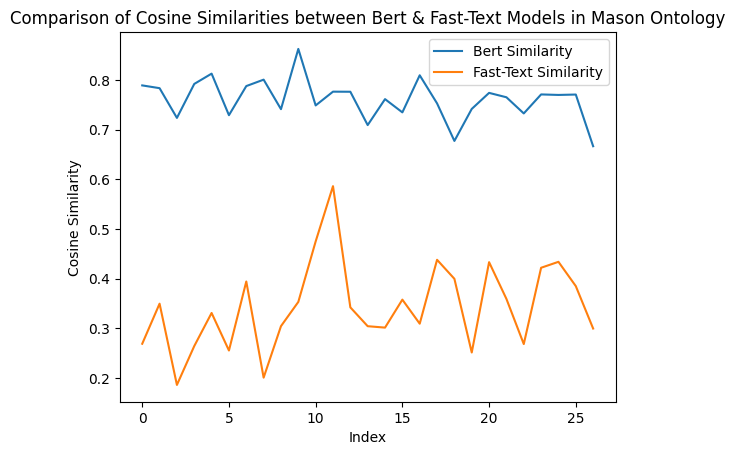

In [ ]:
# Plotting the results
x_mason = df_compare_mason.index.values
y1_mason = df_compare_mason['Cosine_Similarity_Bert']
y2_mason = df_compare_mason['Cosine_Similarity_Fast-Text']

plt.plot(x_mason, y1_mason, label='Bert Similarity')
plt.plot(x_mason, y2_mason, label='Fast-Text Similarity')
plt.xlabel('Index')
plt.ylabel('Cosine Similarity')
plt.title('Comparison of Cosine Similarities between Bert & Fast-Text Models in Mason Ontology')
plt.legend()
plt.show()

## Saref4inma

In [ ]:
# Check all the classes
for i in saref4inma.classes(): print(i)

core.FeatureOfInterest
saref4inma.Size
core.Property
saref4inma.ProductionEquipmentCategory
saref4inma.ProductionEquipment
saref4bldg.PhysicalObject
saref4inma.Item
saref4inma.ID
saref4inma.ItemBatch
saref4inma.Measurement
saref4inma.MaterialCategory
saref4inma.MaterialBatch
saref4inma.UUID
core.ConceptScheme
saref4inma.Factory
saref4bldg.Building
saref4inma.Area
saref4bldg.BuildingSpace
saref4inma.IRDI
saref4inma.Site
core.Device
core.State
saref4inma.ProductionEquipmentFunction
saref4inma.GTIN14ID
saref4inma.Batch
saref4inma.GTIN12ID
core.Function
saref4inma.ItemCategory
saref4inma.ActualMeasurement
saref4inma.ExpectedMeasurement
saref4inma.GTIN8ID
saref4inma.WorkCenter
core.Measurement
saref4inma.GTIN13ID


In [ ]:
# Creating a list with all the classes except 'core' & 'saref4bldg' classes
saref4inma_cls = list(saref4inma.classes())
saref4inma_cls = [elem for elem in saref4inma_cls if not str(elem).startswith('core') and not str(elem).startswith('saref4bldg')]

In [ ]:
# Get the list of classes with annotations
saref4inma_class = []

for cls in saref4inma_cls:
    annotations = cls.comment
    if annotations:
        saref4inma_class.append(cls.name)

saref4inma_class

['Size',
 'ProductionEquipmentCategory',
 'ProductionEquipment',
 'Item',
 'ID',
 'ItemBatch',
 'Measurement',
 'MaterialCategory',
 'MaterialBatch',
 'UUID',
 'Factory',
 'Area',
 'IRDI',
 'Site',
 'ProductionEquipmentFunction',
 'GTIN14ID',
 'Batch',
 'GTIN12ID',
 'ItemCategory',
 'ActualMeasurement',
 'ExpectedMeasurement',
 'GTIN8ID',
 'WorkCenter',
 'GTIN13ID']

In [ ]:
saref4inma.properties()
saref4inma_property = list(saref4inma.properties())

In [ ]:
saref4inma_annotations = []
for ann in saref4inma_cls:
    print(f"\t{ann}: {ann.comment}")
    saref4inma_annotations.append(str(ann.comment))

	saref4inma.Size: ['The amount of certain objects in a collection (e.g., size of a material batch).']
	saref4inma.ProductionEquipmentCategory: ['A ProductionEquipmentCategory represents a certain type of production equipment, which is generally static over time. More concretely, the ProductionEquipmentCategory represents a certain model and brand of a production equipment. Each ProductionEquipmentCategory can have multiple related ProductionEquipment, which represent the actual individual machines. Moreover, each ItemCategory can be produced by multiple ProductionEquipmentCategories.']
	saref4inma.ProductionEquipment: ['A production equipment is a specialization of a saref:Device and s4bldg:PhysicalObject that can produce items in a manufacturing process. This class represents an individual production equipment device and includes their specification in terms of functions, states and services. Different types of machines can be defined under this class as needed, for example, LaserCutt

In [ ]:
# Remove the full stop from each element
saref4inma_annotations = [x.replace('.', '') for x in saref4inma_annotations]

for i in range(len(saref4inma_annotations)):
    saref4inma_annotations[i] = saref4inma_annotations[i] + "."

saref4inma_annotations

["['The amount of certain objects in a collection (eg, size of a material batch)'].",
 "['A ProductionEquipmentCategory represents a certain type of production equipment, which is generally static over time More concretely, the ProductionEquipmentCategory represents a certain model and brand of a production equipment Each ProductionEquipmentCategory can have multiple related ProductionEquipment, which represent the actual individual machines Moreover, each ItemCategory can be produced by multiple ProductionEquipmentCategories'].",
 "['A production equipment is a specialization of a saref:Device and s4bldg:PhysicalObject that can produce items in a manufacturing process This class represents an individual production equipment device and includes their specification in terms of functions, states and services Different types of machines can be defined under this class as needed, for example, LaserCuttingMachine (ie, a type of production equipment to cut steel material), MillingMachine (ie

In [ ]:
saref4inma_ann = ', '.join(saref4inma_annotations)

# define a regular expression to match non-word characters except full stops
regex = re.compile('[%s]' % re.escape(string.punctuation.replace('.', '')))

# apply the regular expression to remove non-word characters
saref4inma_ann = regex.sub('', saref4inma_ann)

saref4inma_ann

'The amount of certain objects in a collection eg size of a material batch. A ProductionEquipmentCategory represents a certain type of production equipment which is generally static over time More concretely the ProductionEquipmentCategory represents a certain model and brand of a production equipment Each ProductionEquipmentCategory can have multiple related ProductionEquipment which represent the actual individual machines Moreover each ItemCategory can be produced by multiple ProductionEquipmentCategories. A production equipment is a specialization of a sarefDevice and s4bldgPhysicalObject that can produce items in a manufacturing process This class represents an individual production equipment device and includes their specification in terms of functions states and services Different types of machines can be defined under this class as needed for example LaserCuttingMachine ie a type of production equipment to cut steel material MillingMachine ie to drill holes in steel material Mo

In [ ]:
sentences_saref4inma = saref4inma_ann.split('. ')
valid_sentences_saref4inma = [s.strip() for s in sentences_saref4inma]

In [ ]:
# Define a translation table to remove punctuations, symbols, and hyphens
translator_saref4inma = str.maketrans("", "", string.punctuation + "’‘“”")

# Remove punctuations, symbols, and hyphens from each element of the list
valid_sentences_saref4inma = [s.translate(translator_saref4inma).strip() for s in valid_sentences_saref4inma]

#Removing unnecessary punctuations from the text
valid_sentences_saref4inma = [n.replace('\n', '') for n in valid_sentences_saref4inma]
valid_sentences_saref4inma = [n.replace('\t', '') for n in valid_sentences_saref4inma]
valid_sentences_saref4inma = [n.replace('–', '') for n in valid_sentences_saref4inma]

valid_sentences_saref4inma = [item for item in valid_sentences_saref4inma if item != ' ' and item != '']

valid_sentences_saref4inma

['The amount of certain objects in a collection eg size of a material batch',
 'A ProductionEquipmentCategory represents a certain type of production equipment which is generally static over time More concretely the ProductionEquipmentCategory represents a certain model and brand of a production equipment Each ProductionEquipmentCategory can have multiple related ProductionEquipment which represent the actual individual machines Moreover each ItemCategory can be produced by multiple ProductionEquipmentCategories',
 'A production equipment is a specialization of a sarefDevice and s4bldgPhysicalObject that can produce items in a manufacturing process This class represents an individual production equipment device and includes their specification in terms of functions states and services Different types of machines can be defined under this class as needed for example LaserCuttingMachine ie a type of production equipment to cut steel material MillingMachine ie to drill holes in steel mate

In [ ]:
# Chexking for duplicates
unique_items = set(valid_sentences_saref4inma)
duplicates = [item for item in unique_items if valid_sentences_saref4inma.count(item) > 1]
duplicates

[]

In [ ]:
len(valid_sentences_saref4inma)

24

### Bert Model

In [ ]:
# Load pre-trained model and tokenizer
model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# define the get_embedding function
def get_embedding(text, model, tokenizer):
    input_ids = tokenizer.encode(text, add_special_tokens=True)
    input_ids = torch.tensor(input_ids).unsqueeze(0)
    with torch.no_grad():
        outputs = model(input_ids)
        last_hidden_states = outputs[0].squeeze(0)
        mean_last_hidden_states = torch.mean(last_hidden_states, dim=0)
    return mean_last_hidden_states.numpy()

In [ ]:
# Create empty lists for embeddings
bert_embeddings = []
bert_embeddings_saref4inma = []

# Loop over sentences and calculate embeddings
for sent1 in valid_sentences:
    embedding1 = get_embedding(sent1, model, tokenizer)
    bert_embeddings.append(embedding1)
    for sent2 in valid_sentences_saref4inma:
        embedding2 = get_embedding(sent2, model, tokenizer)
        bert_embeddings_saref4inma.append(embedding2)

# Create dataframe
data_saref4inma = {
    "Input_Sentence": [],
    "Annotation": [],
    "Input_Sentence_Embedding": [],
    "Annotation_Embedding": [],
}

for sent1, emb1 in zip(valid_sentences, bert_embeddings):
    for sent2, emb2 in zip(valid_sentences_saref4inma, bert_embeddings_saref4inma):
        data_saref4inma["Input_Sentence"].append(sent1)
        data_saref4inma["Annotation"].append(sent2)
        data_saref4inma["Input_Sentence_Embedding"].append(emb1)
        data_saref4inma["Annotation_Embedding"].append(emb2)

df_saref4inma = pd.DataFrame(data_saref4inma)

In [ ]:
df_saref4inma.head(4)

,Input_Sentence,Annotation,Input_Sentence_Embedding,Annotation_Embedding
0,A manufacturing resource is a physical machine...,The amount of certain objects in a collection ...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[-0.21843597, -0.14227748, 0.02036629, 0.21665..."
1,A manufacturing resource is a physical machine...,A ProductionEquipmentCategory represents a cer...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[-0.06332121, 0.09033442, 0.38775018, 0.174234..."
2,A manufacturing resource is a physical machine...,A production equipment is a specialization of ...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[0.12615114, 0.28940982, 0.3792716, 0.1279278,..."
3,A manufacturing resource is a physical machine...,A tangible object which can be unique identifi...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[-0.24365495, 0.093746476, 0.4011754, 0.014980..."


In [ ]:
# Adding class to the dataframe
rep_class = []
for i in range(len(valid_sentences)):
    rep_class += saref4inma_class

df_saref4inma['Class'] = rep_class[:len(df_saref4inma)]

In [ ]:
# Define a lambda function to calculate the cosine similarity between embeddings
cosine_sim = lambda x: cosine_similarity([x['Input_Sentence_Embedding']], [x['Annotation_Embedding']])[0][0]

# Apply the lambda function to create a new column of cosine similarities
df_saref4inma['Cosine_Similarity'] = df_saref4inma.apply(cosine_sim, axis=1)

In [ ]:
df_saref4inma.head(10)

,Input_Sentence,Annotation,Input_Sentence_Embedding,Annotation_Embedding,Class,Cosine_Similarity
0,A manufacturing resource is a physical machine...,The amount of certain objects in a collection ...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[-0.21843597, -0.14227748, 0.02036629, 0.21665...",Size,0.692491
1,A manufacturing resource is a physical machine...,A ProductionEquipmentCategory represents a cer...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[-0.06332121, 0.09033442, 0.38775018, 0.174234...",ProductionEquipmentCategory,0.733273
2,A manufacturing resource is a physical machine...,A production equipment is a specialization of ...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[0.12615114, 0.28940982, 0.3792716, 0.1279278,...",ProductionEquipment,0.780159
3,A manufacturing resource is a physical machine...,A tangible object which can be unique identifi...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[-0.24365495, 0.093746476, 0.4011754, 0.014980...",Item,0.717970
4,A manufacturing resource is a physical machine...,A unique identifier,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[0.17504552, -0.06066806, 0.021172592, 0.18421...",ID,0.590987
5,A manufacturing resource is a physical machine...,A uniform collection of tangible objects which...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[-0.2114782, 0.10666337, 0.30490622, 0.0245808...",ItemBatch,0.739055
6,A manufacturing resource is a physical machine...,A subclass of sarefMeasurement that represents...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[-0.25057226, -0.10997394, 0.39210266, 0.01202...",Measurement,0.739266
7,A manufacturing resource is a physical machine...,A MaterialCategory describes a category of mat...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[-0.20076868, 0.12516361, 0.23466673, 0.060531...",MaterialCategory,0.757550
8,A manufacturing resource is a physical machine...,A uniform collection of tangible raw material ...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[-0.19081749, 0.057355613, 0.2713745, 0.020996...",MaterialBatch,0.759063
9,A manufacturing resource is a physical machine...,A universally unique identifier UUID is a 128b...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[-0.2345737, 0.24122594, 0.29978195, -0.113419...",UUID,0.668118


In [ ]:
# group the dataframe by the sentences in the original paragraph and find the maximum cosine similarity score for each group
max_similarities_saref4inma = df_saref4inma.groupby('Input_Sentence')['Cosine_Similarity'].max().reset_index()

# merge the original dataframe with the maximum cosine similarity scores
df_cosine_similarity_saref4inma = pd.merge(df_saref4inma, max_similarities_saref4inma, on=['Input_Sentence', 'Cosine_Similarity'], how='inner')

# Remove duplicates based on column 'Cosine_Similarity'
df_cosine_similarity_saref4inma.drop_duplicates(subset=['Cosine_Similarity'], keep='first', inplace=True)

# Reset the index of the resulting dataframe
df_cosine_similarity_saref4inma.reset_index(drop=True, inplace=True)

df_cosine_similarity_saref4inma.head(5)

,Input_Sentence,Annotation,Input_Sentence_Embedding,Annotation_Embedding,Class,Cosine_Similarity
0,A manufacturing resource is a physical machine...,A production equipment is a specialization of ...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[0.12615114, 0.28940982, 0.3792716, 0.1279278,...",ProductionEquipment,0.780159
1,The manufacturing resource class has two subcl...,A subclass of s4inmaProductionEquipment and th...,"[-0.028008692, 0.116112635, -0.18360376, 0.256...","[-0.17071989, 0.042967632, 0.19529572, 0.10464...",WorkCenter,0.738567
2,Labor skill represents labor rate and skill de...,The amount of certain objects in a collection ...,"[0.20286956, 0.035978027, 0.10824008, 0.278719...","[-0.21843597, -0.14227748, 0.02036629, 0.21665...",Size,0.678892
3,The manufacturing equipment subclass represent...,A uniform collection of tangible objects or Lo...,"[0.1603254, 0.27694675, -0.109380245, -0.03558...","[-0.1448708, 0.020934286, 0.22783314, -0.07744...",Batch,0.811549
4,There are four subclasses machine die mold and...,A production equipment is a specialization of ...,"[0.2069281, 0.020959228, 0.027157933, 0.191676...","[0.12615114, 0.28940982, 0.3792716, 0.1279278,...",ProductionEquipment,0.799161


In [ ]:
# Create a new dataframe for hash codes
df_cosine_similarity_hc_saref4inma = df_cosine_similarity_saref4inma.copy()

# Removing the Embedding columns
del df_cosine_similarity_hc_saref4inma['Input_Sentence_Embedding']
del df_cosine_similarity_hc_saref4inma['Annotation_Embedding']

In [ ]:
# create a new column with the hash code of the Input Sentence column
df_cosine_similarity_hc_saref4inma['Hash_Code'] = df_cosine_similarity_hc_saref4inma['Input_Sentence'].apply(lambda x: hashlib.sha256(x.encode()).hexdigest())

df_cosine_similarity_hc_saref4inma.head(3)

,Input_Sentence,Annotation,Class,Cosine_Similarity,Hash_Code
0,A manufacturing resource is a physical machine...,A production equipment is a specialization of ...,ProductionEquipment,0.780159,32ce332c8db7e015d8f4be1d8adf730888812a83526a5d...
1,The manufacturing resource class has two subcl...,A subclass of s4inmaProductionEquipment and th...,WorkCenter,0.738567,9c764de3b6606c80e0b96b3b99eac613cd37e7ef47da04...
2,Labor skill represents labor rate and skill de...,The amount of certain objects in a collection ...,Size,0.678892,79929088b6861a90d19a369055b994bdd1ff47209181d1...


### Populating the Hash-Code within the ontology

In [ ]:
# Iterate through each row of the dataframe
for index, row in df_cosine_similarity_hc_saref4inma.iterrows():
    # Get the hash code and the class from the current row
    hash_code = row['Hash_Code']
    class_name = row['Class']
    # Iterate through the classes in the ontology
    for cls in class_name:
        # Get the namespace of the ontology
        ns = saref4inma.get_namespace(base_iri=saref4inma.base_iri)
        # Get the class from the namespace
        cls = getattr(ns, class_name, None)
        # Check if the class was found in the ontology
        if cls is not None and isinstance(cls, ThingClass):
            # Create a new instance of the class with the hash code as the name
            instance = cls(hash_code)
        else:
            print(f"Class {class_name} not found in ontology")
        break  # exit the inner loop since we've found the matching class

# Save the ontology
saref4inma.save("saref4inma.rdf")

In [ ]:
for i in saref4inma.ProductionEquipment.instances(): print(i)

saref4inma.32ce332c8db7e015d8f4be1d8adf730888812a83526a5db175bd2cec718738a0
saref4inma.0fe56c9325afe340cfbc8f6a49968cc22bba88b3da6ca114a1f3d9ccf379cfcb
saref4inma.b0fca6c1d4d57cac1b3e0f1ac3819383fc3d7d52bdfab2049d5686f25caa020e
saref4inma.fb46813c00b2437846fe5303ed51dc66d563fb5ad5ed12435532835dd42f7522
saref4inma.f8f9ecc735793273ac7f0dcd99180b6bbe328191e24285e676f749015a203089
saref4inma.9c764de3b6606c80e0b96b3b99eac613cd37e7ef47da04132dab83a0a513134f


In [ ]:
# Print the individuals
for individual in saref4inma.individuals():
    print(individual)

saref4inma.32ce332c8db7e015d8f4be1d8adf730888812a83526a5db175bd2cec718738a0
saref4inma.9c764de3b6606c80e0b96b3b99eac613cd37e7ef47da04132dab83a0a513134f
saref4inma.79929088b6861a90d19a369055b994bdd1ff47209181d1bc636ee26d4ef4a54f
saref4inma.b472876c139a04babc571ed44a0708c2caccf886a6b8b41be423265e1f252225
saref4inma.0fe56c9325afe340cfbc8f6a49968cc22bba88b3da6ca114a1f3d9ccf379cfcb
saref4inma.e810b73299e463129471c037c05772a1172d43f85804b0fa99e08055291be813
saref4inma.8daea0b33ed7ad1beedbbe33c5135c11a7e6c0f3397819e8a35d263354eb2609
saref4inma.b0fca6c1d4d57cac1b3e0f1ac3819383fc3d7d52bdfab2049d5686f25caa020e
saref4inma.ad441f9006f94981fcc898d510443b95ce47128a7b25e8f64cca32df91381aa5
saref4inma.fb46813c00b2437846fe5303ed51dc66d563fb5ad5ed12435532835dd42f7522
saref4inma.0b25ba6cda2e3dd4bc4594000ff22b792e6c36c0e7227b3af5cc2a8c2dbcc452
saref4inma.f8f9ecc735793273ac7f0dcd99180b6bbe328191e24285e676f749015a203089
saref4inma.cd5f473fdc2c1862f11f70a75217febaaa8a25d14d5f58cc106a87e604cebf58
saref4inma.e

In [ ]:
# Get a generator object for all individuals in the ontology
individuals = saref4inma.individuals()

# Loop over the generator and print the URI of each individual
for individual in individuals:
    individual_uri = individual.iri
    print("Individual URI:", individual_uri)

Individual URI: https://saref.etsi.org/saref4inma/32ce332c8db7e015d8f4be1d8adf730888812a83526a5db175bd2cec718738a0
Individual URI: https://saref.etsi.org/saref4inma/9c764de3b6606c80e0b96b3b99eac613cd37e7ef47da04132dab83a0a513134f
Individual URI: https://saref.etsi.org/saref4inma/79929088b6861a90d19a369055b994bdd1ff47209181d1bc636ee26d4ef4a54f
Individual URI: https://saref.etsi.org/saref4inma/b472876c139a04babc571ed44a0708c2caccf886a6b8b41be423265e1f252225
Individual URI: https://saref.etsi.org/saref4inma/0fe56c9325afe340cfbc8f6a49968cc22bba88b3da6ca114a1f3d9ccf379cfcb
Individual URI: https://saref.etsi.org/saref4inma/e810b73299e463129471c037c05772a1172d43f85804b0fa99e08055291be813
Individual URI: https://saref.etsi.org/saref4inma/8daea0b33ed7ad1beedbbe33c5135c11a7e6c0f3397819e8a35d263354eb2609
Individual URI: https://saref.etsi.org/saref4inma/b0fca6c1d4d57cac1b3e0f1ac3819383fc3d7d52bdfab2049d5686f25caa020e
Individual URI: https://saref.etsi.org/saref4inma/ad441f9006f94981fcc898d510443b

In [ ]:
# Iterate over all individuals in the ontology
for individual in saref4inma.individuals():
    print("Individual:", individual.iri)
    # Get the list of classes that the individual is a direct instance of
    classes = individual.is_a
    # Print the classes
    for cls in classes:
        print("Class:", cls.iri)

Individual: https://saref.etsi.org/saref4inma/32ce332c8db7e015d8f4be1d8adf730888812a83526a5db175bd2cec718738a0
Class: https://saref.etsi.org/saref4inma/ProductionEquipment
Individual: https://saref.etsi.org/saref4inma/9c764de3b6606c80e0b96b3b99eac613cd37e7ef47da04132dab83a0a513134f
Class: https://saref.etsi.org/saref4inma/WorkCenter
Individual: https://saref.etsi.org/saref4inma/79929088b6861a90d19a369055b994bdd1ff47209181d1bc636ee26d4ef4a54f
Class: https://saref.etsi.org/saref4inma/Size
Individual: https://saref.etsi.org/saref4inma/b472876c139a04babc571ed44a0708c2caccf886a6b8b41be423265e1f252225
Class: https://saref.etsi.org/saref4inma/Batch
Individual: https://saref.etsi.org/saref4inma/0fe56c9325afe340cfbc8f6a49968cc22bba88b3da6ca114a1f3d9ccf379cfcb
Class: https://saref.etsi.org/saref4inma/ProductionEquipment
Individual: https://saref.etsi.org/saref4inma/e810b73299e463129471c037c05772a1172d43f85804b0fa99e08055291be813
Class: https://saref.etsi.org/saref4inma/ProductionEquipmentFunctio

### Fast-Text

In [ ]:
# Convert the sentences to lowercase
lowercase_sentences = [sentence.lower() for sentence in valid_sentences]
lowercase_sentences_saref4inma = [sentence.lower() for sentence in valid_sentences_saref4inma]

# create a dictionary to map the original sentences with the converted lowercase sentences for further use
dict_saref4inma = {}
dict_ann_saref4inma = {}

# loop over the lists and add the elements as key-value pairs in the dictionary
for i in range(len(lowercase_sentences)):
    dict_saref4inma[lowercase_sentences[i]] = valid_sentences[i]

for i in range(len(lowercase_sentences_saref4inma)):
    dict_ann_saref4inma[lowercase_sentences_saref4inma[i]] = valid_sentences_saref4inma[i]

In [ ]:
# Split the sentences into words
lowercase_words = []
for sentence in lowercase_sentences:
    lowercase_words.extend(sentence.split())

lowercase_words_saref4inma = []
for sentence in lowercase_sentences_saref4inma:
    lowercase_words_saref4inma.extend(sentence.split())

# Write the input sentences to a text file
with open('ft_sentences_saref4inma.txt', 'w') as f:
    for s1 in lowercase_words:
        f.write(s1 + '\n')

# Write the annotations to a text file
with open('ft_sentences_ann_saref4inma.txt', 'w') as f:
    for s2 in lowercase_words_saref4inma:
        f.write(s2 + '\n')

# Create dataframe with every combination of sentences
combos = list(itertools.product(lowercase_sentences, lowercase_sentences_saref4inma))
df_saref4inma_ft = pd.DataFrame(combos, columns=["Input_Sentence", "Annotation"])

In [ ]:
# Train the FastText model
ft_model_saref4inma = fasttext.train_unsupervised('ft_sentences_saref4inma.txt', model='skipgram', dim=100)
ft_model_ann_saref4inma = fasttext.train_unsupervised('ft_sentences_ann_saref4inma.txt', model='skipgram', dim=100)

In [ ]:
# Function to create embeddings for the sentences
def create_embedding_saref4inma(sentence):
    return ft_model_saref4inma.get_sentence_vector(sentence)

def create_embedding_ann_saref4inma(sentence):
    return ft_model_ann_saref4inma.get_sentence_vector(sentence)

In [ ]:
# Apply function to each row of the DataFrame
df_saref4inma_ft['Input_Sentence_Embedding'] = df_saref4inma_ft['Input_Sentence'].apply(create_embedding_saref4inma)
df_saref4inma_ft['Annotation_Embedding'] = df_saref4inma_ft['Annotation'].apply(create_embedding_ann_saref4inma)

In [ ]:
df_saref4inma_ft.head(10)

,Input_Sentence,Annotation,Input_Sentence_Embedding,Annotation_Embedding
0,a manufacturing resource is a physical machine...,the amount of certain objects in a collection ...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.003629953, 0.010450015, 0.010756201, -0.018..."
1,a manufacturing resource is a physical machine...,a productionequipmentcategory represents a cer...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[1.738363e-06, -0.0028675387, 0.013121782, -0...."
2,a manufacturing resource is a physical machine...,a production equipment is a specialization of ...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.0056958096, 0.01051416, 0.030545536, 0.0033..."
3,a manufacturing resource is a physical machine...,a tangible object which can be unique identifi...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.039815936, -0.01460647, -0.009456679, 0.001..."
4,a manufacturing resource is a physical machine...,a unique identifier,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.06032165, 0.022548033, 0.08106296, -0.11065..."
5,a manufacturing resource is a physical machine...,a uniform collection of tangible objects which...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.031012816, 0.016706213, 0.010748754, 0.0061..."
6,a manufacturing resource is a physical machine...,a subclass of sarefmeasurement that represents...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.02084395, 0.0045732204, 0.008821874, 0.0149..."
7,a manufacturing resource is a physical machine...,a materialcategory describes a category of mat...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.038820338, 0.021575093, 0.0075364355, 0.010..."
8,a manufacturing resource is a physical machine...,a uniform collection of tangible raw material ...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.033447225, 0.014481905, 0.018092362, 0.0070..."
9,a manufacturing resource is a physical machine...,a universally unique identifier uuid is a 128b...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.0029517435, 0.008709424, 0.018203583, 0.007..."


In [ ]:
# Adding class to the dataframe
rep_class_ft = []
for i in range(len(lowercase_sentences)):
    rep_class_ft += saref4inma_class

df_saref4inma_ft['Class'] = rep_class_ft[:len(df_saref4inma_ft)]

In [ ]:
# Define a lambda function to calculate the cosine similarity between embeddings
cosine_sim = lambda x: cosine_similarity([x['Input_Sentence_Embedding']], [x['Annotation_Embedding']])[0][0]

# Apply the lambda function to create a new column of cosine similarities
df_saref4inma_ft['Cosine_Similarity'] = df_saref4inma_ft.apply(cosine_sim, axis=1)

In [ ]:
df_saref4inma_ft.head(10)

,Input_Sentence,Annotation,Input_Sentence_Embedding,Annotation_Embedding,Class,Cosine_Similarity
0,a manufacturing resource is a physical machine...,the amount of certain objects in a collection ...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.003629953, 0.010450015, 0.010756201, -0.018...",Size,0.149828
1,a manufacturing resource is a physical machine...,a productionequipmentcategory represents a cer...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[1.738363e-06, -0.0028675387, 0.013121782, -0....",ProductionEquipmentCategory,0.093732
2,a manufacturing resource is a physical machine...,a production equipment is a specialization of ...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.0056958096, 0.01051416, 0.030545536, 0.0033...",ProductionEquipment,-0.007648
3,a manufacturing resource is a physical machine...,a tangible object which can be unique identifi...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.039815936, -0.01460647, -0.009456679, 0.001...",Item,0.206759
4,a manufacturing resource is a physical machine...,a unique identifier,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.06032165, 0.022548033, 0.08106296, -0.11065...",ID,0.122127
5,a manufacturing resource is a physical machine...,a uniform collection of tangible objects which...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.031012816, 0.016706213, 0.010748754, 0.0061...",ItemBatch,0.215496
6,a manufacturing resource is a physical machine...,a subclass of sarefmeasurement that represents...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.02084395, 0.0045732204, 0.008821874, 0.0149...",Measurement,0.341008
7,a manufacturing resource is a physical machine...,a materialcategory describes a category of mat...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.038820338, 0.021575093, 0.0075364355, 0.010...",MaterialCategory,0.131401
8,a manufacturing resource is a physical machine...,a uniform collection of tangible raw material ...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.033447225, 0.014481905, 0.018092362, 0.0070...",MaterialBatch,0.169727
9,a manufacturing resource is a physical machine...,a universally unique identifier uuid is a 128b...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.0029517435, 0.008709424, 0.018203583, 0.007...",UUID,0.100214


In [ ]:
# group the dataframe by the sentences in the original paragraph and find the maximum cosine similarity score for each group
max_similarities_ft_saref4inma = df_saref4inma_ft.groupby('Input_Sentence')['Cosine_Similarity'].max().reset_index()

# merge the original dataframe with the maximum cosine similarity scores
df_cosine_similarity_ft_saref4inma = pd.merge(df_saref4inma_ft, max_similarities_ft_saref4inma, on=['Input_Sentence', 'Cosine_Similarity'], how='inner')

# Remove duplicates based on column 'Cosine_Similarity'
df_cosine_similarity_ft_saref4inma.drop_duplicates(subset=['Cosine_Similarity'], keep='first', inplace=True)

# Reset the index of the resulting dataframe
df_cosine_similarity_ft_saref4inma.reset_index(drop=True, inplace=True)

df_cosine_similarity_ft_saref4inma.head(20)

,Input_Sentence,Annotation,Input_Sentence_Embedding,Annotation_Embedding,Class,Cosine_Similarity
0,a manufacturing resource is a physical machine...,a subclass of sarefmeasurement that represents...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.02084395, 0.0045732204, 0.008821874, 0.0149...",Measurement,0.341008
1,the manufacturing resource class has two subcl...,a uniform collection of tangible objects which...,"[0.0893878, 0.0019307006, 0.0401662, 0.0379929...","[0.031012816, 0.016706213, 0.010748754, 0.0061...",ItemBatch,0.294192
2,labor skill represents labor rate and skill de...,an itemcategory describes a single type of ite...,"[0.046736687, -0.01577708, 0.008850802, 0.0020...","[0.0222424, 0.006277669, -0.021281324, 0.00205...",ItemCategory,0.071192
3,the manufacturing equipment subclass represent...,a subclass of sarefmeasurement that represents...,"[0.084363826, 0.03799975, -0.019190976, -0.015...","[0.02084395, 0.0045732204, 0.008821874, 0.0149...",Measurement,0.456599
4,there are four subclasses machine die mold and...,the amount of certain objects in a collection ...,"[0.01983861, -0.017472751, 0.037692044, -0.041...","[0.003629953, 0.010450015, 0.010756201, -0.018...",Size,0.140214
5,if necessary other equipment classes may be ad...,a subclass of s4bldgbuilding specialized for t...,"[0.060407255, 0.010101532, -0.023370566, 0.011...","[0.030590149, 0.012882946, 0.002181322, -0.001...",Factory,0.392582
6,a piece of equipment has a set of parameters t...,a subclass of sarefmeasurement that represents...,"[0.030016705, -0.00068290014, -0.03147005, 0.0...","[0.02084395, 0.0045732204, 0.008821874, 0.0149...",Measurement,0.441565
7,a machine can be a machining centre casting ma...,a subclass of sarefmeasurement that represents...,"[0.011380323, 0.014811401, -0.040216766, -0.01...","[0.02084395, 0.0045732204, 0.008821874, 0.0149...",Measurement,0.320330
8,a machine has a set of parameters such as dime...,an itemcategory describes a single type of ite...,"[0.021427501, -0.005249445, 0.033188514, -0.03...","[0.0222424, 0.006277669, -0.021281324, 0.00205...",ItemCategory,0.341082
9,a tool represents a tool used in the machining...,a subclass of sarefmeasurement that represents...,"[0.029928327, 0.012151852, -0.0065322244, -0.0...","[0.02084395, 0.0045732204, 0.008821874, 0.0149...",Measurement,0.377286


In [ ]:
# Removing the Embedding columns
del df_cosine_similarity_ft_saref4inma['Input_Sentence_Embedding']
del df_cosine_similarity_ft_saref4inma['Annotation_Embedding']

### Comparing Bert vs Fast-Text Models

In [ ]:
# switch every row of the 'Input_Sentence' & 'Annotation' columns of the Fast-Text dataframe to the dictionary values for comparison
df_cosine_similarity_ft_saref4inma['Input_Sentence'] = df_cosine_similarity_ft_saref4inma['Input_Sentence'].map(dict_saref4inma)
df_cosine_similarity_ft_saref4inma['Annotation'] = df_cosine_similarity_ft_saref4inma['Annotation'].map(dict_ann_saref4inma)

# Creating new dataframe for comparison
df_compare_saref4inma = pd.merge(df_cosine_similarity_hc_saref4inma, df_cosine_similarity_ft_saref4inma, how = 'left', on = 'Input_Sentence')

# Renaming the columns
df_compare_saref4inma.rename(columns={'Annotation_x': 'Annotation_Bert', 'Annotation_y': 'Annotation_Fast-Text', 'Class_x': 'Class_Bert',
                                 'Class_y': 'Class_Fast-Text', 'Cosine_Similarity_x': 'Cosine_Similarity_Bert', 'Cosine_Similarity_y': 'Cosine_Similarity_Fast-Text'}, inplace=True)

# Removing unused columns
del df_compare_saref4inma['Hash_Code']

# Changing the positons of the columns
df_compare_saref4inma = df_compare_saref4inma.reindex(columns=['Input_Sentence', 'Annotation_Bert', 'Annotation_Fast-Text', 'Class_Bert', 'Class_Fast-Text', 'Cosine_Similarity_Bert', 'Cosine_Similarity_Fast-Text'])

df_compare_saref4inma.head(15)

,Input_Sentence,Annotation_Bert,Annotation_Fast-Text,Class_Bert,Class_Fast-Text,Cosine_Similarity_Bert,Cosine_Similarity_Fast-Text
0,A manufacturing resource is a physical machine...,A production equipment is a specialization of ...,A subclass of sarefMeasurement that represents...,ProductionEquipment,Measurement,0.780159,0.341008
1,The manufacturing resource class has two subcl...,A subclass of s4inmaProductionEquipment and th...,A uniform collection of tangible objects which...,WorkCenter,ItemBatch,0.738567,0.294192
2,Labor skill represents labor rate and skill de...,The amount of certain objects in a collection ...,An ItemCategory describes a single type of ite...,Size,ItemCategory,0.678892,0.071192
3,The manufacturing equipment subclass represent...,A uniform collection of tangible objects or Lo...,A subclass of sarefMeasurement that represents...,Batch,Measurement,0.811549,0.456599
4,There are four subclasses machine die mold and...,A production equipment is a specialization of ...,The amount of certain objects in a collection ...,ProductionEquipment,Size,0.799161,0.140214
5,If necessary other equipment classes may be ad...,Functionallity neccessary to accomplish the ta...,A subclass of s4bldgBuilding specialized for t...,ProductionEquipmentFunction,Factory,0.748077,0.392582
6,A piece of equipment has a set of parameters t...,A uniform collection of tangible objects or Lo...,A subclass of sarefMeasurement that represents...,Batch,Measurement,0.771356,0.441565
7,A machine can be a machining centre casting ma...,A production equipment is a specialization of ...,A subclass of sarefMeasurement that represents...,ProductionEquipment,Measurement,0.796183,0.320330
8,A machine has a set of parameters such as dime...,Functionallity neccessary to accomplish the ta...,An ItemCategory describes a single type of ite...,ProductionEquipmentFunction,ItemCategory,0.767804,0.341082
9,A tool represents a tool used in the machining...,A production equipment is a specialization of ...,A subclass of sarefMeasurement that represents...,ProductionEquipment,Measurement,0.845138,0.377286


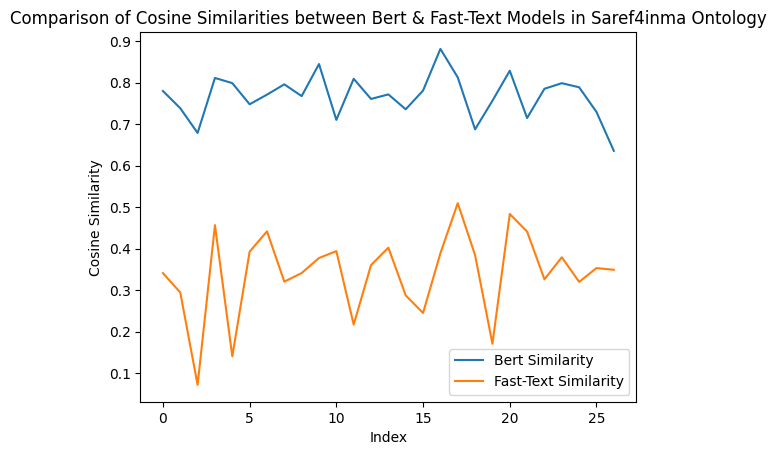

In [ ]:
# Plotting the results
x_saref4inma = df_compare_saref4inma.index.values
y1_saref4inma = df_compare_saref4inma['Cosine_Similarity_Bert']
y2_saref4inma = df_compare_saref4inma['Cosine_Similarity_Fast-Text']

plt.plot(x_saref4inma, y1_saref4inma, label='Bert Similarity')
plt.plot(x_saref4inma, y2_saref4inma, label='Fast-Text Similarity')
plt.xlabel('Index')
plt.ylabel('Cosine Similarity')
plt.title('Comparison of Cosine Similarities between Bert & Fast-Text Models in Saref4inma Ontology')
plt.legend()
plt.show()

## MSDL

In [ ]:
# Get the list of classes with annotations
msdl_class = []

for cls in msdl.classes():
    annotations = cls.comment
    if annotations:
        msdl_class.append(cls.name)

msdl_class

['Service',
 'SupportingService',
 'SupportingSystem',
 'CADModeling',
 'CMMS',
 'Capability',
 'DesignService',
 'MachiningCapability',
 'MaterialHandlingSystem',
 'MfgService',
 'Packaging',
 'QCSystem',
 'Shipping',
 'SoftwareSolution',
 'UseService',
 'WasteManagementService']

In [ ]:
msdl.classes()
msdl_cls = list(msdl.classes())

In [ ]:
msdl.properties()
msdl_property = list(msdl.properties())

In [ ]:
msdl_annotations = []
for ann in msdl_cls:
    print(f"\t{ann}: {ann.comment}")
    msdl_annotations.append(str(ann.comment))

	MSDL.Service: ['Service conceptualize all product-related operations. Services have Operations which use Resources.']
	MSDL.SupportingService: ['Contain services which are related to basic services and support them']
	MSDL.SupportingSystem: ['Systems which support services']
	MSDL.SurfaceFinish: []
	MSDL.StockSize: []
	MSDL.Tolerance: []
	MSDL.StockMaterial: []
	MSDL.StockWeight: []
	MSDL.CADModeling: ['Supporting service related to CAD modelling']
	MSDL.CMMS: ['Computerized maintenance management system']
	MSDL.Capability: ['Represent the capability of a service. It describes the capability in stock size, shape, weight or material from a specific service']
	MSDL.DesignService: ['Services related to product design']
	MSDL.MachiningCapability: ['The machining capability of a manufacturing service.']
	MSDL.MaterialHandlingSystem: ['A supporting system for material handling']
	MSDL.MfgService: ['Services related to manufacturing operations']
	MSDL.Packaging: ['Packaging supporting servic

In [ ]:
# Remove the full stop from each element
msdl_annotations = [x.replace('.', '') for x in msdl_annotations]

for i in range(len(msdl_annotations)):
    msdl_annotations[i] = msdl_annotations[i] + "."

msdl_annotations

["['Service conceptualize all product-related operations Services have Operations which use Resources'].",
 "['Contain services which are related to basic services and support them'].",
 "['Systems which support services'].",
 '[].',
 '[].',
 '[].',
 '[].',
 '[].',
 "['Supporting service related to CAD modelling'].",
 "['Computerized maintenance management system'].",
 "['Represent the capability of a service It describes the capability in stock size, shape, weight or material from a specific service'].",
 "['Services related to product design'].",
 "['The machining capability of a manufacturing service'].",
 "['A supporting system for material handling'].",
 "['Services related to manufacturing operations'].",
 "['Packaging supporting service'].",
 "['Quality control system'].",
 "['Supporting service related to shipping processes'].",
 "['Services or products related to software solutions for a Business Entity in a Manufacturing Collaborative Ecosystem'].",
 '[].',
 "['Services relat

In [ ]:
msdl_ann = ', '.join(msdl_annotations)

# define a regular expression to match non-word characters except full stops
regex = re.compile('[%s]' % re.escape(string.punctuation.replace('.', '')))

# apply the regular expression to remove non-word characters
msdl_ann = regex.sub('', msdl_ann)

msdl_ann

'Service conceptualize all productrelated operations Services have Operations which use Resources. Contain services which are related to basic services and support them. Systems which support services. . . . . . Supporting service related to CAD modelling. Computerized maintenance management system. Represent the capability of a service It describes the capability in stock size shape weight or material from a specific service. Services related to product design. The machining capability of a manufacturing service. A supporting system for material handling. Services related to manufacturing operations. Packaging supporting service. Quality control system. Supporting service related to shipping processes. Services or products related to software solutions for a Business Entity in a Manufacturing Collaborative Ecosystem. . Services related to repairing processes. Services related to waste management eg recycling.'

In [ ]:
sentences_msdl = msdl_ann.split('. ')
valid_sentences_msdl = [s.strip() for s in sentences_msdl]

In [ ]:
# Define a translation table to remove punctuations, symbols, and hyphens
translator_msdl = str.maketrans("", "", string.punctuation + "’‘“”")

# Remove punctuations, symbols, and hyphens from each element of the list
valid_sentences_msdl = [s.translate(translator_msdl).strip() for s in valid_sentences_msdl]

#Removing unnecessary punctuations from the text
valid_sentences_msdl = [n.replace('\n', '') for n in valid_sentences_msdl]
valid_sentences_msdl = [n.replace('\t', '') for n in valid_sentences_msdl]
valid_sentences_msdl = [n.replace('–', '') for n in valid_sentences_msdl]

valid_sentences_msdl = [item for item in valid_sentences_msdl if item != ' ' and item != '']

valid_sentences_msdl

['Service conceptualize all productrelated operations Services have Operations which use Resources',
 'Contain services which are related to basic services and support them',
 'Systems which support services',
 'Supporting service related to CAD modelling',
 'Computerized maintenance management system',
 'Represent the capability of a service It describes the capability in stock size shape weight or material from a specific service',
 'Services related to product design',
 'The machining capability of a manufacturing service',
 'A supporting system for material handling',
 'Services related to manufacturing operations',
 'Packaging supporting service',
 'Quality control system',
 'Supporting service related to shipping processes',
 'Services or products related to software solutions for a Business Entity in a Manufacturing Collaborative Ecosystem',
 'Services related to repairing processes',
 'Services related to waste management eg recycling']

In [ ]:
# Chexking for duplicates
unique_items = set(valid_sentences_msdl)
duplicates = [item for item in unique_items if valid_sentences_msdl.count(item) > 1]
duplicates

[]

In [ ]:
len(valid_sentences_msdl)

16

### Bert Model

In [ ]:
# Load pre-trained model and tokenizer
model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# define the get_embedding function
def get_embedding(text, model, tokenizer):
    input_ids = tokenizer.encode(text, add_special_tokens=True)
    input_ids = torch.tensor(input_ids).unsqueeze(0)
    with torch.no_grad():
        outputs = model(input_ids)
        last_hidden_states = outputs[0].squeeze(0)
        mean_last_hidden_states = torch.mean(last_hidden_states, dim=0)
    return mean_last_hidden_states.numpy()

In [ ]:
# Create empty lists for embeddings
bert_embeddings = []
bert_embeddings_msdl = []

# Loop over sentences and calculate embeddings
for sent1 in valid_sentences:
    embedding1 = get_embedding(sent1, model, tokenizer)
    bert_embeddings.append(embedding1)
    for sent2 in valid_sentences_msdl:
        embedding2 = get_embedding(sent2, model, tokenizer)
        bert_embeddings_msdl.append(embedding2)

# Create dataframe
data_msdl = {
    "Input_Sentence": [],
    "Annotation": [],
    "Input_Sentence_Embedding": [],
    "Annotation_Embedding": [],
}

for sent1, emb1 in zip(valid_sentences, bert_embeddings):
    for sent2, emb2 in zip(valid_sentences_msdl, bert_embeddings_msdl):
        data_msdl["Input_Sentence"].append(sent1)
        data_msdl["Annotation"].append(sent2)
        data_msdl["Input_Sentence_Embedding"].append(emb1)
        data_msdl["Annotation_Embedding"].append(emb2)

df_msdl = pd.DataFrame(data_msdl)

In [ ]:
df_msdl.head(4)

,Input_Sentence,Annotation,Input_Sentence_Embedding,Annotation_Embedding
0,A manufacturing resource is a physical machine...,Service conceptualize all productrelated opera...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[0.09573822, 0.37570256, 0.29771566, 0.1764998..."
1,A manufacturing resource is a physical machine...,Contain services which are related to basic se...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[0.06572533, 0.2329745, 0.33720833, 0.21880831..."
2,A manufacturing resource is a physical machine...,Systems which support services,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[0.34809312, 0.35558376, 0.31406853, 0.2483821..."
3,A manufacturing resource is a physical machine...,Supporting service related to CAD modelling,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[0.10042489, -0.22041902, 0.090130284, 0.06626..."


In [ ]:
# Adding class to the dataframe
rep_class = []
for i in range(len(valid_sentences)):
    rep_class += msdl_class

df_msdl['Class'] = rep_class[:len(df_msdl)]

In [ ]:
# Define a lambda function to calculate the cosine similarity between embeddings
cosine_sim = lambda x: cosine_similarity([x['Input_Sentence_Embedding']], [x['Annotation_Embedding']])[0][0]

# Apply the lambda function to create a new column of cosine similarities
df_msdl['Cosine_Similarity'] = df_msdl.apply(cosine_sim, axis=1)

In [ ]:
df_msdl.head(10)

,Input_Sentence,Annotation,Input_Sentence_Embedding,Annotation_Embedding,Class,Cosine_Similarity
0,A manufacturing resource is a physical machine...,Service conceptualize all productrelated opera...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[0.09573822, 0.37570256, 0.29771566, 0.1764998...",Service,0.670909
1,A manufacturing resource is a physical machine...,Contain services which are related to basic se...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[0.06572533, 0.2329745, 0.33720833, 0.21880831...",SupportingService,0.623524
2,A manufacturing resource is a physical machine...,Systems which support services,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[0.34809312, 0.35558376, 0.31406853, 0.2483821...",SupportingSystem,0.493664
3,A manufacturing resource is a physical machine...,Supporting service related to CAD modelling,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[0.10042489, -0.22041902, 0.090130284, 0.06626...",CADModeling,0.574010
4,A manufacturing resource is a physical machine...,Computerized maintenance management system,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[-0.102771, 0.1535746, -0.099280395, 0.3087938...",CMMS,0.596868
5,A manufacturing resource is a physical machine...,Represent the capability of a service It descr...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[-0.0099252, 0.008130786, 0.15642716, -0.00366...",Capability,0.718052
6,A manufacturing resource is a physical machine...,Services related to product design,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[0.4031165, -0.009575213, -0.28247005, 0.12752...",DesignService,0.603234
7,A manufacturing resource is a physical machine...,The machining capability of a manufacturing se...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[0.083106816, -0.054832805, -0.050346952, 0.04...",MachiningCapability,0.716038
8,A manufacturing resource is a physical machine...,A supporting system for material handling,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[-0.2805908, -0.22160882, -0.101215705, 0.2853...",MaterialHandlingSystem,0.655715
9,A manufacturing resource is a physical machine...,Services related to manufacturing operations,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[0.32615405, 0.12113088, -0.5687961, 0.0474767...",MfgService,0.525184


In [ ]:
# group the dataframe by the sentences in the original paragraph and find the maximum cosine similarity score for each group
max_similarities_msdl = df_msdl.groupby('Input_Sentence')['Cosine_Similarity'].max().reset_index()

# merge the original dataframe with the maximum cosine similarity scores
df_cosine_similarity_msdl = pd.merge(df_msdl, max_similarities_msdl, on=['Input_Sentence', 'Cosine_Similarity'], how='inner')

# Remove duplicates based on column 'Cosine_Similarity'
df_cosine_similarity_msdl.drop_duplicates(subset=['Cosine_Similarity'], keep='first', inplace=True)

# Reset the index of the resulting dataframe
df_cosine_similarity_msdl.reset_index(drop=True, inplace=True)

df_cosine_similarity_msdl.head(17)

,Input_Sentence,Annotation,Input_Sentence_Embedding,Annotation_Embedding,Class,Cosine_Similarity
0,A manufacturing resource is a physical machine...,Services or products related to software solut...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[-0.029243728, 0.23874484, 0.29117745, 0.05050...",SoftwareSolution,0.730942
1,The manufacturing resource class has two subcl...,Represent the capability of a service It descr...,"[-0.028008692, 0.116112635, -0.18360376, 0.256...","[-0.0099252, 0.008130786, 0.15642716, -0.00366...",Capability,0.695023
2,Labor skill represents labor rate and skill de...,Represent the capability of a service It descr...,"[0.20286956, 0.035978027, 0.10824008, 0.278719...","[-0.0099252, 0.008130786, 0.15642716, -0.00366...",Capability,0.693226
3,The manufacturing equipment subclass represent...,Represent the capability of a service It descr...,"[0.1603254, 0.27694675, -0.109380245, -0.03558...","[-0.0099252, 0.008130786, 0.15642716, -0.00366...",Capability,0.787418
4,There are four subclasses machine die mold and...,The machining capability of a manufacturing se...,"[0.2069281, 0.020959228, 0.027157933, 0.191676...","[0.083106816, -0.054832805, -0.050346952, 0.04...",MachiningCapability,0.752506
5,If necessary other equipment classes may be ad...,Represent the capability of a service It descr...,"[0.14093399, 0.018831663, 0.018648416, 0.08639...","[-0.0099252, 0.008130786, 0.15642716, -0.00366...",Capability,0.730498
6,A piece of equipment has a set of parameters t...,Represent the capability of a service It descr...,"[0.3047745, 0.12560761, -0.049202126, 0.097845...","[-0.0099252, 0.008130786, 0.15642716, -0.00366...",Capability,0.732646
7,A machine can be a machining centre casting ma...,The machining capability of a manufacturing se...,"[0.52098066, 0.115130186, 0.06317457, 0.043813...","[0.083106816, -0.054832805, -0.050346952, 0.04...",MachiningCapability,0.736884
8,A machine has a set of parameters such as dime...,Service conceptualize all productrelated opera...,"[0.024191365, -0.21037242, 0.14857751, 0.15994...","[0.09573822, 0.37570256, 0.29771566, 0.1764998...",Service,0.679592
9,A tool represents a tool used in the machining...,The machining capability of a manufacturing se...,"[0.014235898, -0.019473657, -0.056053758, 0.12...","[0.083106816, -0.054832805, -0.050346952, 0.04...",MachiningCapability,0.765940


In [ ]:
# Create a new dataframe for hash codes
df_cosine_similarity_hc_msdl = df_cosine_similarity_msdl.copy()

# Removing the Embedding columns
del df_cosine_similarity_hc_msdl['Input_Sentence_Embedding']
del df_cosine_similarity_hc_msdl['Annotation_Embedding']

In [ ]:
# create a new column with the hash code of the Input Sentence column
df_cosine_similarity_hc_msdl['Hash_Code'] = df_cosine_similarity_hc_msdl['Input_Sentence'].apply(lambda x: hashlib.sha256(x.encode()).hexdigest())

df_cosine_similarity_hc_msdl.head(3)

,Input_Sentence,Annotation,Class,Cosine_Similarity,Hash_Code
0,A manufacturing resource is a physical machine...,Services or products related to software solut...,SoftwareSolution,0.730942,32ce332c8db7e015d8f4be1d8adf730888812a83526a5d...
1,The manufacturing resource class has two subcl...,Represent the capability of a service It descr...,Capability,0.695023,9c764de3b6606c80e0b96b3b99eac613cd37e7ef47da04...
2,Labor skill represents labor rate and skill de...,Represent the capability of a service It descr...,Capability,0.693226,79929088b6861a90d19a369055b994bdd1ff47209181d1...


### Populating the Hash-Code within the ontology

In [ ]:
# Iterate through each row of the dataframe
for index, row in df_cosine_similarity_hc_msdl.iterrows():
    # Get the hash code and the class from the current row
    hash_code = row['Hash_Code']
    class_name = row['Class']
    # Iterate through the classes in the ontology
    for cls in class_name:
        # Get the namespace of the ontology
        ns = msdl.get_namespace(base_iri=msdl.base_iri)
        # Get the class from the namespace
        cls = getattr(ns, class_name, None)
        # Check if the class was found in the ontology
        if cls is not None and isinstance(cls, ThingClass):
            # Create a new instance of the class with the hash code as the name
            instance = cls(hash_code)
        else:
            print(f"Class {class_name} not found in ontology")
        break  # exit the inner loop since we've found the matching class

# Save the ontology
msdl.save("msdl.owl")

In [ ]:
for i in msdl.Capability.instances(): print(i)

MSDL.9c764de3b6606c80e0b96b3b99eac613cd37e7ef47da04132dab83a0a513134f
MSDL.79929088b6861a90d19a369055b994bdd1ff47209181d1bc636ee26d4ef4a54f
MSDL.b472876c139a04babc571ed44a0708c2caccf886a6b8b41be423265e1f252225
MSDL.e810b73299e463129471c037c05772a1172d43f85804b0fa99e08055291be813
MSDL.8daea0b33ed7ad1beedbbe33c5135c11a7e6c0f3397819e8a35d263354eb2609
MSDL.f8f9ecc735793273ac7f0dcd99180b6bbe328191e24285e676f749015a203089
MSDL.0fe56c9325afe340cfbc8f6a49968cc22bba88b3da6ca114a1f3d9ccf379cfcb
MSDL.b0fca6c1d4d57cac1b3e0f1ac3819383fc3d7d52bdfab2049d5686f25caa020e
MSDL.fb46813c00b2437846fe5303ed51dc66d563fb5ad5ed12435532835dd42f7522
MSDL.a66e26648d5f97961f4eeffa0993486a5661ee7518b5a4d0532c4442118de001
MSDL.ebedaf62b1ad9e4702ea263a1ecba15486dbc07e739be7a12c9e35460b66360c


In [ ]:
# Print the individuals
for individual in msdl.individuals():
    print(individual)

MSDL.32ce332c8db7e015d8f4be1d8adf730888812a83526a5db175bd2cec718738a0
MSDL.9c764de3b6606c80e0b96b3b99eac613cd37e7ef47da04132dab83a0a513134f
MSDL.79929088b6861a90d19a369055b994bdd1ff47209181d1bc636ee26d4ef4a54f
MSDL.b472876c139a04babc571ed44a0708c2caccf886a6b8b41be423265e1f252225
MSDL.0fe56c9325afe340cfbc8f6a49968cc22bba88b3da6ca114a1f3d9ccf379cfcb
MSDL.e810b73299e463129471c037c05772a1172d43f85804b0fa99e08055291be813
MSDL.8daea0b33ed7ad1beedbbe33c5135c11a7e6c0f3397819e8a35d263354eb2609
MSDL.b0fca6c1d4d57cac1b3e0f1ac3819383fc3d7d52bdfab2049d5686f25caa020e
MSDL.ad441f9006f94981fcc898d510443b95ce47128a7b25e8f64cca32df91381aa5
MSDL.fb46813c00b2437846fe5303ed51dc66d563fb5ad5ed12435532835dd42f7522
MSDL.0b25ba6cda2e3dd4bc4594000ff22b792e6c36c0e7227b3af5cc2a8c2dbcc452
MSDL.f8f9ecc735793273ac7f0dcd99180b6bbe328191e24285e676f749015a203089
MSDL.cd5f473fdc2c1862f11f70a75217febaaa8a25d14d5f58cc106a87e604cebf58
MSDL.ebbbd7104b9e2bfdccfb20128f2a38abd25197a4f3bacf2217b03999e455309c
MSDL.a66e26648d5f979

In [ ]:
# Get a generator object for all individuals in the ontology
individuals_msdl = msdl.individuals()

# Loop over the generator and print the URI of each individual
for individual in individuals_msdl:
    individual_uri_msdl = individual.iri
    print("Individual URI:", individual_uri_msdl)

Individual URI: http://www.composition-project.eu/ontologies/MSDL#32ce332c8db7e015d8f4be1d8adf730888812a83526a5db175bd2cec718738a0
Individual URI: http://www.composition-project.eu/ontologies/MSDL#9c764de3b6606c80e0b96b3b99eac613cd37e7ef47da04132dab83a0a513134f
Individual URI: http://www.composition-project.eu/ontologies/MSDL#79929088b6861a90d19a369055b994bdd1ff47209181d1bc636ee26d4ef4a54f
Individual URI: http://www.composition-project.eu/ontologies/MSDL#b472876c139a04babc571ed44a0708c2caccf886a6b8b41be423265e1f252225
Individual URI: http://www.composition-project.eu/ontologies/MSDL#0fe56c9325afe340cfbc8f6a49968cc22bba88b3da6ca114a1f3d9ccf379cfcb
Individual URI: http://www.composition-project.eu/ontologies/MSDL#e810b73299e463129471c037c05772a1172d43f85804b0fa99e08055291be813
Individual URI: http://www.composition-project.eu/ontologies/MSDL#8daea0b33ed7ad1beedbbe33c5135c11a7e6c0f3397819e8a35d263354eb2609
Individual URI: http://www.composition-project.eu/ontologies/MSDL#b0fca6c1d4d57cac1

In [ ]:
# Iterate over all individuals in the ontology
for individual in msdl.individuals():
    print("Individual:", individual.iri)
    # Get the list of classes that the individual is a direct instance of
    classes_msdl = individual.is_a
    # Print the classes
    for cls in classes_msdl:
        print("Class:", cls.iri)

Individual: http://www.composition-project.eu/ontologies/MSDL#32ce332c8db7e015d8f4be1d8adf730888812a83526a5db175bd2cec718738a0
Class: http://www.composition-project.eu/ontologies/MSDL#SoftwareSolution
Individual: http://www.composition-project.eu/ontologies/MSDL#9c764de3b6606c80e0b96b3b99eac613cd37e7ef47da04132dab83a0a513134f
Class: http://www.composition-project.eu/ontologies/MSDL#Capability
Individual: http://www.composition-project.eu/ontologies/MSDL#79929088b6861a90d19a369055b994bdd1ff47209181d1bc636ee26d4ef4a54f
Class: http://www.composition-project.eu/ontologies/MSDL#Capability
Individual: http://www.composition-project.eu/ontologies/MSDL#b472876c139a04babc571ed44a0708c2caccf886a6b8b41be423265e1f252225
Class: http://www.composition-project.eu/ontologies/MSDL#Capability
Individual: http://www.composition-project.eu/ontologies/MSDL#0fe56c9325afe340cfbc8f6a49968cc22bba88b3da6ca114a1f3d9ccf379cfcb
Class: http://www.composition-project.eu/ontologies/MSDL#MachiningCapability
Individual

### Fast-Text

In [ ]:
# Convert the sentences to lowercase
lowercase_sentences = [sentence.lower() for sentence in valid_sentences]
lowercase_sentences_msdl = [sentence.lower() for sentence in valid_sentences_msdl]

# create a dictionary to map the original sentences with the converted lowercase sentences for further use
dict_msdl = {}
dict_ann_msdl = {}

# loop over the lists and add the elements as key-value pairs in the dictionary
for i in range(len(lowercase_sentences)):
    dict_msdl[lowercase_sentences[i]] = valid_sentences[i]

for i in range(len(lowercase_sentences_msdl)):
    dict_ann_msdl[lowercase_sentences_msdl[i]] = valid_sentences_msdl[i]

In [ ]:
# Split the sentences into words
lowercase_words = []
for sentence in lowercase_sentences:
    lowercase_words.extend(sentence.split())

lowercase_words_msdl = []
for sentence in lowercase_sentences_msdl:
    lowercase_words_msdl.extend(sentence.split())

# Write the input sentences to a text file
with open('ft_sentences_msdl.txt', 'w') as f:
    for s1 in lowercase_words:
        f.write(s1 + '\n')

# Write the annotations to a text file
with open('ft_sentences_ann_msdl.txt', 'w') as f:
    for s2 in lowercase_words_msdl:
        f.write(s2 + '\n')

# Create dataframe with every combination of sentences
combos = list(itertools.product(lowercase_sentences, lowercase_sentences_msdl))
df_msdl_ft = pd.DataFrame(combos, columns=["Input_Sentence", "Annotation"])

In [ ]:
# Train the FastText model
ft_model_msdl = fasttext.train_unsupervised('ft_sentences_msdl.txt', model='skipgram', dim=100)
ft_model_ann_msdl = fasttext.train_unsupervised('ft_sentences_ann_msdl.txt', model='skipgram', dim=100)

In [ ]:
# Function to create embeddings for the sentences
def create_embedding_msdl(sentence):
    return ft_model_msdl.get_sentence_vector(sentence)

def create_embedding_ann_msdl(sentence):
    return ft_model_ann_msdl.get_sentence_vector(sentence)

In [ ]:
# Apply function to each row of the DataFrame
df_msdl_ft['Input_Sentence_Embedding'] = df_msdl_ft['Input_Sentence'].apply(create_embedding_msdl)
df_msdl_ft['Annotation_Embedding'] = df_msdl_ft['Annotation'].apply(create_embedding_ann_msdl)

In [ ]:
df_msdl_ft.head(10)

,Input_Sentence,Annotation,Input_Sentence_Embedding,Annotation_Embedding
0,a manufacturing resource is a physical machine...,service conceptualize all productrelated opera...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[-0.03877174, 0.060109038, -0.006469062, -0.02..."
1,a manufacturing resource is a physical machine...,contain services which are related to basic se...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[-0.021039475, 0.10062976, 0.02933892, -0.0265..."
2,a manufacturing resource is a physical machine...,systems which support services,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[-0.10701909, 0.09840857, -0.0390568, -0.01091..."
3,a manufacturing resource is a physical machine...,supporting service related to cad modelling,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[-0.0033584014, 0.093190596, 0.026857514, -0.0..."
4,a manufacturing resource is a physical machine...,computerized maintenance management system,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.02209939, -0.0441447, -0.08757081, 0.024157..."
5,a manufacturing resource is a physical machine...,represent the capability of a service it descr...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.025691027, 0.024142556, 0.0091772005, -0.00..."
6,a manufacturing resource is a physical machine...,services related to product design,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.04261714, 0.10212245, 0.052827634, -0.06224..."
7,a manufacturing resource is a physical machine...,the machining capability of a manufacturing se...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.02019787, 0.05129975, 0.056380555, -0.03639..."
8,a manufacturing resource is a physical machine...,a supporting system for material handling,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.056625824, 0.03442684, -0.027553026, -0.015..."
9,a manufacturing resource is a physical machine...,services related to manufacturing operations,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.014092594, 0.043516442, 0.031491704, -0.052..."


In [ ]:
# Adding class to the dataframe
rep_class_ft = []
for i in range(len(lowercase_sentences)):
    rep_class_ft += msdl_class

df_msdl_ft['Class'] = rep_class_ft[:len(df_msdl_ft)]

In [ ]:
# Define a lambda function to calculate the cosine similarity between embeddings
cosine_sim = lambda x: cosine_similarity([x['Input_Sentence_Embedding']], [x['Annotation_Embedding']])[0][0]

# Apply the lambda function to create a new column of cosine similarities
df_msdl_ft['Cosine_Similarity'] = df_msdl_ft.apply(cosine_sim, axis=1)

In [ ]:
df_msdl_ft.head(10)

,Input_Sentence,Annotation,Input_Sentence_Embedding,Annotation_Embedding,Class,Cosine_Similarity
0,a manufacturing resource is a physical machine...,service conceptualize all productrelated opera...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[-0.03877174, 0.060109038, -0.006469062, -0.02...",Service,-0.132131
1,a manufacturing resource is a physical machine...,contain services which are related to basic se...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[-0.021039475, 0.10062976, 0.02933892, -0.0265...",SupportingService,0.095463
2,a manufacturing resource is a physical machine...,systems which support services,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[-0.10701909, 0.09840857, -0.0390568, -0.01091...",SupportingSystem,-0.090029
3,a manufacturing resource is a physical machine...,supporting service related to cad modelling,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[-0.0033584014, 0.093190596, 0.026857514, -0.0...",CADModeling,0.140470
4,a manufacturing resource is a physical machine...,computerized maintenance management system,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.02209939, -0.0441447, -0.08757081, 0.024157...",CMMS,-0.069542
5,a manufacturing resource is a physical machine...,represent the capability of a service it descr...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.025691027, 0.024142556, 0.0091772005, -0.00...",Capability,-0.036470
6,a manufacturing resource is a physical machine...,services related to product design,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.04261714, 0.10212245, 0.052827634, -0.06224...",DesignService,0.140773
7,a manufacturing resource is a physical machine...,the machining capability of a manufacturing se...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.02019787, 0.05129975, 0.056380555, -0.03639...",MachiningCapability,0.033678
8,a manufacturing resource is a physical machine...,a supporting system for material handling,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.056625824, 0.03442684, -0.027553026, -0.015...",MaterialHandlingSystem,0.147866
9,a manufacturing resource is a physical machine...,services related to manufacturing operations,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.014092594, 0.043516442, 0.031491704, -0.052...",MfgService,0.106288


In [ ]:
# group the dataframe by the sentences in the original paragraph and find the maximum cosine similarity score for each group
max_similarities_ft_msdl = df_msdl_ft.groupby('Input_Sentence')['Cosine_Similarity'].max().reset_index()

# merge the original dataframe with the maximum cosine similarity scores
df_cosine_similarity_ft_msdl = pd.merge(df_msdl_ft, max_similarities_ft_msdl, on=['Input_Sentence', 'Cosine_Similarity'], how='inner')

# Remove duplicates based on column 'Cosine_Similarity'
df_cosine_similarity_ft_msdl.drop_duplicates(subset=['Cosine_Similarity'], keep='first', inplace=True)

# Reset the index of the resulting dataframe
df_cosine_similarity_ft_msdl.reset_index(drop=True, inplace=True)

df_cosine_similarity_ft_msdl.head(20)

,Input_Sentence,Annotation,Input_Sentence_Embedding,Annotation_Embedding,Class,Cosine_Similarity
0,a manufacturing resource is a physical machine...,services related to repairing processes,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.053658474, 0.07638109, 0.043676306, -0.0105...",UseService,0.241650
1,the manufacturing resource class has two subcl...,services or products related to software solut...,"[0.0893878, 0.0019307006, 0.0401662, 0.0379929...","[0.07279622, 0.02371561, 0.027552776, -0.02527...",SoftwareSolution,0.204654
2,labor skill represents labor rate and skill de...,supporting service related to shipping processes,"[0.046736687, -0.01577708, 0.008850802, 0.0020...","[0.00612981, 0.049072273, -0.030198451, 0.0080...",Shipping,0.107351
3,the manufacturing equipment subclass represent...,services related to repairing processes,"[0.084363826, 0.03799975, -0.019190976, -0.015...","[0.053658474, 0.07638109, 0.043676306, -0.0105...",UseService,0.373151
4,there are four subclasses machine die mold and...,represent the capability of a service it descr...,"[0.01983861, -0.017472751, 0.037692044, -0.041...","[0.025691027, 0.024142556, 0.0091772005, -0.00...",Capability,0.220913
5,if necessary other equipment classes may be ad...,represent the capability of a service it descr...,"[0.060407255, 0.010101532, -0.023370566, 0.011...","[0.025691027, 0.024142556, 0.0091772005, -0.00...",Capability,0.185775
6,a piece of equipment has a set of parameters t...,services related to manufacturing operations,"[0.030016705, -0.00068290014, -0.03147005, 0.0...","[0.014092594, 0.043516442, 0.031491704, -0.052...",MfgService,0.383012
7,a machine can be a machining centre casting ma...,services or products related to software solut...,"[0.011380323, 0.014811401, -0.040216766, -0.01...","[0.07279622, 0.02371561, 0.027552776, -0.02527...",SoftwareSolution,0.242663
8,a machine has a set of parameters such as dime...,supporting service related to cad modelling,"[0.021427501, -0.005249445, 0.033188514, -0.03...","[-0.0033584014, 0.093190596, 0.026857514, -0.0...",CADModeling,0.284905
9,a tool represents a tool used in the machining...,supporting service related to shipping processes,"[0.029928327, 0.012151852, -0.0065322244, -0.0...","[0.00612981, 0.049072273, -0.030198451, 0.0080...",Shipping,0.384184


In [ ]:
# Removing the Embedding columns
del df_cosine_similarity_ft_msdl['Input_Sentence_Embedding']
del df_cosine_similarity_ft_msdl['Annotation_Embedding']

### Comparing Bert vs Fast-Text Models

In [ ]:
# switch every row of the 'Input_Sentence' & 'Annotation' columns of the Fast-Text dataframe to the dictionary values for comparison
df_cosine_similarity_ft_msdl['Input_Sentence'] = df_cosine_similarity_ft_msdl['Input_Sentence'].map(dict_msdl)
df_cosine_similarity_ft_msdl['Annotation'] = df_cosine_similarity_ft_msdl['Annotation'].map(dict_ann_msdl)

# Creating new dataframe for comparison
df_compare_msdl = pd.merge(df_cosine_similarity_hc_msdl, df_cosine_similarity_ft_msdl, how = 'left', on = 'Input_Sentence')

# Renaming the columns
df_compare_msdl.rename(columns={'Annotation_x': 'Annotation_Bert', 'Annotation_y': 'Annotation_Fast-Text', 'Class_x': 'Class_Bert',
                                 'Class_y': 'Class_Fast-Text', 'Cosine_Similarity_x': 'Cosine_Similarity_Bert', 'Cosine_Similarity_y': 'Cosine_Similarity_Fast-Text'}, inplace=True)

# Removing unused columns
del df_compare_msdl['Hash_Code']

# Changing the positons of the columns
df_compare_msdl = df_compare_msdl.reindex(columns=['Input_Sentence', 'Annotation_Bert', 'Annotation_Fast-Text', 'Class_Bert', 'Class_Fast-Text', 'Cosine_Similarity_Bert', 'Cosine_Similarity_Fast-Text'])

df_compare_msdl.head(15)

,Input_Sentence,Annotation_Bert,Annotation_Fast-Text,Class_Bert,Class_Fast-Text,Cosine_Similarity_Bert,Cosine_Similarity_Fast-Text
0,A manufacturing resource is a physical machine...,Services or products related to software solut...,Services related to repairing processes,SoftwareSolution,UseService,0.730942,0.241650
1,The manufacturing resource class has two subcl...,Represent the capability of a service It descr...,Services or products related to software solut...,Capability,SoftwareSolution,0.695023,0.204654
2,Labor skill represents labor rate and skill de...,Represent the capability of a service It descr...,Supporting service related to shipping processes,Capability,Shipping,0.693226,0.107351
3,The manufacturing equipment subclass represent...,Represent the capability of a service It descr...,Services related to repairing processes,Capability,UseService,0.787418,0.373151
4,There are four subclasses machine die mold and...,The machining capability of a manufacturing se...,Represent the capability of a service It descr...,MachiningCapability,Capability,0.752506,0.220913
5,If necessary other equipment classes may be ad...,Represent the capability of a service It descr...,Represent the capability of a service It descr...,Capability,Capability,0.730498,0.185775
6,A piece of equipment has a set of parameters t...,Represent the capability of a service It descr...,Services related to manufacturing operations,Capability,MfgService,0.732646,0.383012
7,A machine can be a machining centre casting ma...,The machining capability of a manufacturing se...,Services or products related to software solut...,MachiningCapability,SoftwareSolution,0.736884,0.242663
8,A machine has a set of parameters such as dime...,Service conceptualize all productrelated opera...,Supporting service related to CAD modelling,Service,CADModeling,0.679592,0.284905
9,A tool represents a tool used in the machining...,The machining capability of a manufacturing se...,Supporting service related to shipping processes,MachiningCapability,Shipping,0.765940,0.384184


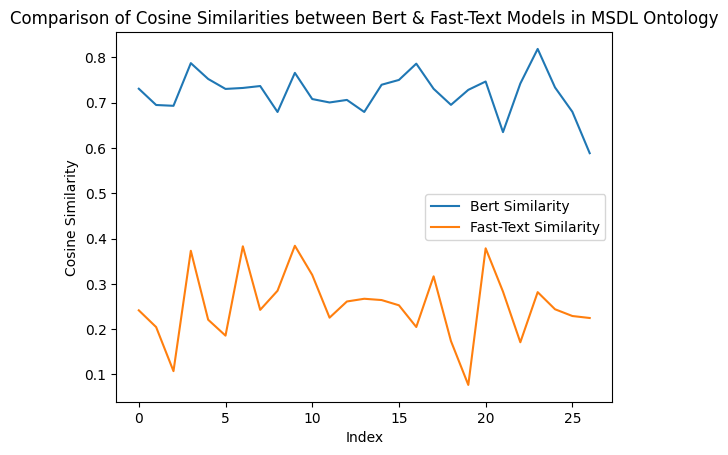

In [ ]:
# Plotting the results
x_msdl = df_compare_msdl.index.values
y1_msdl = df_compare_msdl['Cosine_Similarity_Bert']
y2_msdl = df_compare_msdl['Cosine_Similarity_Fast-Text']

plt.plot(x_msdl, y1_msdl, label='Bert Similarity')
plt.plot(x_msdl, y2_msdl, label='Fast-Text Similarity')
plt.xlabel('Index')
plt.ylabel('Cosine Similarity')
plt.title('Comparison of Cosine Similarities between Bert & Fast-Text Models in MSDL Ontology')
plt.legend()
plt.show()

## Pronto

In [ ]:
# Get the list of classes with annotations
pronto_class = []

for cls in pronto.classes():
    annotations = cls.comment
    if annotations:
        pronto_class.append(cls.name)

pronto_class

['SingularEntity',
 'DynamicEntity',
 'Entity',
 'Interval',
 'List2D',
 'Entry2D',
 'ClassifiedObject',
 'Component',
 'RangedAttribute',
 'ComponentConnection',
 'Attribute',
 'Product',
 'Element',
 'Assembly']

In [ ]:
pronto.classes()
pronto_cls = list(pronto.classes())

In [ ]:
pronto.properties()
pronto_property = list(pronto.properties())

In [ ]:
pronto_annotations = []
for ann in pronto_cls:
    print(f"\t{ann}: {ann.comment}")
    pronto_annotations.append(str(ann.comment))

	bpo.SingularEntity: [locstr('A singular entity represents one instance of a specific component.', 'en')]
	bpo.DynamicEntity: [locstr('A dynamic entity represents a (given) number of instances of one component that can be placed dynamically. However, a differentiation between the instances that are summarised in a dynamic entity is not possible: in the perspective of geometry, they have to be transformed identically in form of repetitions; they must have the same component connections, properties and material derivations.', 'en')]
	bpo.Entity: [locstr("Entities represent instances of a specific component that are placed within one assembly. Such an entity can be used to differentiate specific instances of a type from the (more generic) type's description in aspects as geometry (e.g. transformations), component connections, properties, or material structure.\r\nAn entity can only refer to one component.", 'en')]
	bpo.Interval: [locstr("An interval is an intermediate node between a prope

In [ ]:
# Remove the full stop from each element
pronto_annotations = [x.replace('.', '') for x in pronto_annotations]

for i in range(len(pronto_annotations)):
    pronto_annotations[i] = pronto_annotations[i] + "."

pronto_annotations

["[locstr('A singular entity represents one instance of a specific component', 'en')].",
 "[locstr('A dynamic entity represents a (given) number of instances of one component that can be placed dynamically However, a differentiation between the instances that are summarised in a dynamic entity is not possible: in the perspective of geometry, they have to be transformed identically in form of repetitions; they must have the same component connections, properties and material derivations', 'en')].",
 '[locstr("Entities represent instances of a specific component that are placed within one assembly Such an entity can be used to differentiate specific instances of a type from the (more generic) type\'s description in aspects as geometry (eg transformations), component connections, properties, or material structure\\r\\nAn entity can only refer to one component", \'en\')].',
 '[locstr("An interval is an intermediate node between a property and its disordered list of possible values This may

In [ ]:
pronto_ann = ', '.join(pronto_annotations)

# define a regular expression to match non-word characters except full stops
regex = re.compile('[%s]' % re.escape(string.punctuation.replace('.', '')))

# apply the regular expression to remove non-word characters
pronto_ann = regex.sub('', pronto_ann)
pronto_ann = re.sub(r'\b(?<!\w)en\b(?!\w)', '', pronto_ann)

pronto_ann

'locstrA singular entity represents one instance of a specific component . locstrA dynamic entity represents a given number of instances of one component that can be placed dynamically However a differentiation between the instances that are summarised in a dynamic entity is not possible in the perspective of geometry they have to be transformed identically in form of repetitions they must have the same component connections properties and material derivations . locstrEntities represent instances of a specific component that are placed within one assembly Such an entity can be used to differentiate specific instances of a type from the more generic types description in aspects as geometry eg transformations component connections properties or material structurernAn entity can only refer to one component . locstrAn interval is an intermediate node between a property and its disordered list of possible values This may be used when the propertys value range cannot be described using minin

In [ ]:
sentences_pronto = pronto_ann.split('. ')
valid_sentences_pronto = [s.strip() for s in sentences_pronto]

In [ ]:
# Define a translation table to remove punctuations, symbols, and hyphens
translator_pronto = str.maketrans("", "", string.punctuation + "’‘“”")

# Remove punctuations, symbols, and hyphens from each element of the list
valid_sentences_pronto = [s.translate(translator_pronto).strip() for s in valid_sentences_pronto]

#Removing unnecessary punctuations from the text
valid_sentences_pronto = [n.replace('\n', '') for n in valid_sentences_pronto]
valid_sentences_pronto = [n.replace('locstr', '') for n in valid_sentences_pronto]
valid_sentences_pronto = [n.replace('–', '') for n in valid_sentences_pronto]

valid_sentences_pronto = [item for item in valid_sentences_pronto if item != ' ' and item != '']

valid_sentences_pronto

['A singular entity represents one instance of a specific component',
 'A dynamic entity represents a given number of instances of one component that can be placed dynamically However a differentiation between the instances that are summarised in a dynamic entity is not possible in the perspective of geometry they have to be transformed identically in form of repetitions they must have the same component connections properties and material derivations',
 'Entities represent instances of a specific component that are placed within one assembly Such an entity can be used to differentiate specific instances of a type from the more generic types description in aspects as geometry eg transformations component connections properties or material structurernAn entity can only refer to one component',
 'An interval is an intermediate node between a property and its disordered list of possible values This may be used when the propertys value range cannot be described using mininum and maximum va

In [ ]:
# Chexking for duplicates
unique_items = set(valid_sentences_pronto)
duplicates = [item for item in unique_items if valid_sentences_pronto.count(item) > 1]
duplicates

[]

In [ ]:
len(valid_sentences_pronto)

14

### Bert Model

In [ ]:
# Load pre-trained model and tokenizer
model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# define the get_embedding function
def get_embedding(text, model, tokenizer):
    input_ids = tokenizer.encode(text, add_special_tokens=True)
    input_ids = torch.tensor(input_ids).unsqueeze(0)
    with torch.no_grad():
        outputs = model(input_ids)
        last_hidden_states = outputs[0].squeeze(0)
        mean_last_hidden_states = torch.mean(last_hidden_states, dim=0)
    return mean_last_hidden_states.numpy()

In [ ]:
# Create empty lists for embeddings
bert_embeddings = []
bert_embeddings_pronto = []

# Loop over sentences and calculate embeddings
for sent1 in valid_sentences:
    embedding1 = get_embedding(sent1, model, tokenizer)
    bert_embeddings.append(embedding1)
    for sent2 in valid_sentences_pronto:
        embedding2 = get_embedding(sent2, model, tokenizer)
        bert_embeddings_pronto.append(embedding2)

# Create dataframe
data_pronto = {
    "Input_Sentence": [],
    "Annotation": [],
    "Input_Sentence_Embedding": [],
    "Annotation_Embedding": [],
}

for sent1, emb1 in zip(valid_sentences, bert_embeddings):
    for sent2, emb2 in zip(valid_sentences_pronto, bert_embeddings_pronto):
        data_pronto["Input_Sentence"].append(sent1)
        data_pronto["Annotation"].append(sent2)
        data_pronto["Input_Sentence_Embedding"].append(emb1)
        data_pronto["Annotation_Embedding"].append(emb2)

df_pronto = pd.DataFrame(data_pronto)

In [ ]:
df_pronto.head(4)

,Input_Sentence,Annotation,Input_Sentence_Embedding,Annotation_Embedding
0,A manufacturing resource is a physical machine...,A singular entity represents one instance of a...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[-0.27689818, 0.013855283, -0.35556045, 0.0643..."
1,A manufacturing resource is a physical machine...,A dynamic entity represents a given number of ...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[-0.28466108, 0.18763325, 0.25717327, -0.00093..."
2,A manufacturing resource is a physical machine...,Entities represent instances of a specific com...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[-0.099865735, 0.14720719, 0.06440641, 0.02768..."
3,A manufacturing resource is a physical machine...,An interval is an intermediate node between a ...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[-0.3234424, -0.019793386, 0.17994449, 0.01558..."


In [ ]:
# Adding class to the dataframe
rep_class = []
for i in range(len(valid_sentences)):
    rep_class += pronto_class

df_pronto['Class'] = rep_class[:len(df_pronto)]

In [ ]:
# Define a lambda function to calculate the cosine similarity between embeddings
cosine_sim = lambda x: cosine_similarity([x['Input_Sentence_Embedding']], [x['Annotation_Embedding']])[0][0]

# Apply the lambda function to create a new column of cosine similarities
df_pronto['Cosine_Similarity'] = df_pronto.apply(cosine_sim, axis=1)

In [ ]:
df_pronto.head(10)

,Input_Sentence,Annotation,Input_Sentence_Embedding,Annotation_Embedding,Class,Cosine_Similarity
0,A manufacturing resource is a physical machine...,A singular entity represents one instance of a...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[-0.27689818, 0.013855283, -0.35556045, 0.0643...",SingularEntity,0.703056
1,A manufacturing resource is a physical machine...,A dynamic entity represents a given number of ...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[-0.28466108, 0.18763325, 0.25717327, -0.00093...",DynamicEntity,0.710894
2,A manufacturing resource is a physical machine...,Entities represent instances of a specific com...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[-0.099865735, 0.14720719, 0.06440641, 0.02768...",Entity,0.764192
3,A manufacturing resource is a physical machine...,An interval is an intermediate node between a ...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[-0.3234424, -0.019793386, 0.17994449, 0.01558...",Interval,0.646950
4,A manufacturing resource is a physical machine...,A 2D list is an disordered list containing val...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[-0.28418517, 0.15912108, 0.23206627, 0.082773...",List2D,0.681544
5,A manufacturing resource is a physical machine...,A 2D entry is a valuevalue pair for property v...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[-0.1964276, 0.08228651, 0.23940441, 0.0267379...",Entry2D,0.627537
6,A manufacturing resource is a physical machine...,The ClassifiedObject class groups all classes ...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[-0.15929466, 0.17038801, 0.041508753, 0.07786...",ClassifiedObject,0.611073
7,A manufacturing resource is a physical machine...,A component represents the description of an o...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[-0.27847946, 0.1854871, 0.21841583, -0.085751...",Component,0.755802
8,A manufacturing resource is a physical machine...,Ranged attributes describe components quantita...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[-0.13913815, -0.061056808, 0.2827671, 0.03620...",RangedAttribute,0.713569
9,A manufacturing resource is a physical machine...,A component connection defines a connection be...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[0.08311756, -0.05995307, 0.34636235, 0.128737...",ComponentConnection,0.732371


In [ ]:
# group the dataframe by the sentences in the original paragraph and find the maximum cosine similarity score for each group
max_similarities_pronto = df_pronto.groupby('Input_Sentence')['Cosine_Similarity'].max().reset_index()

# merge the original dataframe with the maximum cosine similarity scores
df_cosine_similarity_pronto = pd.merge(df_pronto, max_similarities_pronto, on=['Input_Sentence', 'Cosine_Similarity'], how='inner')

# Remove duplicates based on column 'Cosine_Similarity'
df_cosine_similarity_pronto.drop_duplicates(subset=['Cosine_Similarity'], keep='first', inplace=True)

# Reset the index of the resulting dataframe
df_cosine_similarity_pronto.reset_index(drop=True, inplace=True)

df_cosine_similarity_pronto.tail(6)

,Input_Sentence,Annotation,Input_Sentence_Embedding,Annotation_Embedding,Class,Cosine_Similarity
21,The doubleline rectangles illustrate the repre...,A 2D list is an disordered list containing val...,"[-0.107883915, -0.18923953, 0.026523529, -0.12...","[-0.28418517, 0.15912108, 0.23206627, 0.082773...",List2D,0.816968
22,To optimize the dynamic production objectives ...,A dynamic entity represents a given number of ...,"[-0.24513918, 0.41125837, 0.42129567, 0.336486...","[-0.28466108, 0.18763325, 0.25717327, -0.00093...",DynamicEntity,0.759183
23,The solutions include the suitable design of p...,A product is a description of any item that ca...,"[-0.16214529, 0.38038063, 0.19285934, 0.176923...","[0.04446505, 0.3031545, 0.16931315, -0.1347132...",Product,0.760199
24,This generation necessitates the consideration...,An interval is an intermediate node between a ...,"[-0.25785902, -0.10539124, 0.1677107, -0.06379...","[-0.3234424, -0.019793386, 0.17994449, 0.01558...",Interval,0.833431
25,On the other hand Resources can also influence...,A component connection defines a connection be...,"[-0.00021362305, 0.17030856, -0.096686415, 0.3...","[0.08311756, -0.05995307, 0.34636235, 0.128737...",ComponentConnection,0.727577
26,In this way the three notions are mutually rel...,A dynamic entity represents a given number of ...,"[-0.015573987, 0.49985212, 0.25958246, -0.3602...","[-0.28466108, 0.18763325, 0.25717327, -0.00093...",DynamicEntity,0.751277


In [ ]:
# Create a new dataframe for hash codes
df_cosine_similarity_hc_pronto = df_cosine_similarity_pronto.copy()

# Removing the Embedding columns
del df_cosine_similarity_hc_pronto['Input_Sentence_Embedding']
del df_cosine_similarity_hc_pronto['Annotation_Embedding']

In [ ]:
# create a new column with the hash code of the Input Sentence column
df_cosine_similarity_hc_pronto['Hash_Code'] = df_cosine_similarity_hc_pronto['Input_Sentence'].apply(lambda x: hashlib.sha256(x.encode()).hexdigest())

df_cosine_similarity_hc_pronto.head(3)

,Input_Sentence,Annotation,Class,Cosine_Similarity,Hash_Code
0,A manufacturing resource is a physical machine...,A product is a description of any item that ca...,Product,0.789018,32ce332c8db7e015d8f4be1d8adf730888812a83526a5d...
1,The manufacturing resource class has two subcl...,A component represents the description of an o...,Component,0.714282,9c764de3b6606c80e0b96b3b99eac613cd37e7ef47da04...
2,Labor skill represents labor rate and skill de...,Attributes describe components quantitative an...,Attribute,0.674029,79929088b6861a90d19a369055b994bdd1ff47209181d1...


### Populating the Hash-Code within the ontology

In [ ]:
# Iterate through each row of the dataframe
for index, col in df_cosine_similarity_hc_pronto.iterrows():
    # Get the hash code and the class from the current row
    hash_code = col['Hash_Code']
    class_name = col['Class']
    # Iterate through the classes in the ontology
    for cls in class_name:
        # Get the namespace of the ontology
        ns = pronto.get_namespace(base_iri=pronto.base_iri)
        # Get the class from the namespace
        cls = getattr(ns, class_name, None)
        # Check if the class was found in the ontology
        if cls is not None and isinstance(cls, ThingClass):
            # Create a new instance of the class with the hash code as the name
            instance = cls(hash_code)
        else:
            print(f"Class {class_name} not found in ontology")
        break  # exit the inner loop since we've found the matching class

# Save the ontology
pronto.save("bpo.rdf")

In [ ]:
for i in pronto.Product.instances(): print(i)

bpo.32ce332c8db7e015d8f4be1d8adf730888812a83526a5db175bd2cec718738a0
bpo.b472876c139a04babc571ed44a0708c2caccf886a6b8b41be423265e1f252225
bpo.e810b73299e463129471c037c05772a1172d43f85804b0fa99e08055291be813
bpo.b0fca6c1d4d57cac1b3e0f1ac3819383fc3d7d52bdfab2049d5686f25caa020e
bpo.fb46813c00b2437846fe5303ed51dc66d563fb5ad5ed12435532835dd42f7522
bpo.f177ad0e838576dc577ae101fc46cf807be060664270a39e6e7b7ffcda8b3c63
bpo.03147734e641dc8355bb833ac1f8bd67736c674ef2849c321b48c6ccad1e9afc
bpo.ebedaf62b1ad9e4702ea263a1ecba15486dbc07e739be7a12c9e35460b66360c


In [ ]:
# Print the individuals
for individual in pronto.individuals():
    print(individual)

bpo.32ce332c8db7e015d8f4be1d8adf730888812a83526a5db175bd2cec718738a0
bpo.9c764de3b6606c80e0b96b3b99eac613cd37e7ef47da04132dab83a0a513134f
bpo.79929088b6861a90d19a369055b994bdd1ff47209181d1bc636ee26d4ef4a54f
bpo.b472876c139a04babc571ed44a0708c2caccf886a6b8b41be423265e1f252225
bpo.0fe56c9325afe340cfbc8f6a49968cc22bba88b3da6ca114a1f3d9ccf379cfcb
bpo.e810b73299e463129471c037c05772a1172d43f85804b0fa99e08055291be813
bpo.8daea0b33ed7ad1beedbbe33c5135c11a7e6c0f3397819e8a35d263354eb2609
bpo.b0fca6c1d4d57cac1b3e0f1ac3819383fc3d7d52bdfab2049d5686f25caa020e
bpo.ad441f9006f94981fcc898d510443b95ce47128a7b25e8f64cca32df91381aa5
bpo.fb46813c00b2437846fe5303ed51dc66d563fb5ad5ed12435532835dd42f7522
bpo.0b25ba6cda2e3dd4bc4594000ff22b792e6c36c0e7227b3af5cc2a8c2dbcc452
bpo.f8f9ecc735793273ac7f0dcd99180b6bbe328191e24285e676f749015a203089
bpo.cd5f473fdc2c1862f11f70a75217febaaa8a25d14d5f58cc106a87e604cebf58
bpo.ebbbd7104b9e2bfdccfb20128f2a38abd25197a4f3bacf2217b03999e455309c
bpo.a66e26648d5f97961f4eeffa099348

In [ ]:
# Get a generator object for all individuals in the ontology
individuals = pronto.individuals()

# Loop over the generator and print the URI of each individual
for individual in individuals:
    individual_uri = individual.iri
    print("Individual URI:", individual_uri)

Individual URI: https://w3id.org/bpo#32ce332c8db7e015d8f4be1d8adf730888812a83526a5db175bd2cec718738a0
Individual URI: https://w3id.org/bpo#9c764de3b6606c80e0b96b3b99eac613cd37e7ef47da04132dab83a0a513134f
Individual URI: https://w3id.org/bpo#79929088b6861a90d19a369055b994bdd1ff47209181d1bc636ee26d4ef4a54f
Individual URI: https://w3id.org/bpo#b472876c139a04babc571ed44a0708c2caccf886a6b8b41be423265e1f252225
Individual URI: https://w3id.org/bpo#0fe56c9325afe340cfbc8f6a49968cc22bba88b3da6ca114a1f3d9ccf379cfcb
Individual URI: https://w3id.org/bpo#e810b73299e463129471c037c05772a1172d43f85804b0fa99e08055291be813
Individual URI: https://w3id.org/bpo#8daea0b33ed7ad1beedbbe33c5135c11a7e6c0f3397819e8a35d263354eb2609
Individual URI: https://w3id.org/bpo#b0fca6c1d4d57cac1b3e0f1ac3819383fc3d7d52bdfab2049d5686f25caa020e
Individual URI: https://w3id.org/bpo#ad441f9006f94981fcc898d510443b95ce47128a7b25e8f64cca32df91381aa5
Individual URI: https://w3id.org/bpo#fb46813c00b2437846fe5303ed51dc66d563fb5ad5ed1

In [ ]:
# Iterate over all individuals in the ontology
for individual in pronto.individuals():
    print("Individual:", individual.iri)
    # Get the list of classes that the individual is a direct instance of
    classes = individual.is_a
    # Print the classes
    for cls in classes:
        print("Class:", cls.iri)

Individual: https://w3id.org/bpo#32ce332c8db7e015d8f4be1d8adf730888812a83526a5db175bd2cec718738a0
Class: https://w3id.org/bpo#Product
Individual: https://w3id.org/bpo#9c764de3b6606c80e0b96b3b99eac613cd37e7ef47da04132dab83a0a513134f
Class: https://w3id.org/bpo#Component
Individual: https://w3id.org/bpo#79929088b6861a90d19a369055b994bdd1ff47209181d1bc636ee26d4ef4a54f
Class: https://w3id.org/bpo#Attribute
Individual: https://w3id.org/bpo#b472876c139a04babc571ed44a0708c2caccf886a6b8b41be423265e1f252225
Class: https://w3id.org/bpo#Product
Individual: https://w3id.org/bpo#0fe56c9325afe340cfbc8f6a49968cc22bba88b3da6ca114a1f3d9ccf379cfcb
Class: https://w3id.org/bpo#Component
Individual: https://w3id.org/bpo#e810b73299e463129471c037c05772a1172d43f85804b0fa99e08055291be813
Class: https://w3id.org/bpo#Product
Individual: https://w3id.org/bpo#8daea0b33ed7ad1beedbbe33c5135c11a7e6c0f3397819e8a35d263354eb2609
Class: https://w3id.org/bpo#SingularEntity
Individual: https://w3id.org/bpo#b0fca6c1d4d57cac

### Fast-Text

In [ ]:
# Convert the sentences to lowercase
lowercase_sentences = [sentence.lower() for sentence in valid_sentences]
lowercase_sentences_pronto = [sentence.lower() for sentence in valid_sentences_pronto]

# create a dictionary to map the original sentences with the converted lowercase sentences for further use
dict_pronto = {}
dict_ann_pronto = {}

# loop over the lists and add the elements as key-value pairs in the dictionary
for i in range(len(lowercase_sentences)):
    dict_pronto[lowercase_sentences[i]] = valid_sentences[i]

for i in range(len(lowercase_sentences_pronto)):
    dict_ann_pronto[lowercase_sentences_pronto[i]] = valid_sentences_pronto[i]

In [ ]:
# Split the sentences into words
lowercase_words = []
for sentence in lowercase_sentences:
    lowercase_words.extend(sentence.split())

lowercase_words_pronto = []
for sentence in lowercase_sentences_pronto:
    lowercase_words_pronto.extend(sentence.split())

# Write the input sentences to a text file
with open('ft_sentences_pronto.txt', 'w') as f:
    for s1 in lowercase_words:
        f.write(s1 + '\n')

# Write the annotations to a text file
with open('ft_sentences_ann_pronto.txt', 'w') as f:
    for s2 in lowercase_words_pronto:
        f.write(s2 + '\n')

# Create dataframe with every combination of sentences
combos = list(itertools.product(lowercase_sentences, lowercase_sentences_pronto))
df_pronto_ft = pd.DataFrame(combos, columns=["Input_Sentence", "Annotation"])

In [ ]:
# Train the FastText model
ft_model_pronto = fasttext.train_unsupervised('ft_sentences_pronto.txt', model='skipgram', dim=100)
ft_model_ann_pronto = fasttext.train_unsupervised('ft_sentences_ann_pronto.txt', model='skipgram', dim=100)

In [ ]:
# Function to create embeddings for the sentences
def create_embedding_pronto(sentence):
    return ft_model_pronto.get_sentence_vector(sentence)

def create_embedding_ann_pronto(sentence):
    return ft_model_ann_pronto.get_sentence_vector(sentence)

In [ ]:
# Apply function to each row of the DataFrame
df_pronto_ft['Input_Sentence_Embedding'] = df_pronto_ft['Input_Sentence'].apply(create_embedding_pronto)
df_pronto_ft['Annotation_Embedding'] = df_pronto_ft['Annotation'].apply(create_embedding_ann_pronto)

In [ ]:
df_pronto_ft.head(10)

,Input_Sentence,Annotation,Input_Sentence_Embedding,Annotation_Embedding
0,a manufacturing resource is a physical machine...,a singular entity represents one instance of a...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[-0.019940807, 0.055139106, -0.02257566, -0.01..."
1,a manufacturing resource is a physical machine...,a dynamic entity represents a given number of ...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.012033099, 0.017255673, -0.001680788, -0.04..."
2,a manufacturing resource is a physical machine...,entities represent instances of a specific com...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.027045691, -0.01380978, -0.0066502006, -0.0..."
3,a manufacturing resource is a physical machine...,an interval is an intermediate node between a ...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.0012429635, 0.015681613, 0.0001983428, -0.0..."
4,a manufacturing resource is a physical machine...,a 2d list is an disordered list containing val...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.032901045, 0.037640687, 0.013188024, -0.054..."
5,a manufacturing resource is a physical machine...,a 2d entry is a valuevalue pair for property v...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.033695802, 0.06407063, 0.009834594, -0.0710..."
6,a manufacturing resource is a physical machine...,the classifiedobject class groups all classes ...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.05275044, 0.023846567, -0.013054225, -0.072..."
7,a manufacturing resource is a physical machine...,a component represents the description of an o...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.022929782, 0.03563294, -0.022149965, -0.017..."
8,a manufacturing resource is a physical machine...,ranged attributes describe components quantita...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.020363988, -0.012843797, -0.024303952, -0.0..."
9,a manufacturing resource is a physical machine...,a component connection defines a connection be...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.019171515, 0.025136022, -0.028850744, -0.04..."


In [ ]:
# Adding class to the dataframe
rep_class_ft = []
for i in range(len(lowercase_sentences)):
    rep_class_ft += pronto_class

df_pronto_ft['Class'] = rep_class_ft[:len(df_pronto_ft)]

In [ ]:
# Define a lambda function to calculate the cosine similarity between embeddings
cosine_sim = lambda x: cosine_similarity([x['Input_Sentence_Embedding']], [x['Annotation_Embedding']])[0][0]

# Apply the lambda function to create a new column of cosine similarities
df_pronto_ft['Cosine_Similarity'] = df_pronto_ft.apply(cosine_sim, axis=1)

In [ ]:
df_pronto_ft.head(10)

,Input_Sentence,Annotation,Input_Sentence_Embedding,Annotation_Embedding,Class,Cosine_Similarity
0,a manufacturing resource is a physical machine...,a singular entity represents one instance of a...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[-0.019940807, 0.055139106, -0.02257566, -0.01...",SingularEntity,0.298143
1,a manufacturing resource is a physical machine...,a dynamic entity represents a given number of ...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.012033099, 0.017255673, -0.001680788, -0.04...",DynamicEntity,0.271562
2,a manufacturing resource is a physical machine...,entities represent instances of a specific com...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.027045691, -0.01380978, -0.0066502006, -0.0...",Entity,0.217846
3,a manufacturing resource is a physical machine...,an interval is an intermediate node between a ...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.0012429635, 0.015681613, 0.0001983428, -0.0...",Interval,0.114444
4,a manufacturing resource is a physical machine...,a 2d list is an disordered list containing val...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.032901045, 0.037640687, 0.013188024, -0.054...",List2D,0.209741
5,a manufacturing resource is a physical machine...,a 2d entry is a valuevalue pair for property v...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.033695802, 0.06407063, 0.009834594, -0.0710...",Entry2D,0.250816
6,a manufacturing resource is a physical machine...,the classifiedobject class groups all classes ...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.05275044, 0.023846567, -0.013054225, -0.072...",ClassifiedObject,0.002175
7,a manufacturing resource is a physical machine...,a component represents the description of an o...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.022929782, 0.03563294, -0.022149965, -0.017...",Component,0.217967
8,a manufacturing resource is a physical machine...,ranged attributes describe components quantita...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.020363988, -0.012843797, -0.024303952, -0.0...",RangedAttribute,0.172310
9,a manufacturing resource is a physical machine...,a component connection defines a connection be...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.019171515, 0.025136022, -0.028850744, -0.04...",ComponentConnection,0.244402


In [ ]:
# group the dataframe by the sentences in the original paragraph and find the maximum cosine similarity score for each group
max_similarities_ft_pronto = df_pronto_ft.groupby('Input_Sentence')['Cosine_Similarity'].max().reset_index()

# merge the original dataframe with the maximum cosine similarity scores
df_cosine_similarity_ft_pronto = pd.merge(df_pronto_ft, max_similarities_ft_pronto, on=['Input_Sentence', 'Cosine_Similarity'], how='inner')

# Remove duplicates based on column 'Cosine_Similarity'
df_cosine_similarity_ft_pronto.drop_duplicates(subset=['Cosine_Similarity'], keep='first', inplace=True)

# Reset the index of the resulting dataframe
df_cosine_similarity_ft_pronto.reset_index(drop=True, inplace=True)

df_cosine_similarity_ft_pronto.head(20)

,Input_Sentence,Annotation,Input_Sentence_Embedding,Annotation_Embedding,Class,Cosine_Similarity
0,a manufacturing resource is a physical machine...,a product is a description of any item that ca...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.0140017895, -0.0106558865, -0.013645715, -0...",Product,0.302603
1,the manufacturing resource class has two subcl...,a product is a description of any item that ca...,"[0.0893878, 0.0019307006, 0.0401662, 0.0379929...","[0.0140017895, -0.0106558865, -0.013645715, -0...",Product,0.304419
2,labor skill represents labor rate and skill de...,an assembly is the description of a structure ...,"[0.046736687, -0.01577708, 0.008850802, 0.0020...","[0.035188954, -0.0036248192, 0.031120097, -0.0...",Assembly,0.127161
3,the manufacturing equipment subclass represent...,a product is a description of any item that ca...,"[0.084363826, 0.03799975, -0.019190976, -0.015...","[0.0140017895, -0.0106558865, -0.013645715, -0...",Product,0.481503
4,there are four subclasses machine die mold and...,a singular entity represents one instance of a...,"[0.01983861, -0.017472751, 0.037692044, -0.041...","[-0.019940807, 0.055139106, -0.02257566, -0.01...",SingularEntity,0.308865
5,if necessary other equipment classes may be ad...,a product is a description of any item that ca...,"[0.060407255, 0.010101532, -0.023370566, 0.011...","[0.0140017895, -0.0106558865, -0.013645715, -0...",Product,0.348370
6,a piece of equipment has a set of parameters t...,a product is a description of any item that ca...,"[0.030016705, -0.00068290014, -0.03147005, 0.0...","[0.0140017895, -0.0106558865, -0.013645715, -0...",Product,0.443731
7,a machine can be a machining centre casting ma...,a component connection defines a connection be...,"[0.011380323, 0.014811401, -0.040216766, -0.01...","[0.019171515, 0.025136022, -0.028850744, -0.04...",ComponentConnection,0.395111
8,a machine has a set of parameters such as dime...,an assembly is the description of a structure ...,"[0.021427501, -0.005249445, 0.033188514, -0.03...","[0.035188954, -0.0036248192, 0.031120097, -0.0...",Assembly,0.452325
9,a tool represents a tool used in the machining...,a 2d entry is a valuevalue pair for property v...,"[0.029928327, 0.012151852, -0.0065322244, -0.0...","[0.033695802, 0.06407063, 0.009834594, -0.0710...",Entry2D,0.497678


In [ ]:
# Removing the Embedding columns
del df_cosine_similarity_ft_pronto['Input_Sentence_Embedding']
del df_cosine_similarity_ft_pronto['Annotation_Embedding']

### Comparing Bert vs Fast-Text Models

In [ ]:
# Switching every row of the 'Input_Sentence' & 'Annotation' columns of the Fast-Text dataframe to the dictionary values for comparison
df_cosine_similarity_ft_pronto['Input_Sentence'] = df_cosine_similarity_ft_pronto['Input_Sentence'].map(dict_pronto)
df_cosine_similarity_ft_pronto['Annotation'] = df_cosine_similarity_ft_pronto['Annotation'].map(dict_ann_pronto)

# Creating new dataframe for comparison
df_compare_pronto = pd.merge(df_cosine_similarity_hc_pronto, df_cosine_similarity_ft_pronto, how = 'left', on = 'Input_Sentence')

# Renaming the columns
df_compare_pronto.rename(columns={'Annotation_x': 'Annotation_Bert', 'Annotation_y': 'Annotation_Fast-Text', 'Class_x': 'Class_Bert',
                                 'Class_y': 'Class_Fast-Text', 'Cosine_Similarity_x': 'Cosine_Similarity_Bert', 'Cosine_Similarity_y': 'Cosine_Similarity_Fast-Text'}, inplace=True)

# Removing the unused columns
del df_compare_pronto['Hash_Code']

# Changing the positons of the columns
df_compare_pronto = df_compare_pronto.reindex(columns=['Input_Sentence', 'Annotation_Bert', 'Annotation_Fast-Text', 'Class_Bert', 'Class_Fast-Text', 'Cosine_Similarity_Bert', 'Cosine_Similarity_Fast-Text'])

df_compare_pronto.head(15)

,Input_Sentence,Annotation_Bert,Annotation_Fast-Text,Class_Bert,Class_Fast-Text,Cosine_Similarity_Bert,Cosine_Similarity_Fast-Text
0,A manufacturing resource is a physical machine...,A product is a description of any item that ca...,A product is a description of any item that ca...,Product,Product,0.789018,0.302603
1,The manufacturing resource class has two subcl...,A component represents the description of an o...,A product is a description of any item that ca...,Component,Product,0.714282,0.304419
2,Labor skill represents labor rate and skill de...,Attributes describe components quantitative an...,An assembly is the description of a structure ...,Attribute,Assembly,0.674029,0.127161
3,The manufacturing equipment subclass represent...,A product is a description of any item that ca...,A product is a description of any item that ca...,Product,Product,0.829649,0.481503
4,There are four subclasses machine die mold and...,A component represents the description of an o...,A singular entity represents one instance of a...,Component,SingularEntity,0.713725,0.308865
5,If necessary other equipment classes may be ad...,A product is a description of any item that ca...,A product is a description of any item that ca...,Product,Product,0.757552,0.348370
6,A piece of equipment has a set of parameters t...,A singular entity represents one instance of a...,A product is a description of any item that ca...,SingularEntity,Product,0.803624,0.443731
7,A machine can be a machining centre casting ma...,A product is a description of any item that ca...,A component connection defines a connection be...,Product,ComponentConnection,0.707711,0.395111
8,A machine has a set of parameters such as dime...,An interval is an intermediate node between a ...,An assembly is the description of a structure ...,Interval,Assembly,0.806967,0.452325
9,A tool represents a tool used in the machining...,A product is a description of any item that ca...,A 2D entry is a valuevalue pair for property v...,Product,Entry2D,0.769923,0.497678


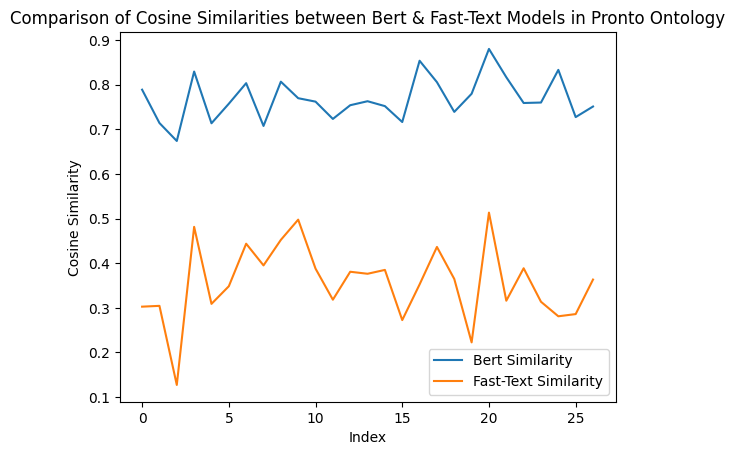

In [ ]:
# Plotting the results
x_pronto = df_compare_pronto.index.values
y1_pronto = df_compare_pronto['Cosine_Similarity_Bert']
y2_pronto = df_compare_pronto['Cosine_Similarity_Fast-Text']

plt.plot(x_pronto, y1_pronto, label='Bert Similarity')
plt.plot(x_pronto, y2_pronto, label='Fast-Text Similarity')
plt.xlabel('Index')
plt.ylabel('Cosine Similarity')
plt.title('Comparison of Cosine Similarities between Bert & Fast-Text Models in Pronto Ontology')
plt.legend()
plt.show()

## SMO

In [ ]:
# Get the list of classes with annotations
smo_class = []

for cls in smo.classes():
    annotations = cls.comment
    if annotations:
        smo_class.append(cls.name)

smo_class

['ManufacturingFacility',
 'Machine',
 'Resource',
 'Capability',
 'Process',
 'Speed',
 'Supplier',
 'StorageHall',
 'AssemblingMachine',
 'ProcessingMachine',
 'Power',
 'Line',
 'WorkStation',
 'Customer',
 'Motor',
 'Conveyor',
 'Location',
 'Product',
 'HandlingSystem',
 'ConvyerOperation',
 'Pressure',
 'Device',
 'Staff',
 'Material',
 'Tool',
 'Observation',
 'State',
 'Situation',
 'OperatingHours',
 'Order',
 'Sensor',
 'Service',
 'Actuator',
 'PressureSensor',
 'TemperatureSensor',
 'Unit',
 'Part',
 'Feeder',
 'ManufacturingProcess',
 'Pallet',
 'Maintenance',
 'AssemblingProcess',
 'MotorState',
 'Temperature',
 'Time',
 'Vibration',
 'WorkStationState',
 'Bar',
 'DegreeCelsius',
 'DegreeFahrenheit',
 'PhysicalQuantity',
 'Cell',
 'Container',
 'ContextualData',
 'Parameter',
 'Handling',
 'Pascal',
 'FeederOperation',
 'MaintenanceTechnician',
 'Operator',
 'Sit-Monitoring',
 'Transfer']

In [ ]:
smo.classes()
smo_cls = list(smo.classes())

In [ ]:
smo.properties()
smo_property = list(smo.properties())

In [ ]:
smo_annotations = []
for ann in smo_cls:
    print(f"\t{ann}: {ann.comment}")
    smo_annotations.append(str(ann.comment))

	smo.ManufacturingFacility: [locstr('Any resource contributing in the production of goods in the manufacturing produciton line.', 'en')]
	smo.Machine: [locstr('A machine (or mechanical device) is a mechanical structure that uses power to apply forces and control movement to perform an intended action. Machines can be driven by animals and people, by natural forces such as wind and water, and by chemical, thermal, or electrical power, and include a system of mechanisms that shape the actuator input to achieve a specific application of output forces and movement.', 'en')]
	smo.Resource: [locstr('A source or supply from which a benefit is produced and that has some utility.', 'en')]
	smo.Capability: [locstr('A capability is the ability to perform or achieve certain actions.', 'en')]
	smo.Process: [locstr('A process is series or set of activities that interact to produce a result.', 'en')]
	smo.Speed: [locstr('In everyday use and in kinematics, the speed of an object is the magnitude of th

In [ ]:
# Remove the full stop from each element
smo_annotations = [x.replace('.', '') for x in smo_annotations]

for i in range(len(smo_annotations)):
    smo_annotations[i] = smo_annotations[i] + "."

smo_annotations

["[locstr('Any resource contributing in the production of goods in the manufacturing produciton line', 'en')].",
 "[locstr('A machine (or mechanical device) is a mechanical structure that uses power to apply forces and control movement to perform an intended action Machines can be driven by animals and people, by natural forces such as wind and water, and by chemical, thermal, or electrical power, and include a system of mechanisms that shape the actuator input to achieve a specific application of output forces and movement', 'en')].",
 "[locstr('A source or supply from which a benefit is produced and that has some utility', 'en')].",
 "[locstr('A capability is the ability to perform or achieve certain actions', 'en')].",
 "[locstr('A process is series or set of activities that interact to produce a result', 'en')].",
 "[locstr('In everyday use and in kinematics, the speed of an object is the magnitude of the change of its position; it is thus a scalar quantity The average speed of an 

In [ ]:
smo_ann = ', '.join(smo_annotations)

# define a regular expression to match non-word characters except full stops
regex = re.compile('[%s]' % re.escape(string.punctuation.replace('.', '')))

# apply the regular expression to remove non-word characters
smo_ann = regex.sub('', smo_ann)
smo_ann = re.sub(r'\b(?<!\w)en\b(?!\w)', '', smo_ann)

smo_ann

'locstrAny resource contributing in the production of goods in the manufacturing produciton line . locstrA machine or mechanical device is a mechanical structure that uses power to apply forces and control movement to perform an intended action Machines can be driven by animals and people by natural forces such as wind and water and by chemical thermal or electrical power and include a system of mechanisms that shape the actuator input to achieve a specific application of output forces and movement . locstrA source or supply from which a benefit is produced and that has some utility . locstrA capability is the ability to perform or achieve certain actions . locstrA process is series or set of activities that interact to produce a result . locstrIn everyday use and in kinematics the speed of an object is the magnitude of the change of its position it is thus a scalar quantity The average speed of an object in an interval of time is the distance travelled by the object divided by the dur

In [ ]:
sentences_smo = smo_ann.split('. ')
valid_sentences_smo = [s.strip() for s in sentences_smo]

In [ ]:
# Define a translation table to remove punctuations, symbols, and hyphens
translator_smo = str.maketrans("", "", string.punctuation + "’‘“”")

# Remove punctuations, symbols, and hyphens from each element of the list
valid_sentences_smo = [s.translate(translator_smo).strip() for s in valid_sentences_smo]

#Removing unnecessary punctuations from the text
valid_sentences_smo = [n.replace('\n', '') for n in valid_sentences_smo]
valid_sentences_smo = [n.replace('locstr', '') for n in valid_sentences_smo]
valid_sentences_smo = [n.replace('–', '') for n in valid_sentences_smo]

valid_sentences_smo = [item for item in valid_sentences_smo if item != ' ' and item != '']

valid_sentences_smo

['Any resource contributing in the production of goods in the manufacturing produciton line',
 'A machine or mechanical device is a mechanical structure that uses power to apply forces and control movement to perform an intended action Machines can be driven by animals and people by natural forces such as wind and water and by chemical thermal or electrical power and include a system of mechanisms that shape the actuator input to achieve a specific application of output forces and movement',
 'A source or supply from which a benefit is produced and that has some utility',
 'A capability is the ability to perform or achieve certain actions',
 'A process is series or set of activities that interact to produce a result',
 'In everyday use and in kinematics the speed of an object is the magnitude of the change of its position it is thus a scalar quantity The average speed of an object in an interval of time is the distance travelled by the object divided by the duration of the interval the

In [ ]:
# Chexking for duplicates
unique_items = set(valid_sentences_smo)
duplicates = [item for item in unique_items if valid_sentences_smo.count(item) > 1]
duplicates

['Temperature Unit', 'Pressure Unit']

In [ ]:
len(valid_sentences_smo)

62

### Bert Model

In [ ]:
# Load pre-trained model and tokenizer
model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# define the get_embedding function
def get_embedding(text, model, tokenizer):
    input_ids = tokenizer.encode(text, add_special_tokens=True)
    input_ids = torch.tensor(input_ids).unsqueeze(0)
    with torch.no_grad():
        outputs = model(input_ids)
        last_hidden_states = outputs[0].squeeze(0)
        mean_last_hidden_states = torch.mean(last_hidden_states, dim=0)
    return mean_last_hidden_states.numpy()

In [ ]:
# Create empty lists for embeddings
bert_embeddings = []
bert_embeddings_smo = []

# Loop over sentences and calculate embeddings
for sent1 in valid_sentences:
    embedding1 = get_embedding(sent1, model, tokenizer)
    bert_embeddings.append(embedding1)
    for sent2 in valid_sentences_smo:
        embedding2 = get_embedding(sent2, model, tokenizer)
        bert_embeddings_smo.append(embedding2)

# Create dataframe
data_smo = {
    "Input_Sentence": [],
    "Annotation": [],
    "Input_Sentence_Embedding": [],
    "Annotation_Embedding": [],
}

for sent1, emb1 in zip(valid_sentences, bert_embeddings):
    for sent2, emb2 in zip(valid_sentences_smo, bert_embeddings_smo):
        data_smo["Input_Sentence"].append(sent1)
        data_smo["Annotation"].append(sent2)
        data_smo["Input_Sentence_Embedding"].append(emb1)
        data_smo["Annotation_Embedding"].append(emb2)

df_smo = pd.DataFrame(data_smo)

In [ ]:
df_smo.head(4)

,Input_Sentence,Annotation,Input_Sentence_Embedding,Annotation_Embedding
0,A manufacturing resource is a physical machine...,Any resource contributing in the production of...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[-0.21494593, -0.22522037, 0.136661, 0.0873670..."
1,A manufacturing resource is a physical machine...,A machine or mechanical device is a mechanical...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[0.068628296, 0.35038796, 0.21487229, 0.111413..."
2,A manufacturing resource is a physical machine...,A source or supply from which a benefit is pro...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[0.09153069, -0.02150552, 0.15966932, 0.153057..."
3,A manufacturing resource is a physical machine...,A capability is the ability to perform or achi...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[0.16444786, 0.060687765, -0.10281471, 0.11873..."


In [ ]:
# Adding class to the dataframe
rep_class = []
for i in range(len(valid_sentences)):
    rep_class += smo_class

df_smo['Class'] = rep_class[:len(df_smo)]

In [ ]:
# Define a lambda function to calculate the cosine similarity between embeddings
cosine_sim = lambda x: cosine_similarity([x['Input_Sentence_Embedding']], [x['Annotation_Embedding']])[0][0]

# Apply the lambda function to create a new column of cosine similarities
df_smo['Cosine_Similarity'] = df_smo.apply(cosine_sim, axis=1)

In [ ]:
df_smo.head(10)

,Input_Sentence,Annotation,Input_Sentence_Embedding,Annotation_Embedding,Class,Cosine_Similarity
0,A manufacturing resource is a physical machine...,Any resource contributing in the production of...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[-0.21494593, -0.22522037, 0.136661, 0.0873670...",ManufacturingFacility,0.734496
1,A manufacturing resource is a physical machine...,A machine or mechanical device is a mechanical...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[0.068628296, 0.35038796, 0.21487229, 0.111413...",Machine,0.816093
2,A manufacturing resource is a physical machine...,A source or supply from which a benefit is pro...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[0.09153069, -0.02150552, 0.15966932, 0.153057...",Resource,0.725449
3,A manufacturing resource is a physical machine...,A capability is the ability to perform or achi...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[0.16444786, 0.060687765, -0.10281471, 0.11873...",Capability,0.775027
4,A manufacturing resource is a physical machine...,A process is series or set of activities that ...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[0.1936908, 0.02936204, 0.23710299, 0.17662801...",Process,0.800724
5,A manufacturing resource is a physical machine...,In everyday use and in kinematics the speed of...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[-0.43587142, -0.12403919, 0.2934029, -0.18622...",Speed,0.709770
6,A manufacturing resource is a physical machine...,A person or organization that provides somethi...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[-0.0068698567, 0.1157573, 0.08955933, 0.04287...",Supplier,0.775309
7,A manufacturing resource is a physical machine...,A storeroom in a factory where odds and ends c...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[0.12864137, -0.24324888, -0.06366298, 0.34151...",StorageHall,0.714342
8,A manufacturing resource is a physical machine...,A machine combining the semi finished product ...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[0.116878785, -0.20895804, -0.08499205, 0.2463...",AssemblingMachine,0.660744
9,A manufacturing resource is a physical machine...,A machine that perfroms a process in which a ...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[-0.058737874, 0.09812951, 0.028496932, -0.103...",ProcessingMachine,0.787186


In [ ]:
# group the dataframe by the sentences in the original paragraph and find the maximum cosine similarity score for each group
max_similarities_smo = df_smo.groupby('Input_Sentence')['Cosine_Similarity'].max().reset_index()

# merge the original dataframe with the maximum cosine similarity scores
df_cosine_similarity_smo = pd.merge(df_smo, max_similarities_smo, on=['Input_Sentence', 'Cosine_Similarity'], how='inner')

# Remove duplicates based on column 'Cosine_Similarity'
df_cosine_similarity_smo.drop_duplicates(subset=['Cosine_Similarity'], keep='first', inplace=True)

# Reset the index of the resulting dataframe
df_cosine_similarity_smo.reset_index(drop=True, inplace=True)

df_cosine_similarity_smo.head(17)

,Input_Sentence,Annotation,Input_Sentence_Embedding,Annotation_Embedding,Class,Cosine_Similarity
0,A manufacturing resource is a physical machine...,In marketing a product is an object or system ...,"[0.02053377, 0.36042503, -0.14129059, 0.335688...","[0.22292311, 0.19676168, 0.27067196, -0.001384...",Product,0.820838
1,The manufacturing resource class has two subcl...,Cells are sets of machines that are grouped by...,"[-0.028008692, 0.116112635, -0.18360376, 0.256...","[-0.019780545, 0.2214496, 0.25456083, 0.016186...",Cell,0.714935
2,Labor skill represents labor rate and skill de...,Source of energy consumed by devices to perfor...,"[0.20286956, 0.035978027, 0.10824008, 0.278719...","[0.047276244, -0.17581813, -0.09682261, 0.2602...",Power,0.701839
3,The manufacturing equipment subclass represent...,In marketing a product is an object or system ...,"[0.1603254, 0.27694675, -0.109380245, -0.03558...","[0.22292311, 0.19676168, 0.27067196, -0.001384...",Product,0.803409
4,There are four subclasses machine die mold and...,A mechanical equipment used for the movement a...,"[0.2069281, 0.020959228, 0.027157933, 0.191676...","[0.017254937, 0.37473494, 0.058568805, 0.20832...",HandlingSystem,0.784534
5,If necessary other equipment classes may be ad...,Feeder adds materials or ingredients to a mach...,"[0.14093399, 0.018831663, 0.018648416, 0.08639...","[0.3688966, -0.02151084, -0.11670977, 0.336742...",Feeder,0.724398
6,A piece of equipment has a set of parameters t...,A parameter is an element of a system that is ...,"[0.3047745, 0.12560761, -0.049202126, 0.097845...","[-0.34228465, 0.18897554, -0.21584386, 0.05324...",Parameter,0.827879
7,A machine can be a machining centre casting ma...,A mechanical equipment used for the movement a...,"[0.52098066, 0.115130186, 0.06317457, 0.043813...","[0.017254937, 0.37473494, 0.058568805, 0.20832...",HandlingSystem,0.805118
8,A machine has a set of parameters such as dime...,A parameter is an element of a system that is ...,"[0.024191365, -0.21037242, 0.14857751, 0.15994...","[-0.34228465, 0.18897554, -0.21584386, 0.05324...",Parameter,0.773502
9,A tool represents a tool used in the machining...,A mechanical equipment used for the movement a...,"[0.014235898, -0.019473657, -0.056053758, 0.12...","[0.017254937, 0.37473494, 0.058568805, 0.20832...",HandlingSystem,0.841248


In [ ]:
# Create a new dataframe for hash codes
df_cosine_similarity_hc_smo = df_cosine_similarity_smo.copy()

# Removing the Embedding columns
del df_cosine_similarity_hc_smo['Input_Sentence_Embedding']
del df_cosine_similarity_hc_smo['Annotation_Embedding']

In [ ]:
# create a new column with the hash code of the Input Sentence column
df_cosine_similarity_hc_smo['Hash_Code'] = df_cosine_similarity_hc_smo['Input_Sentence'].apply(lambda x: hashlib.sha256(x.encode()).hexdigest())

df_cosine_similarity_hc_smo.head(3)

,Input_Sentence,Annotation,Class,Cosine_Similarity,Hash_Code
0,A manufacturing resource is a physical machine...,In marketing a product is an object or system ...,Product,0.820838,32ce332c8db7e015d8f4be1d8adf730888812a83526a5d...
1,The manufacturing resource class has two subcl...,Cells are sets of machines that are grouped by...,Cell,0.714935,9c764de3b6606c80e0b96b3b99eac613cd37e7ef47da04...
2,Labor skill represents labor rate and skill de...,Source of energy consumed by devices to perfor...,Power,0.701839,79929088b6861a90d19a369055b994bdd1ff47209181d1...


### Populating the Hash-Code within the ontology

In [ ]:
# Iterate through each row of the dataframe
for index, col in df_cosine_similarity_hc_smo.iterrows():
    # Get the hash code and the class from the current row
    hash_code = col['Hash_Code']
    class_name = col['Class']
    # Iterate through the classes in the ontology
    for cls in class_name:
        # Get the namespace of the ontology
        ns = smo.get_namespace(base_iri=smo.base_iri)
        # Get the class from the namespace
        cls = getattr(ns, class_name, None)
        # Check if the class was found in the ontology
        if cls is not None and isinstance(cls, ThingClass):
            # Create a new instance of the class with the hash code as the name
            instance = cls(hash_code)
        else:
            print(f"Class {class_name} not found in ontology")
        break  # exit the inner loop since we've found the matching class

# Save the ontology
smo.save("smo.owl")

In [ ]:
for i in smo.Feeder.instances(): print(i)

smo.e810b73299e463129471c037c05772a1172d43f85804b0fa99e08055291be813


In [ ]:
# Print the individuals
for individual in smo.individuals():
    print(individual)

smo.32ce332c8db7e015d8f4be1d8adf730888812a83526a5db175bd2cec718738a0
smo.9c764de3b6606c80e0b96b3b99eac613cd37e7ef47da04132dab83a0a513134f
smo.79929088b6861a90d19a369055b994bdd1ff47209181d1bc636ee26d4ef4a54f
smo.b472876c139a04babc571ed44a0708c2caccf886a6b8b41be423265e1f252225
smo.0fe56c9325afe340cfbc8f6a49968cc22bba88b3da6ca114a1f3d9ccf379cfcb
smo.e810b73299e463129471c037c05772a1172d43f85804b0fa99e08055291be813
smo.8daea0b33ed7ad1beedbbe33c5135c11a7e6c0f3397819e8a35d263354eb2609
smo.b0fca6c1d4d57cac1b3e0f1ac3819383fc3d7d52bdfab2049d5686f25caa020e
smo.ad441f9006f94981fcc898d510443b95ce47128a7b25e8f64cca32df91381aa5
smo.fb46813c00b2437846fe5303ed51dc66d563fb5ad5ed12435532835dd42f7522
smo.0b25ba6cda2e3dd4bc4594000ff22b792e6c36c0e7227b3af5cc2a8c2dbcc452
smo.f8f9ecc735793273ac7f0dcd99180b6bbe328191e24285e676f749015a203089
smo.cd5f473fdc2c1862f11f70a75217febaaa8a25d14d5f58cc106a87e604cebf58
smo.ebbbd7104b9e2bfdccfb20128f2a38abd25197a4f3bacf2217b03999e455309c
smo.a66e26648d5f97961f4eeffa099348

In [ ]:
# Get a generator object for all individuals in the ontology
individuals = smo.individuals()

# Loop over the generator and print the URI of each individual
for individual in individuals:
    individual_uri = individual.iri
    print("Individual URI:", individual_uri)

Individual URI: https://w3id.org/rgom#32ce332c8db7e015d8f4be1d8adf730888812a83526a5db175bd2cec718738a0
Individual URI: https://w3id.org/rgom#9c764de3b6606c80e0b96b3b99eac613cd37e7ef47da04132dab83a0a513134f
Individual URI: https://w3id.org/rgom#79929088b6861a90d19a369055b994bdd1ff47209181d1bc636ee26d4ef4a54f
Individual URI: https://w3id.org/rgom#b472876c139a04babc571ed44a0708c2caccf886a6b8b41be423265e1f252225
Individual URI: https://w3id.org/rgom#0fe56c9325afe340cfbc8f6a49968cc22bba88b3da6ca114a1f3d9ccf379cfcb
Individual URI: https://w3id.org/rgom#e810b73299e463129471c037c05772a1172d43f85804b0fa99e08055291be813
Individual URI: https://w3id.org/rgom#8daea0b33ed7ad1beedbbe33c5135c11a7e6c0f3397819e8a35d263354eb2609
Individual URI: https://w3id.org/rgom#b0fca6c1d4d57cac1b3e0f1ac3819383fc3d7d52bdfab2049d5686f25caa020e
Individual URI: https://w3id.org/rgom#ad441f9006f94981fcc898d510443b95ce47128a7b25e8f64cca32df91381aa5
Individual URI: https://w3id.org/rgom#fb46813c00b2437846fe5303ed51dc66d56

In [ ]:
# Iterate over all individuals in the ontology
for individual in smo.individuals():
    print("Individual:", individual.iri)
    # Get the list of classes that the individual is a direct instance of
    classes = individual.is_a
    # Print the classes
    for cls in classes:
        print("Class:", cls.iri)

Individual: https://w3id.org/rgom#32ce332c8db7e015d8f4be1d8adf730888812a83526a5db175bd2cec718738a0
Class: https://w3id.org/rgom#Product
Individual: https://w3id.org/rgom#9c764de3b6606c80e0b96b3b99eac613cd37e7ef47da04132dab83a0a513134f
Class: https://w3id.org/rgom#Cell
Individual: https://w3id.org/rgom#79929088b6861a90d19a369055b994bdd1ff47209181d1bc636ee26d4ef4a54f
Class: https://w3id.org/rgom#Power
Individual: https://w3id.org/rgom#b472876c139a04babc571ed44a0708c2caccf886a6b8b41be423265e1f252225
Class: https://w3id.org/rgom#Product
Individual: https://w3id.org/rgom#0fe56c9325afe340cfbc8f6a49968cc22bba88b3da6ca114a1f3d9ccf379cfcb
Class: https://w3id.org/rgom#HandlingSystem
Individual: https://w3id.org/rgom#e810b73299e463129471c037c05772a1172d43f85804b0fa99e08055291be813
Class: https://w3id.org/rgom#Feeder
Individual: https://w3id.org/rgom#8daea0b33ed7ad1beedbbe33c5135c11a7e6c0f3397819e8a35d263354eb2609
Class: https://w3id.org/rgom#Parameter
Individual: https://w3id.org/rgom#b0fca6c1d4d

### Fast-Text

In [ ]:
# Convert the sentences to lowercase
lowercase_sentences = [sentence.lower() for sentence in valid_sentences]
lowercase_sentences_smo = [sentence.lower() for sentence in valid_sentences_smo]

# create a dictionary to map the original sentences with the converted lowercase sentences for further use
dict_smo = {}
dict_ann_smo = {}

# loop over the lists and add the elements as key-value pairs in the dictionary
for i in range(len(lowercase_sentences)):
    dict_smo[lowercase_sentences[i]] = valid_sentences[i]

for i in range(len(lowercase_sentences_smo)):
    dict_ann_smo[lowercase_sentences_smo[i]] = valid_sentences_smo[i]

In [ ]:
# Split the sentences into words
lowercase_words = []
for sentence in lowercase_sentences:
    lowercase_words.extend(sentence.split())

lowercase_words_smo = []
for sentence in lowercase_sentences_smo:
    lowercase_words_smo.extend(sentence.split())

# Write the input sentences to a text file
with open('ft_sentences_smo.txt', 'w') as f:
    for s1 in lowercase_words:
        f.write(s1 + '\n')

# Write the annotations to a text file
with open('ft_sentences_ann_smo.txt', 'w') as f:
    for s2 in lowercase_words_smo:
        f.write(s2 + '\n')

# Create dataframe with every combination of sentences
combos = list(itertools.product(lowercase_sentences, lowercase_sentences_smo))
df_smo_ft = pd.DataFrame(combos, columns=["Input_Sentence", "Annotation"])

In [ ]:
# Train the FastText model
ft_model_smo = fasttext.train_unsupervised('ft_sentences_smo.txt', model='skipgram', dim=100)
ft_model_ann_smo = fasttext.train_unsupervised('ft_sentences_ann_smo.txt', model='skipgram', dim=100)

In [ ]:
# Function to create embeddings for the sentences
def create_embedding_smo(sentence):
    return ft_model_smo.get_sentence_vector(sentence)

def create_embedding_ann_smo(sentence):
    return ft_model_ann_smo.get_sentence_vector(sentence)

In [ ]:
# Apply function to each row of the DataFrame
df_smo_ft['Input_Sentence_Embedding'] = df_smo_ft['Input_Sentence'].apply(create_embedding_smo)
df_smo_ft['Annotation_Embedding'] = df_smo_ft['Annotation'].apply(create_embedding_ann_smo)

In [ ]:
df_smo_ft.head(10)

,Input_Sentence,Annotation,Input_Sentence_Embedding,Annotation_Embedding
0,a manufacturing resource is a physical machine...,any resource contributing in the production of...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.06729118, -0.05690936, -0.038995873, -0.014..."
1,a manufacturing resource is a physical machine...,a machine or mechanical device is a mechanical...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.012819886, -0.00341969, 0.04139389, 0.00065..."
2,a manufacturing resource is a physical machine...,a source or supply from which a benefit is pro...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.02079744, 0.05055969, 0.067319736, -0.02997..."
3,a manufacturing resource is a physical machine...,a capability is the ability to perform or achi...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[-0.023094032, -0.0030209192, 0.034321375, -0...."
4,a manufacturing resource is a physical machine...,a process is series or set of activities that ...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[-0.011634641, 0.0289489, 0.020359691, -0.0013..."
5,a manufacturing resource is a physical machine...,in everyday use and in kinematics the speed of...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.051185977, -0.031173015, 0.0060845194, -0.0..."
6,a manufacturing resource is a physical machine...,a person or organization that provides somethi...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.053149387, -0.013064504, 0.013610959, -0.05..."
7,a manufacturing resource is a physical machine...,a storeroom in a factory where odds and ends c...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[-0.002768507, 0.003943757, 0.07348782, -0.065..."
8,a manufacturing resource is a physical machine...,a machine combining the semi finished product ...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.061119385, -0.026338072, -0.020958148, -0.0..."
9,a manufacturing resource is a physical machine...,a machine that perfroms a process in which a ...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.011723256, 0.021936907, 0.0058866977, -0.03..."


In [ ]:
# Adding class to the dataframe
rep_class_ft = []
for i in range(len(lowercase_sentences)):
    rep_class_ft += smo_class

df_smo_ft['Class'] = rep_class_ft[:len(df_smo_ft)]

In [ ]:
# Define a lambda function to calculate the cosine similarity between embeddings
cosine_sim = lambda x: cosine_similarity([x['Input_Sentence_Embedding']], [x['Annotation_Embedding']])[0][0]

# Apply the lambda function to create a new column of cosine similarities
df_smo_ft['Cosine_Similarity'] = df_smo_ft.apply(cosine_sim, axis=1)

In [ ]:
df_smo_ft.head(10)

,Input_Sentence,Annotation,Input_Sentence_Embedding,Annotation_Embedding,Class,Cosine_Similarity
0,a manufacturing resource is a physical machine...,any resource contributing in the production of...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.06729118, -0.05690936, -0.038995873, -0.014...",ManufacturingFacility,0.247417
1,a manufacturing resource is a physical machine...,a machine or mechanical device is a mechanical...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.012819886, -0.00341969, 0.04139389, 0.00065...",Machine,0.271258
2,a manufacturing resource is a physical machine...,a source or supply from which a benefit is pro...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.02079744, 0.05055969, 0.067319736, -0.02997...",Resource,0.148570
3,a manufacturing resource is a physical machine...,a capability is the ability to perform or achi...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[-0.023094032, -0.0030209192, 0.034321375, -0....",Capability,0.018811
4,a manufacturing resource is a physical machine...,a process is series or set of activities that ...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[-0.011634641, 0.0289489, 0.020359691, -0.0013...",Process,0.279712
5,a manufacturing resource is a physical machine...,in everyday use and in kinematics the speed of...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.051185977, -0.031173015, 0.0060845194, -0.0...",Speed,0.372601
6,a manufacturing resource is a physical machine...,a person or organization that provides somethi...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.053149387, -0.013064504, 0.013610959, -0.05...",Supplier,0.143789
7,a manufacturing resource is a physical machine...,a storeroom in a factory where odds and ends c...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[-0.002768507, 0.003943757, 0.07348782, -0.065...",StorageHall,-0.079324
8,a manufacturing resource is a physical machine...,a machine combining the semi finished product ...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.061119385, -0.026338072, -0.020958148, -0.0...",AssemblingMachine,0.177567
9,a manufacturing resource is a physical machine...,a machine that perfroms a process in which a ...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.011723256, 0.021936907, 0.0058866977, -0.03...",ProcessingMachine,0.270329


In [ ]:
# group the dataframe by the sentences in the original paragraph and find the maximum cosine similarity score for each group
max_similarities_ft_smo = df_smo_ft.groupby('Input_Sentence')['Cosine_Similarity'].max().reset_index()

# merge the original dataframe with the maximum cosine similarity scores
df_cosine_similarity_ft_smo = pd.merge(df_smo_ft, max_similarities_ft_smo, on=['Input_Sentence', 'Cosine_Similarity'], how='inner')

# Remove duplicates based on column 'Cosine_Similarity'
df_cosine_similarity_ft_smo.drop_duplicates(subset=['Cosine_Similarity'], keep='first', inplace=True)

# Reset the index of the resulting dataframe
df_cosine_similarity_ft_smo.reset_index(drop=True, inplace=True)

df_cosine_similarity_ft_smo.head(20)

,Input_Sentence,Annotation,Input_Sentence_Embedding,Annotation_Embedding,Class,Cosine_Similarity
0,a manufacturing resource is a physical machine...,time is the indefinite continued progress of e...,"[0.06995737, 0.012310166, -0.013249335, -0.016...","[0.02675667, 0.0017381475, 0.0091561815, -0.01...",Time,0.396581
1,the manufacturing resource class has two subcl...,an actuator is a component of a machine that i...,"[0.0893878, 0.0019307006, 0.0401662, 0.0379929...","[0.03323004, 0.0075048083, 0.06333269, -0.0108...",Actuator,0.473427
2,labor skill represents labor rate and skill de...,a person who is responsible for reparing or ma...,"[0.046736687, -0.01577708, 0.008850802, 0.0020...","[0.06130224, -0.010129545, 0.006002676, -0.007...",MaintenanceTechnician,0.126795
3,the manufacturing equipment subclass represent...,in everyday use and in kinematics the speed of...,"[0.084363826, 0.03799975, -0.019190976, -0.015...","[0.051185977, -0.031173015, 0.0060845194, -0.0...",Speed,0.515702
4,there are four subclasses machine die mold and...,a parameter is an element of a system that is ...,"[0.01983861, -0.017472751, 0.037692044, -0.041...","[0.016662018, 0.044897113, 0.04451251, 0.00658...",Parameter,0.395675
5,if necessary other equipment classes may be ad...,an actuator is a component of a machine that i...,"[0.060407255, 0.010101532, -0.023370566, 0.011...","[0.03323004, 0.0075048083, 0.06333269, -0.0108...",Actuator,0.449920
6,a piece of equipment has a set of parameters t...,in everyday use and in kinematics the speed of...,"[0.030016705, -0.00068290014, -0.03147005, 0.0...","[0.051185977, -0.031173015, 0.0060845194, -0.0...",Speed,0.593268
7,a machine can be a machining centre casting ma...,pressure is the force applied perpendicular to...,"[0.011380323, 0.014811401, -0.040216766, -0.01...","[0.0063252836, 4.8957147e-05, 0.011483826, -0....",Pressure,0.377754
8,a machine has a set of parameters such as dime...,the state of the motor can be idle running or ...,"[0.021427501, -0.005249445, 0.033188514, -0.03...","[0.012040597, 0.013897955, -0.018502003, 0.040...",MotorState,0.408317
9,a tool represents a tool used in the machining...,a process is series or set of activities that ...,"[0.029928327, 0.012151852, -0.0065322244, -0.0...","[-0.011634641, 0.0289489, 0.020359691, -0.0013...",Process,0.424201


In [ ]:
# Removing the Embedding columns
del df_cosine_similarity_ft_smo['Input_Sentence_Embedding']
del df_cosine_similarity_ft_smo['Annotation_Embedding']

### Comparing Bert vs Fast-Text Models

In [ ]:
# Switching every row of the 'Input_Sentence' & 'Annotation' columns of the Fast-Text dataframe to the dictionary values for comparison
df_cosine_similarity_ft_smo['Input_Sentence'] = df_cosine_similarity_ft_smo['Input_Sentence'].map(dict_smo)
df_cosine_similarity_ft_smo['Annotation'] = df_cosine_similarity_ft_smo['Annotation'].map(dict_ann_smo)

# Creating new dataframe for comparison
df_compare_smo = pd.merge(df_cosine_similarity_hc_smo, df_cosine_similarity_ft_smo, how = 'left', on = 'Input_Sentence')

# Renaming the columns
df_compare_smo.rename(columns={'Annotation_x': 'Annotation_Bert', 'Annotation_y': 'Annotation_Fast-Text', 'Class_x': 'Class_Bert',
                                 'Class_y': 'Class_Fast-Text', 'Cosine_Similarity_x': 'Cosine_Similarity_Bert', 'Cosine_Similarity_y': 'Cosine_Similarity_Fast-Text'}, inplace=True)

# Removing the unused columns
del df_compare_smo['Hash_Code']

# Changing the positons of the columns
df_compare_smo = df_compare_smo.reindex(columns=['Input_Sentence', 'Annotation_Bert', 'Annotation_Fast-Text', 'Class_Bert', 'Class_Fast-Text', 'Cosine_Similarity_Bert', 'Cosine_Similarity_Fast-Text'])

df_compare_smo.head(15)

,Input_Sentence,Annotation_Bert,Annotation_Fast-Text,Class_Bert,Class_Fast-Text,Cosine_Similarity_Bert,Cosine_Similarity_Fast-Text
0,A manufacturing resource is a physical machine...,In marketing a product is an object or system ...,Time is the indefinite continued progress of e...,Product,Time,0.820838,0.396581
1,The manufacturing resource class has two subcl...,Cells are sets of machines that are grouped by...,An actuator is a component of a machine that i...,Cell,Actuator,0.714935,0.473427
2,Labor skill represents labor rate and skill de...,Source of energy consumed by devices to perfor...,A person who is responsible for reparing or ma...,Power,MaintenanceTechnician,0.701839,0.126795
3,The manufacturing equipment subclass represent...,In marketing a product is an object or system ...,In everyday use and in kinematics the speed of...,Product,Speed,0.803409,0.515702
4,There are four subclasses machine die mold and...,A mechanical equipment used for the movement a...,A parameter is an element of a system that is ...,HandlingSystem,Parameter,0.784534,0.395675
5,If necessary other equipment classes may be ad...,Feeder adds materials or ingredients to a mach...,An actuator is a component of a machine that i...,Feeder,Actuator,0.724398,0.449920
6,A piece of equipment has a set of parameters t...,A parameter is an element of a system that is ...,In everyday use and in kinematics the speed of...,Parameter,Speed,0.827879,0.593268
7,A machine can be a machining centre casting ma...,A mechanical equipment used for the movement a...,Pressure is the force applied perpendicular to...,HandlingSystem,Pressure,0.805118,0.377754
8,A machine has a set of parameters such as dime...,A parameter is an element of a system that is ...,The state of the motor can be idle running or ...,Parameter,MotorState,0.773502,0.408317
9,A tool represents a tool used in the machining...,A mechanical equipment used for the movement a...,A process is series or set of activities that ...,HandlingSystem,Process,0.841248,0.424201


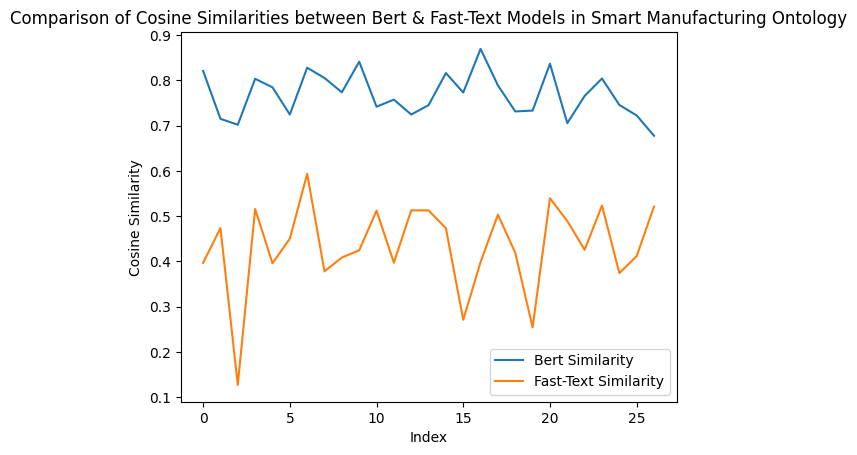

In [ ]:
# Plotting the results
x_smo = df_compare_smo.index.values
y1_smo = df_compare_smo['Cosine_Similarity_Bert']
y2_smo = df_compare_smo['Cosine_Similarity_Fast-Text']

plt.plot(x_smo, y1_smo, label='Bert Similarity')
plt.plot(x_smo, y2_smo, label='Fast-Text Similarity')
plt.xlabel('Index')
plt.ylabel('Cosine Similarity')
plt.title('Comparison of Cosine Similarities between Bert & Fast-Text Models in Smart Manufacturing Ontology')
plt.legend()
plt.show()

## Choosing the best ontology with Cosine Similarity

In [ ]:
# Add the ontology column
df_cosine_similarity_mason['Ontology'] = 'Mason'
df_cosine_similarity_saref4inma['Ontology'] = 'Saref'
df_cosine_similarity_msdl['Ontology'] = 'MSDL'
df_cosine_similarity_pronto['Ontology'] = 'Pronto'
df_cosine_similarity_smo['Ontology'] = 'SMO'

# Removing the Embedding columns from all dataframes
df_cosine_similarity_mason = df_cosine_similarity_mason.drop(['Input_Sentence_Embedding', 'Annotation_Embedding'], axis=1)
df_cosine_similarity_saref4inma = df_cosine_similarity_saref4inma.drop(['Input_Sentence_Embedding', 'Annotation_Embedding'], axis=1)
df_cosine_similarity_msdl = df_cosine_similarity_msdl.drop(['Input_Sentence_Embedding', 'Annotation_Embedding'], axis=1)
df_cosine_similarity_pronto = df_cosine_similarity_pronto.drop(['Input_Sentence_Embedding', 'Annotation_Embedding'], axis=1)
df_cosine_similarity_smo = df_cosine_similarity_smo.drop(['Input_Sentence_Embedding', 'Annotation_Embedding'], axis=1)

In [ ]:
df_onto_merge = pd.concat([df_cosine_similarity_mason, df_cosine_similarity_saref4inma, df_cosine_similarity_msdl, df_cosine_similarity_pronto, df_cosine_similarity_smo], ignore_index=True)

# group the dataframe by the sentences in the original paragraph and find the maximum cosine similarity score for each group
max_similarities_onto = df_onto_merge.groupby('Input_Sentence')['Cosine_Similarity'].max().reset_index()

# merge the original dataframe with the maximum cosine similarity scores
df_onto = pd.merge(df_onto_merge, max_similarities_onto, on=['Input_Sentence', 'Cosine_Similarity'], how='inner')

# Remove duplicates based on column 'Cosine_Similarity'
df_onto.drop_duplicates(subset=['Cosine_Similarity'], keep='first', inplace=True)

# Reset the index of the resulting dataframe
df_onto.reset_index(drop=True, inplace=True)

df_onto.head(30)

,Input_Sentence,Annotation,Class,Cosine_Similarity,Ontology
0,The manufacturing resource class has two subcl...,Resource class contains geographic human mater...,Resource,0.783354,Mason
1,Labor skill represents labor rate and skill de...,Describes manufacturing operations which affe...,LossOfVolume,0.723504,Mason
2,There are four subclasses machine die mold and...,Describes moulding and injections machines,FoundingMachine,0.812613,Mason
3,A tool represents a tool used in the machining...,Represents machines with shearing capabilities...,Shearing_machine-tool,0.862357,Mason
4,Manufacturing cost and time estimations have b...,Entity class contains helper concepts for the ...,Entity,0.776152,Mason
5,On the other hand Resources can also influence...,Represent the material resources such as machi...,MaterialResource,0.770530,Mason
6,The tool class has four subclasses cutting too...,A production equipment is a specialization of ...,ProductionEquipment,0.809573,Saref
7,The activitybased costing method has been adop...,A subclass of sarefMeasurement that represents...,Measurement,0.771893,Saref
8,Each processing activity involves the cost of ...,Functionallity neccessary to accomplish the ta...,ProductionEquipmentFunction,0.781174,Saref
9,These three notions are interrelated for examp...,A uniform collection of tangible raw material ...,MaterialBatch,0.881609,Saref


# MLP

## Annotations

In [ ]:
# Combine all the sannotations and their respective ontology names into a single list
ann_list = valid_sentences_mason + valid_sentences_saref4inma + valid_sentences_msdl + valid_sentences_pronto + valid_sentences_smo
ann_onto_names = ['Mason'] * len(valid_sentences_mason) + ['Saref'] * len(valid_sentences_saref4inma) + ['MSDL'] * len(valid_sentences_msdl) + ['Pronto'] * len(valid_sentences_pronto) + ['SMO'] * len(valid_sentences_smo)

# Create a dataframe with the annotations and their ontology names
df_mlp = pd.DataFrame({'Annotation': ann_list, 'Ontology': ann_onto_names})

In [ ]:
# Load pre-trained model and tokenizer
model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# define the get_embedding function
def get_embedding(text, model, tokenizer):
    input_ids = tokenizer.encode(text, add_special_tokens=True)
    input_ids = torch.tensor(input_ids).unsqueeze(0)
    with torch.no_grad():
        outputs = model(input_ids)
        last_hidden_states = outputs[0].squeeze(0)
        mean_last_hidden_states = torch.mean(last_hidden_states, dim=0)
    return mean_last_hidden_states.numpy()

In [ ]:
# Apply the Bert model to obtain annotation embeddings
df_mlp["Annotation_Embedding"] = df_mlp["Annotation"].apply(lambda x: get_embedding(x, model, tokenizer))

df_mlp.head(10)

,Annotation,Ontology,Annotation_Embedding
0,Describes the manufacturing operations,Mason,"[-0.1872495, 0.26908067, -0.26323622, -0.17842..."
1,Helpers for describing parts geometry,Mason,"[-0.29088676, -0.13220097, 0.1310764, 0.294790..."
2,Describes raw material features of a part,Mason,"[-0.06167589, -0.08338829, -0.19123909, 0.1661..."
3,Describes a created System,Mason,"[-0.13892639, -0.04424342, -0.018344728, -0.00..."
4,Describes a produced Set,Mason,"[0.054516267, 0.008098264, -0.016586443, -0.01..."
5,Concrete part being worked,Mason,"[0.06728298, -0.09657657, -0.16773684, -0.0540..."
6,Represents various geographic resources such a...,Mason,"[0.43465045, 0.56699246, 0.40639502, 0.0199666..."
7,Represent the material resources such as machi...,Mason,"[0.21360384, 0.43746302, 0.13361248, 0.1695886..."
8,Describes the machine resources,Mason,"[-0.21173002, 0.10758114, -0.07810143, 0.19092..."
9,Describes processes related to logistic operat...,Mason,"[-0.030764699, -0.115725726, -0.1045921, 0.009..."


In [ ]:
X = df_mlp["Annotation_Embedding"].tolist()
y = df_mlp["Ontology"].tolist()

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
input_dim = 768  # Size of BERT embeddings
hidden_dim = 768  # Size of hidden layer
output_dim = len(label_encoder.classes_)  # Number of unique labels

model_mlp = MLP(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mlp.parameters(), lr=0.001)

In [ ]:
X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train)
X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test)

In [ ]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

num_epochs = 10
batch_size = 32

for epoch in range(num_epochs):
    running_loss = 0.0
    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i+batch_size]
        labels = y_train[i:i+batch_size]

        optimizer.zero_grad()

        outputs = model_mlp(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate validation loss
    with torch.no_grad():
        val_outputs = model_mlp(X_val.float())
        val_loss = criterion(val_outputs, y_val)

    print(f'Epoch {epoch+1} - Training Loss: {running_loss/len(X_train)} - Validation Loss: {val_loss.item()}')

Epoch 1 - Training Loss: 0.05054240204669811 - Validation Loss: 1.1207865476608276
Epoch 2 - Training Loss: 0.03203068397663258 - Validation Loss: 0.8692527413368225
Epoch 3 - Training Loss: 0.020287385417355433 - Validation Loss: 0.7346152663230896
Epoch 4 - Training Loss: 0.012972271138871158 - Validation Loss: 0.618432343006134
Epoch 5 - Training Loss: 0.008593096087376276 - Validation Loss: 0.5699107050895691
Epoch 6 - Training Loss: 0.005526106045753868 - Validation Loss: 0.5396959781646729
Epoch 7 - Training Loss: 0.0036456441437756576 - Validation Loss: 0.5176005959510803
Epoch 8 - Training Loss: 0.002472825348377228 - Validation Loss: 0.4868355095386505
Epoch 9 - Training Loss: 0.0017128790452800415 - Validation Loss: 0.4611992835998535
Epoch 10 - Training Loss: 0.0012181631668850227 - Validation Loss: 0.4435989558696747


In [ ]:
with torch.no_grad():
    test_outputs = model_mlp(X_test.float())
    predicted = torch.argmax(test_outputs, dim=1)
    accuracy = (predicted == y_test).sum().item() / len(y_test)
    print(f'Test Accuracy: {accuracy}')

Test Accuracy: 0.9142857142857143


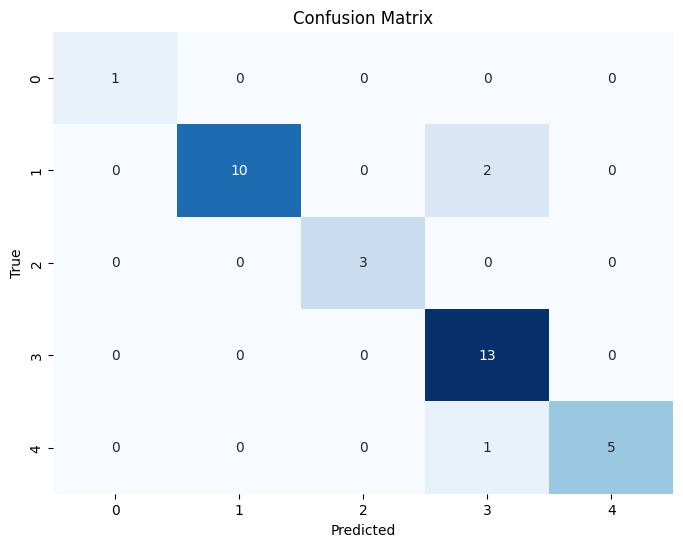

In [ ]:
# Convert the predicted numpy array to a PyTorch tensor
predicted = predicted.numpy()

# Compute the confusion matrix
cm = confusion_matrix(y_test, predicted)

# Create a heatmap plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Convert the predicted tensor to a numpy array
predicted = torch.from_numpy(predicted)

# Calculate precision, recall, and F1 score
precision = precision_score(y_test, predicted, average='macro')
recall = recall_score(y_test, predicted, average='macro')
f1 = f1_score(y_test, predicted, average='macro')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.9625
Recall: 0.9333333333333333
F1 Score: 0.9429467084639498


## Projection of Annotation Embeddings

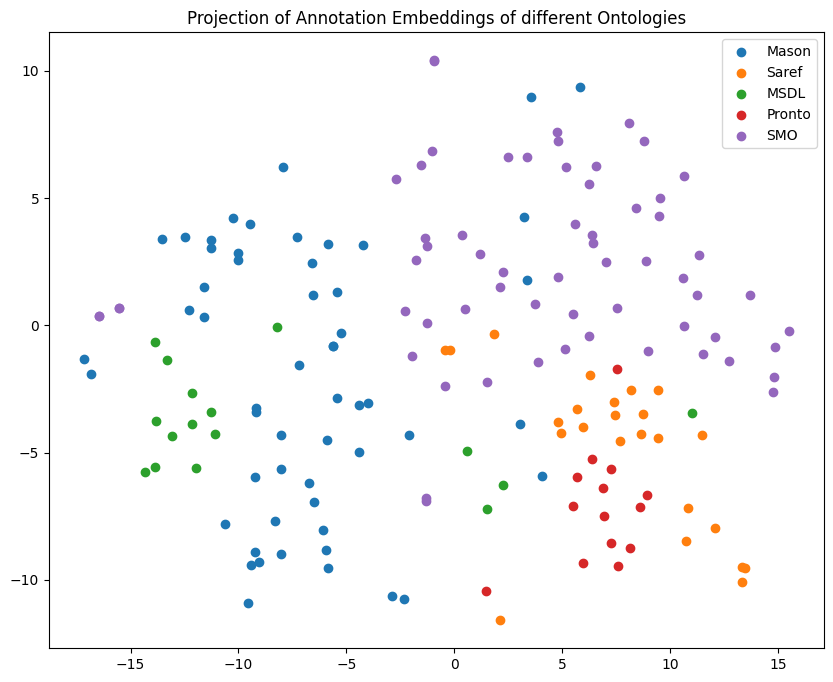

In [ ]:
# Extract embeddings and ontology names
embeddings_ann = np.array(df_mlp["Annotation_Embedding"].tolist())
ontology_names = df_mlp["Ontology"].tolist()

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
embeddings_proj = tsne.fit_transform(embeddings_ann)

# Create a new DataFrame with the embeddings and ontology names
df_projection = pd.DataFrame(embeddings_proj, columns=['X', 'Y'])
df_projection["Ontology"] = ontology_names

# Plot the projection
plt.figure(figsize=(10, 8))
for ontology_name in df_projection["Ontology"].unique():
    subset = df_projection[df_projection["Ontology"] == ontology_name]
    plt.scatter(subset['X'], subset['Y'], label=ontology_name)

plt.title('Projection of Annotation Embeddings of different Ontologies')
plt.legend()
plt.show()

## Choosing the best ontology with MLP

### Input Text

In [ ]:
#Create a dataframe with the input sentences
df_input_mlp = pd.DataFrame({'Input_Sentence': valid_sentences})

In [ ]:
# Apply the Bert model to obtain input sentences embeddings
df_input_mlp["Input_Sentence_Embedding"] = df_input_mlp["Input_Sentence"].apply(lambda x: get_embedding(x, model, tokenizer))

df_input_mlp.head(17)

,Input_Sentence,Input_Sentence_Embedding
0,A manufacturing resource is a physical machine...,"[0.02053377, 0.36042503, -0.14129059, 0.335688..."
1,The manufacturing resource class has two subcl...,"[-0.028008692, 0.116112635, -0.18360376, 0.256..."
2,Labor skill represents labor rate and skill de...,"[0.20286956, 0.035978027, 0.10824008, 0.278719..."
3,The manufacturing equipment subclass represent...,"[0.1603254, 0.27694675, -0.109380245, -0.03558..."
4,There are four subclasses machine die mold and...,"[0.2069281, 0.020959228, 0.027157933, 0.191676..."
5,If necessary other equipment classes may be ad...,"[0.14093399, 0.018831663, 0.018648416, 0.08639..."
6,A piece of equipment has a set of parameters t...,"[0.3047745, 0.12560761, -0.049202126, 0.097845..."
7,A machine can be a machining centre casting ma...,"[0.52098066, 0.115130186, 0.06317457, 0.043813..."
8,A machine has a set of parameters such as dime...,"[0.024191365, -0.21037242, 0.14857751, 0.15994..."
9,A tool represents a tool used in the machining...,"[0.014235898, -0.019473657, -0.056053758, 0.12..."


In [ ]:
# Convert BERT embeddings to tensors
X_new = torch.tensor(df_input_mlp['Input_Sentence_Embedding'].tolist())

In [ ]:
with torch.no_grad():
    outputs = model_mlp(X_new.float())
    predicted_labels = label_encoder.inverse_transform(torch.argmax(outputs, dim=1))

df_input_mlp['Predicted Ontology'] = predicted_labels

In [ ]:
df_input_mlp = df_input_mlp.drop(['Input_Sentence_Embedding'], axis=1)

In [ ]:
df_input_mlp.head(30)

,Input_Sentence,Predicted Ontology
0,A manufacturing resource is a physical machine...,SMO
1,The manufacturing resource class has two subcl...,Mason
2,Labor skill represents labor rate and skill de...,Mason
3,The manufacturing equipment subclass represent...,SMO
4,There are four subclasses machine die mold and...,Mason
5,If necessary other equipment classes may be ad...,MSDL
6,A piece of equipment has a set of parameters t...,SMO
7,A machine can be a machining centre casting ma...,SMO
8,A machine has a set of parameters such as dime...,Pronto
9,A tool represents a tool used in the machining...,SMO


# Chosen Ontology by both the Methods

In [ ]:
# Merge both the dataframes
df_chosen_onto = pd.merge(df_onto, df_input_mlp, on='Input_Sentence', how='left')

# Removing unecessary columns
df_chosen_onto = df_chosen_onto.drop(['Annotation', 'Class', 'Cosine_Similarity'], axis=1)

# Renaming the columns
df_chosen_onto.rename(columns={'Ontology': 'Ontology_Cosine_Similarity', 'Predicted Ontology': 'Ontology_MLP'}, inplace=True)

df_chosen_onto.head(30)

,Input_Sentence,Ontology_Cosine_Similarity,Ontology_MLP
0,The manufacturing resource class has two subcl...,Mason,Mason
1,Labor skill represents labor rate and skill de...,Mason,Mason
2,There are four subclasses machine die mold and...,Mason,Mason
3,A tool represents a tool used in the machining...,Mason,SMO
4,Manufacturing cost and time estimations have b...,Mason,Mason
5,On the other hand Resources can also influence...,Mason,SMO
6,The tool class has four subclasses cutting too...,Saref,Saref
7,The activitybased costing method has been adop...,Saref,Pronto
8,Each processing activity involves the cost of ...,Saref,SMO
9,These three notions are interrelated for examp...,Saref,Saref
